In [6]:
# 1 📂 SNAPSHOT IMPORT - Campaign Statistics & Stock Data
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime

# 📁 Snapshot Directory
snap_dir = Path(r"C:\Users\Marco.Africani\OneDrive - AVU SA\AVU CPI Campaign\Puzzle_control_Reports\IRON_DATA\snapshots")
print(f"📁 SNAP dir: {snap_dir}")

# 🧊 Import Campaign Statistics Snapshot
campaign_stats_path = snap_dir / "campaign_statistics.pkl"
campaign_stats_raw = pd.read_pickle(campaign_stats_path)
print(f"🧊 Snapshot rebuilt: campaign_statistics.pkl  ({campaign_stats_raw.shape[0]}×{campaign_stats_raw.shape[1]})")

# ❌ APPLY GLOBAL FILTERS - Exclude Type=HORECA/TRADE and Sub-Type=Lead
print(f"📊 Total campaigns loaded: {len(campaign_stats_raw)}")
campaign_stats = campaign_stats_raw[
    (~campaign_stats_raw['type'].isin(['HORECA', 'TRADE'])) &
    (campaign_stats_raw['sub-type'] != 'Lead')
].copy()
print(f"❌ Filtered out: Type=HORECA/TRADE, Sub-Type=Lead")
print(f"📊 Campaigns after filtering: {len(campaign_stats)} (removed {len(campaign_stats_raw) - len(campaign_stats)})")

# 🧊 Import Detailed Stock List Snapshot  
stock_path = snap_dir / "detailed_stock_list.pkl"
stock_data = pd.read_pickle(stock_path)
print(f"🧊 Snapshot rebuilt: detailed_stock_list.pkl  ({stock_data.shape[0]}×{stock_data.shape[1]})")

print(f"\n✅ Snapshots loaded successfully")
print(f"📊 Analysis ready: {datetime.now().strftime('%B %d, %Y at %H:%M:%S')}")
print(f"🎯 All subsequent analyses will use filtered campaign data (excluding Horeca/Trade/Lead)")

# 🎨 Stock Level Legend (refined ranges)
print("\n🎨 COLOR LEGEND:")
print("🟣 Purple: 1-12")
print("🟨 Gold: 13-49")
print("🟦 Blue: 50-199")
print("🩷 Pink: 200-499")
print("🟢 Green: 500+")
print("⚪ White: Unknown/No price\n")

📁 SNAP dir: C:\Users\Marco.Africani\OneDrive - AVU SA\AVU CPI Campaign\Puzzle_control_Reports\IRON_DATA\snapshots
🧊 Snapshot rebuilt: campaign_statistics.pkl  (182×23)
📊 Total campaigns loaded: 182
❌ Filtered out: Type=HORECA/TRADE, Sub-Type=Lead
📊 Campaigns after filtering: 149 (removed 33)
🧊 Snapshot rebuilt: detailed_stock_list.pkl  (4710×43)

✅ Snapshots loaded successfully
📊 Analysis ready: October 15, 2025 at 15:51:54
🎯 All subsequent analyses will use filtered campaign data (excluding Horeca/Trade/Lead)

🎨 COLOR LEGEND:
🟣 Purple: 1-12
🟨 Gold: 13-49
🟦 Blue: 50-199
🩷 Pink: 200-499
🟢 Green: 500+
⚪ White: Unknown/No price



In [7]:
# 2 🎨 COLOR-CODED TOP 25 WINNERS BY WINE PRICE
from IPython.display import display
from datetime import datetime

def format_swiss_number(number):
    """Format numbers in Swiss style with apostrophes (82'723.98)"""
    if pd.isna(number) or number == 0:
        return "0.00"
    
    # Round to 2 decimal places
    number = round(float(number), 2)
    
    # Split into integer and decimal parts
    integer_part = int(abs(number))
    decimal_part = f"{abs(number) - integer_part:.2f}"[2:]  # Get decimal part (2 digits)
    
    # Format integer part with apostrophes
    formatted_int = f"{integer_part:,}".replace(",", "'")
    result = f"{formatted_int}.{decimal_part}"
    
    return f"-{result}" if number < 0 else result

print("💰 TOP SELLING WINE CAMPAIGNS - OVERALL RANKINGS")
print("="*60)
print(f"📊 Analysis Date: {datetime.now().strftime('%B %d, %Y at %H:%M:%S')}")
print("🏆 Winner Calculation: 60% Conversion Rate + 40% Total Sales Amount")
print("✅ Using filtered data: HORECA/TRADE/Lead campaigns excluded (applied in Cell 1)")
print("📊 Normalization: Norm_Conversion = conversion_rate/max_conversion | Norm_Sales = total_sales/max_sales")
print("💰 Swiss Formatting: Total Sales with apostrophes (82'723.98)")
print("🎯 Focus: Top selling wine campaigns ranked by weighted score\n")

# ---- Use Pre-Filtered Campaign Statistics ----
campaigns_filtered = campaign_stats.copy()  # Already filtered in Cell 1
print(f"📊 Filtered campaigns available: {len(campaigns_filtered)}")

# ---- Extract key columns for winner calculation ----
# Column references based on the actual data structure
conversion_rate = pd.to_numeric(campaigns_filtered['conversion rate %'], errors='coerce').fillna(0)
total_sales = pd.to_numeric(campaigns_filtered['total sales amount (lcy)'], errors='coerce').fillna(0)

# Other display columns
wine_name = campaigns_filtered['main wine name'].fillna('Unknown')
campaign_no = campaigns_filtered['campaign no.'].fillna('')
vintage_code = campaigns_filtered['vintage code'].fillna('')
scheduled_datetime = campaigns_filtered['scheduled datetime1'].fillna('')  # Using scheduled datetime1
multiple_wines = campaigns_filtered['multiple wines'].fillna('')
email_sent = pd.to_numeric(campaigns_filtered['email sent'], errors='coerce').fillna(0)
main_bottle_price = pd.to_numeric(campaigns_filtered['main bottle price (lcy)'], errors='coerce').fillna(0)
delayed_sending = campaigns_filtered['delayed sending'].fillna(False)
unique_customers_bought = pd.to_numeric(campaigns_filtered['total unique customers bought'], errors='coerce').fillna(0)

# ---- Calculate Winner Score (60% conversion + 40% sales) ----
# Normalize conversion rate and sales for scoring
max_conversion = max(conversion_rate.max(), 1e-12)  # Avoid division by zero
max_sales = max(total_sales.max(), 1e-12)

print(f"📊 Normalization factors: Max Conversion = {max_conversion:.2f}% | Max Sales = CHF {format_swiss_number(max_sales)}")

# Calculate normalized scores
norm_conversion = conversion_rate / max_conversion  # Each campaign's conversion / best conversion
norm_sales = total_sales / max_sales  # Each campaign's sales / best sales

# Final weighted score: 60% conversion + 40% sales
weighted_score = 0.6 * norm_conversion + 0.4 * norm_sales

# ---- Build Winners DataFrame ----
winners_df = pd.DataFrame({
    'Campaign_No': campaign_no,
    'Wine': wine_name,  # Renamed from Main_Wine_Name to Wine
    'Vintage': vintage_code,  # Renamed from Vintage_Code to Vintage
    'Starting_Date': scheduled_datetime,
    'Multiple': multiple_wines,
    'Email_Sent': email_sent,
    'Conversion_Rate_%': conversion_rate,
    'Total_Sales_Amount_LCY': total_sales,
    'Unique_Bought': unique_customers_bought,
    'Norm_Conversion': norm_conversion,
    'Norm_Sales': norm_sales,
    'Weighted_Score': weighted_score,
    'Main_Bottle_Price_LCY': main_bottle_price,
    'Delayed_Sending': delayed_sending
})

# Sort by weighted score (descending) and add overall position
winners_df = winners_df.sort_values('Weighted_Score', ascending=False).reset_index(drop=True)
winners_df['Overall_Position'] = range(1, len(winners_df) + 1)  # Add overall ranking

# Add Main Item No for Producer Name mapping
winners_df = winners_df.merge(
    campaigns_filtered[['campaign no.', 'main item no.']],
    left_on='Campaign_No',
    right_on='campaign no.',
    how='left'
)

# Add Producer Name using Main Item No mapping
producer_mapping = pd.DataFrame({
    'Main_Item_No': pd.to_numeric(campaign_stats['main item no.'], errors='coerce').fillna(0).astype(int),
    'Producer_Name': campaign_stats['producer name']
}).drop_duplicates(subset=['Main_Item_No'])

# Convert main item no. to integer for matching
winners_df['Main_Item_No'] = pd.to_numeric(winners_df['main item no.'], errors='coerce').fillna(0).astype(int)

# Merge Producer Name
winners_df = winners_df.merge(
    producer_mapping,
    on='Main_Item_No',
    how='left'
)

top_25_winners = winners_df.head(25).copy()

# ---- Price Category Color Coding ----
def get_price_emoji(price):
    """Return emoji based on updated price tier ranges"""
    if pd.isna(price) or price <= 0: return "⚪"  # Unknown/No price
    if price >= 750.01: return "🟣"  # Purple: Extra luxury wines (CHF 750.01+)
    if price >= 300.01: return "🟨"  # Gold: Luxury wines (CHF 300.01-750.00)
    if price >= 100.01: return "💎"  # Blue: Premium wines (CHF 100.01-300.00)
    if price >= 50.01:  return "🩷"  # Pink: Mid-range wines (CHF 50.01-100.00)
    return "🟢"  # Green: Budget wines (MAX CHF 50)

# Add color coding and rank (on the right)
top_25_winners['🎨'] = top_25_winners['Main_Bottle_Price_LCY'].apply(get_price_emoji)
top_25_winners['Rank'] = range(1, len(top_25_winners) + 1)

# ---- Display Results ----
print("🎨 PRICE TIER COLOR LEGEND:")
print("🟣 Purple: Extra luxury wines (CHF 750.01+)")
print("🟨 Gold: Luxury wines (CHF 300.01–750.00)")
print("💎 Diamond: Premium wines (CHF 100.01–300.00)")
print("🩷 Pink: Mid-range wines (CHF 50.01–100.00)")
print("🟢 Green: Budget wines (≤ CHF 50.00)")
print("⚪ White: Unknown/No price\n")

# Prepare display table with requested columns order (Producer_Name added after Vintage)
display_table = top_25_winners[['Overall_Position', 'Campaign_No', '🎨', 'Wine', 'Vintage', 'Producer_Name', 'Starting_Date',
                               'Multiple', 'Email_Sent', 'Unique_Bought', 'Conversion_Rate_%', 'Total_Sales_Amount_LCY',
                               'Norm_Conversion', 'Norm_Sales', 'Weighted_Score', 'Delayed_Sending']].copy()

# Format wine names for better display
display_table['Wine'] = display_table['Wine'].astype(str).apply(
    lambda x: x if len(x) <= 25 else x[:25] + "…"
)

# Format vintage to show just the year number (remove .0)
display_table['Vintage'] = pd.to_numeric(display_table['Vintage'], errors='coerce').fillna(0).astype(int).astype(str).replace('0', '')

# Format starting date for better display (remove time, show only date)
display_table['Starting_Date'] = pd.to_datetime(display_table['Starting_Date'], errors='coerce').dt.strftime('%Y-%m-%d').fillna('')

# Add "-D" suffix to Campaign_No if Delayed_Sending is True
display_table['Campaign_No'] = display_table.apply(
    lambda row: f"{row['Campaign_No']}-D" if row['Delayed_Sending'] == True else str(row['Campaign_No']), 
    axis=1
)

# Create a formatted version for display while keeping the original numeric column
display_table['Total_Sales_Formatted'] = display_table['Total_Sales_Amount_LCY'].apply(format_swiss_number)

# Round numeric columns for better display
display_table['Norm_Conversion'] = display_table['Norm_Conversion'].round(4)
display_table['Norm_Sales'] = display_table['Norm_Sales'].round(4)
display_table['Weighted_Score'] = display_table['Weighted_Score'].round(4)

# Reorder columns to show formatted sales instead of raw numbers (Producer_Name after Vintage)
display_cols = ['Overall_Position', 'Campaign_No', '🎨', 'Wine', 'Vintage', 'Producer_Name', 'Starting_Date',
               'Multiple', 'Email_Sent', 'Unique_Bought', 'Conversion_Rate_%', 'Total_Sales_Formatted',
               'Norm_Conversion', 'Norm_Sales', 'Weighted_Score']

# Remove Delayed_Sending column from display (used only for formatting)
display_table = display_table.drop('Delayed_Sending', axis=1)

print("🏆 TOP 25 WINE CAMPAIGN WINNERS:")
display(display_table[display_cols])

# ---- Summary Statistics ----
print("\n📊 WINNER ANALYSIS SUMMARY:")
print(f"• #1 Winner: {top_25_winners.iloc[0]['Wine']} | Weighted Score: {top_25_winners.iloc[0]['Weighted_Score']:.4f}")
print(f"• Price Range: CHF {top_25_winners['Main_Bottle_Price_LCY'].min():.0f} - CHF {top_25_winners['Main_Bottle_Price_LCY'].max():.0f}")
print(f"• Avg Conversion Rate: {top_25_winners['Conversion_Rate_%'].mean():.2f}%")
print(f"• Total Sales (Top 25): CHF {format_swiss_number(top_25_winners['Total_Sales_Amount_LCY'].sum())}")
print(f"• Total Emails Sent: {top_25_winners['Email_Sent'].sum():,.0f}")
print(f"• Total Unique Customers: {top_25_winners['Unique_Bought'].sum():,.0f}")
print(f"• Avg Normalized Conversion: {top_25_winners['Norm_Conversion'].mean():.4f}")
print(f"• Avg Normalized Sales: {top_25_winners['Norm_Sales'].mean():.4f}")
print(f"• Delayed Campaigns: {(top_25_winners['Delayed_Sending'] == True).sum()}/{len(top_25_winners)}")

# Price category distribution
print(f"\n🎨 PRICE CATEGORY DISTRIBUTION:")
price_categories = top_25_winners['🎨'].value_counts()
price_meanings = {
    "🟣": "Extra luxury (CHF 750.01+)",
    "🟨": "Luxury (CHF 300.01–750.00)",
    "💎": "Premium (CHF 100.01–300.00)",
    "🩷": "Mid-range (CHF 50.01–100.00)",
    "🟢": "Budget (≤ CHF 50.00)",
    "⚪": "Unknown/No price"
}

for emoji, count in price_categories.items():
    meaning = price_meanings.get(emoji, "Unknown")
    pct = 100 * count / len(top_25_winners)
    print(f"   {emoji} {meaning}: {count} campaigns ({pct:.1f}%)")

💰 TOP SELLING WINE CAMPAIGNS - OVERALL RANKINGS
📊 Analysis Date: October 15, 2025 at 15:51:54
🏆 Winner Calculation: 60% Conversion Rate + 40% Total Sales Amount
✅ Using filtered data: HORECA/TRADE/Lead campaigns excluded (applied in Cell 1)
📊 Normalization: Norm_Conversion = conversion_rate/max_conversion | Norm_Sales = total_sales/max_sales
💰 Swiss Formatting: Total Sales with apostrophes (82'723.98)
🎯 Focus: Top selling wine campaigns ranked by weighted score

📊 Filtered campaigns available: 149
📊 Normalization factors: Max Conversion = 5.90% | Max Sales = CHF 443'359.35
🎨 PRICE TIER COLOR LEGEND:
🟣 Purple: Extra luxury wines (CHF 750.01+)
🟨 Gold: Luxury wines (CHF 300.01–750.00)
💎 Diamond: Premium wines (CHF 100.01–300.00)
🩷 Pink: Mid-range wines (CHF 50.01–100.00)
🟢 Green: Budget wines (≤ CHF 50.00)
⚪ White: Unknown/No price

🏆 TOP 25 WINE CAMPAIGN WINNERS:


,Overall_Position,Campaign_No,🎨,Wine,Vintage,Producer_Name,Starting_Date,Multiple,Email_Sent,Unique_Bought,Conversion_Rate_%,Total_Sales_Formatted,Norm_Conversion,Norm_Sales,Weighted_Score
0,1,CM-25-02231,🩷,Cos d'Estournel,2021,Château Cos d'Estournel,2025-08-29,1,3541,209,5.90,292'386.04,1.0000,0.6595,0.8638
1,2,CM-25-02451,💎,Figeac,2018,Château Figeac,2025-09-16,1,2759,148,5.36,274'386.06,0.9085,0.6189,0.7926
2,3,CM-25-02259,🟨,Masseto,2022,Masseto,2025-09-02,2,228,11,4.82,200'839.06,0.8169,0.4530,0.6714
3,4,CM-25-02630,🟨,IX Proprietary Red Estate,2022,Colgin Cellars,2025-10-02,1,405,23,5.68,91'099.73,0.9627,0.2055,0.6598
4,5,CM-25-02485,💎,Champagne Extra Brut Gran…,2022,Frederic Savart,2025-09-18,1,2085,102,4.89,151'362.80,0.8288,0.3414,0.6338
5,6,CM-25-02394,🟢,Retout,2015,Château du Retout,2025-09-11,1,106,6,5.66,2'298.24,0.9593,0.0052,0.5777
6,7,CM-25-02255,🩷,Galatrona,2023,Fattoria Petrolo,2025-09-02,1,3309,150,4.53,120'766.00,0.7678,0.2724,0.5696
7,8,CM-25-02583,🟣,Cabernet Sauvignon,2021,Screaming Eagle Winery,2025-09-26,2,152,7,4.61,98'090.99,0.7814,0.2212,0.5573
8,9,CM-25-02625-D,🟨,El Tamboril Blanco,2016,Bodega Comando G,2025-10-01,12,170,8,4.71,33'432.85,0.7983,0.0754,0.5091
9,10,CM-25-02321,🟨,Mouton Rothschild,2009,Château Mouton Rothschild,2025-09-07,1,1300,35,2.69,233'806.92,0.4559,0.5274,0.4845



📊 WINNER ANALYSIS SUMMARY:
• #1 Winner: Cos d'Estournel | Weighted Score: 0.8638
• Price Range: CHF 12 - CHF 2500
• Avg Conversion Rate: 3.74%
• Total Sales (Top 25): CHF 2'760'269.29
• Total Emails Sent: 68,950
• Total Unique Customers: 1,482
• Avg Normalized Conversion: 0.6343
• Avg Normalized Sales: 0.2490
• Delayed Campaigns: 3/25

🎨 PRICE CATEGORY DISTRIBUTION:
   💎 Premium (CHF 100.01–300.00): 6 campaigns (24.0%)
   🟨 Luxury (CHF 300.01–750.00): 6 campaigns (24.0%)
   🟢 Budget (≤ CHF 50.00): 6 campaigns (24.0%)
   🩷 Mid-range (CHF 50.01–100.00): 4 campaigns (16.0%)
   🟣 Extra luxury (CHF 750.01+): 3 campaigns (12.0%)


In [8]:
# 3 📅 MULTI-PERIOD WINNERS ANALYSIS WITH STOCK AVAILABILITY
from IPython.display import display
from datetime import datetime, timedelta

print("📅 MULTI-PERIOD WINNERS ANALYSIS WITH STOCK AVAILABILITY")
print("="*65)
print(f"📊 Analysis Date: {datetime.now().strftime('%B %d, %Y at %H:%M:%S')}")
print("🎯 Period Analysis: Last 7, 14, 21, and 30 days")
print("📦 Stock Status: Based on Detailed Stock List (Column B)")
print("🏆 Winner Logic: 60% Conversion + 40% Sales (filtered by period)\n")

# ---- Stock Processing ----
print("📦 Processing Stock Data...")
stock_clean = stock_data.copy()

# Extract item ID from 'id' column and stock quantity from 'stock' column
stock_mapping = pd.DataFrame({
    'item_id': pd.to_numeric(stock_clean['id'], errors='coerce').fillna(0).astype(int),  # 'id' column as integer
    'stock_quantity': pd.to_numeric(stock_clean['stock'], errors='coerce').fillna(0)  # 'stock' column (quantity)
}).drop_duplicates(subset=['item_id'])

print(f"✅ Stock data processed: {len(stock_mapping)} unique items")
print(f"📊 Stock range: {stock_mapping['stock_quantity'].min():.0f} - {stock_mapping['stock_quantity'].max():.0f} bottles")

# ---- Stock Status Functions ----
def get_stock_emoji(quantity):
    """Return emoji based on refined stock quantity ranges"""
    if pd.isna(quantity) or quantity <= 0:
        return "⚪"  # White: Unknown/No stock
    elif 1 <= quantity <= 12:
        return "🟣"  # Purple: 1-12
    elif 13 <= quantity <= 49:
        return "🟨"  # Gold: 13-49
    elif 50 <= quantity <= 199:
        return "🟦"  # Blue: 50-199
    elif 200 <= quantity <= 499:
        return "🩷"  # Pink: 200-499
    elif quantity >= 500:
        return "🟢"  # Green: 500+
    else:
        return "⚪"  # Default: Unknown

def get_stock_status(quantity):
    """Return stock status description based on refined ranges"""
    if pd.isna(quantity) or quantity <= 0:
        return "Unknown/No stock"
    elif 1 <= quantity <= 12:
        return f"Purple ({int(quantity)} bottles)"
    elif 13 <= quantity <= 49:
        return f"Gold ({int(quantity)} bottles)"
    elif 50 <= quantity <= 199:
        return f"Blue ({int(quantity)} bottles)"
    elif 200 <= quantity <= 499:
        return f"Pink ({int(quantity)} bottles)"
    elif quantity >= 500:
        return f"Green ({int(quantity)} bottles)"
    else:
        return f"Other ({int(quantity)} bottles)"

# ---- Price Category Functions (match Cell 2 ranges) ----
def get_price_emoji(price):
    """Return emoji based on updated price tier ranges"""
    if pd.isna(price) or price <= 0: return "⚪"  # Unknown/No price
    if price >= 750.01: return "🟣"  # Purple: Extra luxury wines (CHF 750.01+)
    if price >= 300.01: return "🟨"  # Gold: Luxury wines (CHF 300.01-750.00)
    if price >= 100.01: return "💎"  # Blue: Premium wines (CHF 100.01-300.00)
    if price >= 50.01:  return "🩷"  # Pink: Mid-range wines (CHF 50.01-100.00)
    return "🟢"  # Green: Budget wines (MAX CHF 50)

# ---- Period Analysis ----
current_date = datetime.now()
periods = [
    (7, "Last 7 Days", "🗓️"),
    (14, "Last 14 Days", "📅"), 
    (21, "Last 21 Days", "📆"),
    (30, "Last 30 Days", "🗓️")
]

print("📦 STOCK STATUS LEGEND (using refined ranges from Cell 1):")

print("🎨 UPDATED PRICE TIER LEGEND:")
print("🟣 Purple: Extra luxury wines (CHF min avg 750.01+)")
print("🟨 Gold: Luxury wines (CHF min avg 300.01-max avg 750.00)")
print("💎 Blue: Premium wines (CHF min avg 100.01-max avg 300.00)")
print("🩷 Pink: Mid-range wines (min avg 50.01-max avg 100.00)")
print("🟢 Green: Budget wines (MAX avg CHF 50)")
print("⚪ White: Unknown/No price\n")

# Use the complete winners data from cell 2 (all campaigns, not just top 25)
winners_with_dates = winners_df.copy()

# Convert Starting_Date to datetime for filtering
winners_with_dates['Starting_Date_dt'] = pd.to_datetime(winners_with_dates['Starting_Date'], errors='coerce')

# Check if Main_Item_No column exists from Cell 2
if 'Main_Item_No' not in winners_with_dates.columns:
    print("⚠️ Main_Item_No not found in winners_df, creating mapping...")
    # Add stock information by matching main item numbers
    campaigns_with_items = campaigns_filtered.copy()
    item_mapping = pd.DataFrame({
        'Campaign_No': campaigns_with_items['campaign no.'],
        'Main_Item_No': pd.to_numeric(campaigns_with_items['main item no.'], errors='coerce').fillna(0).astype(int)
    })
    
    # Merge with winners to get item numbers
    winners_with_items = winners_with_dates.merge(
        item_mapping, 
        left_on='Campaign_No', 
        right_on='Campaign_No', 
        how='left'
    )
else:
    print("✅ Main_Item_No found in winners_df from Cell 2")
    winners_with_items = winners_with_dates.copy()

# Match with stock data
winners_with_stock = winners_with_items.merge(
    stock_mapping,
    left_on='Main_Item_No',
    right_on='item_id',
    how='left'
)

# For each period, create analysis
for days, period_name, emoji in periods:
    print(f"\n{emoji} {period_name.upper()} ANALYSIS")
    print("-" * 50)
    
    # Filter by date range
    cutoff_date = current_date - timedelta(days=days)
    period_data = winners_with_stock[
        winners_with_stock['Starting_Date_dt'] >= cutoff_date
    ].copy()
    
    # Ensure we always have exactly 10 winners to display for top 10 analysis
    if period_data.empty or len(period_data) < 10:
        if period_data.empty:
            print(f"⚠️ No campaigns found in {period_name.lower()}, using top 10 overall winners")
            period_top = winners_with_stock.sort_values('Weighted_Score', ascending=False).head(10).copy()
        else:
            print(f"✅ Found {len(period_data)} campaigns in {period_name.lower()}, supplementing with overall winners to reach 10")
            # Take available period campaigns first, then supplement with overall winners
            period_campaigns = period_data.sort_values('Weighted_Score', ascending=False).copy()
            remaining_needed = 10 - len(period_campaigns)
            
            # Get overall winners excluding the ones already in period
            excluded_campaigns = period_campaigns['Campaign_No'].tolist()
            overall_winners = winners_with_stock[
                ~winners_with_stock['Campaign_No'].isin(excluded_campaigns)
            ].sort_values('Weighted_Score', ascending=False).head(remaining_needed).copy()
            
            # Combine period campaigns with overall winners
            period_top = pd.concat([period_campaigns, overall_winners], ignore_index=True)
    else:
        print(f"✅ Found {len(period_data)} campaigns in {period_name.lower()}")
        # Sort by weighted score and take top 10 for each period
        period_top = period_data.sort_values('Weighted_Score', ascending=False).head(10).copy()
    
    period_top['Period_Rank'] = range(1, len(period_top) + 1)
    
    # Add price color coding (🎨) column
    period_top['🎨'] = period_top['Main_Bottle_Price_LCY'].apply(get_price_emoji)
    
    # Add stock status
    period_top['📦'] = period_top['stock_quantity'].apply(get_stock_emoji)
    period_top['Stock_Status'] = period_top['stock_quantity'].apply(get_stock_status)
    
    # Overall_Position should already be included from winners_df
    # Verify it exists in the dataframe
    if 'Overall_Position' not in period_top.columns:
        print(f"⚠️ Warning: Overall_Position column missing, adding from winners_df")
        period_top = period_top.merge(
            winners_df[['Campaign_No', 'Overall_Position']], 
            on='Campaign_No', 
            how='left'
        )
    
    # Add Producer Name from campaign_stats using Main Item No. (Column Q)
    producer_mapping = pd.DataFrame({
        'Main_Item_No': pd.to_numeric(campaign_stats['main item no.'], errors='coerce').fillna(0).astype(int),
        'Producer_Name': campaign_stats['producer name']
    })
    
    # Remove duplicates based on Main_Item_No (keep first occurrence)
    producer_mapping = producer_mapping.drop_duplicates(subset=['Main_Item_No'])
    
    # Merge using Main_Item_No to get Producer Name
    period_top = period_top.merge(
        producer_mapping,
        on='Main_Item_No',
        how='left'
    )
    
    # Backup producer lookup from detailed stock list (Column F) for missing producers
    # Create backup producer mapping from stock data (Column F producer, matched by Column A ID)
    if 'producer' in stock_data.columns:  # Column F in detailed stock list
        backup_producer_mapping = pd.DataFrame({
            'item_id': pd.to_numeric(stock_data['id'], errors='coerce').fillna(0).astype(int),  # Column A: ID
            'Backup_Producer': stock_data['producer']  # Column F: Producer
        }).drop_duplicates(subset=['item_id'])
        
        # Merge backup producer info
        period_top = period_top.merge(
            backup_producer_mapping,
            left_on='Main_Item_No',
            right_on='item_id',
            how='left'
        )
        
        # Fill missing Producer_Name with backup producer
        if 'Producer_Name' in period_top.columns and 'Backup_Producer' in period_top.columns:
            period_top['Producer_Name'] = period_top['Producer_Name'].fillna(period_top['Backup_Producer'])
        elif 'Backup_Producer' in period_top.columns and 'Producer_Name' not in period_top.columns:
            # If Producer_Name doesn't exist, create it from backup
            period_top['Producer_Name'] = period_top['Backup_Producer']
        
        # Clean up temporary columns
        if 'Backup_Producer' in period_top.columns:
            period_top = period_top.drop(['Backup_Producer'], axis=1)
        if 'item_id_y' in period_top.columns:
            period_top = period_top.drop(['item_id_y'], axis=1)
    
    # Prepare display table with Stock_Status column before Main_Item_No
    display_cols = [
        'Period_Rank', '🎨', '📦', 'Campaign_No', 'Wine', 'Vintage', 'Producer_Name', 'Starting_Date',
        'Total_Sales_Amount_LCY', 'Unique_Bought', 'Conversion_Rate_%', 'Weighted_Score', 'Stock_Status', 'Main_Item_No', 'Overall_Position'
    ]
    
    # Move Stock_Status before Main_Item_No if not already
    if 'Stock_Status' in display_cols and display_cols.index('Stock_Status') > display_cols.index('Main_Item_No'):
        display_cols.remove('Stock_Status')
        main_item_no_index = display_cols.index('Main_Item_No')
        display_cols.insert(main_item_no_index, 'Stock_Status')
    
    period_display = period_top[[col for col in display_cols if col in period_top.columns]].copy()
    
    # Format columns
    if 'Total_Sales_Amount_LCY' in period_display.columns:
        period_display['Total_Sales_Amount_LCY'] = period_display['Total_Sales_Amount_LCY'].apply(format_swiss_number)
    
    if 'Unique_Bought' in period_display.columns:
        period_display['Unique_Bought'] = pd.to_numeric(period_display['Unique_Bought'], errors='coerce').fillna(0).astype(int)
    
    if 'Weighted_Score' in period_display.columns:
        period_display['Weighted_Score'] = period_display['Weighted_Score'].round(4)
    
    if 'Conversion_Rate_%' in period_display.columns:
        period_display['Conversion_Rate_%'] = period_display['Conversion_Rate_%'].round(2)
    
    # Format Starting_Date to show only date (no time)
    if 'Starting_Date' in period_display.columns:
        period_display['Starting_Date'] = pd.to_datetime(period_display['Starting_Date'], errors='coerce').dt.strftime('%Y-%m-%d').fillna('')
    
    # Format Vintage to show only year (remove .0)
    if 'Vintage' in period_display.columns:
        period_display['Vintage'] = pd.to_numeric(period_display['Vintage'], errors='coerce').fillna(0).astype(int).astype(str).replace('0', '')
    
    # Add -D suffix to Campaign_No if Delayed_Sending is True
    if 'Campaign_No' in period_display.columns and 'Delayed_Sending' in period_top.columns:
        period_display['Campaign_No'] = period_top.apply(
            lambda row: f"{row['Campaign_No']}-D" if row['Delayed_Sending'] == True else str(row['Campaign_No']), 
            axis=1
        )
    
    print(f"🏆 TOP 10 SELLING CAMPAIGNS - {period_name.upper()}:")
    if not period_top.empty:
        display(period_display)
    else:
        print("   No campaigns found in this period")
    
    # Period summary (only if we have campaigns)
    if not period_top.empty:
        # Use refined color system counts
        purple_stock = (period_top['📦'] == '🟣').sum()  # 1-12
        gold_stock = (period_top['📦'] == '🟨').sum()    # 13-49
        blue_stock = (period_top['📦'] == '🟦').sum()    # 50-199
        pink_stock = (period_top['📦'] == '🩷').sum()    # 200-499
        green_stock = (period_top['📦'] == '🟢').sum()   # 500+
        unknown_stock = (period_top['📦'] == '⚪').sum() # Unknown
        
        print(f"\n📊 {period_name.upper()} SUMMARY:")
        print(f"• Total campaigns in period: {len(period_data) if not period_data.empty else 0}")
        print(f"• Top 10 campaigns displayed: {len(period_top)}")
        print(f"• Average weighted score: {period_top['Weighted_Score'].mean():.4f}")
        print(f"• Total sales (Top 10): CHF {format_swiss_number(period_top['Total_Sales_Amount_LCY'].sum())}")
        
        print(f"\n📦 STOCK DISTRIBUTION (Top 10):")
        if purple_stock > 0:
            print(f"   🟣 Purple (1-12): {purple_stock} campaigns ({100*purple_stock/len(period_top):.1f}%)")
        if gold_stock > 0:
            print(f"   🟨 Gold (13-49): {gold_stock} campaigns ({100*gold_stock/len(period_top):.1f}%)")
        if blue_stock > 0:
            print(f"   🟦 Blue (50-199): {blue_stock} campaigns ({100*blue_stock/len(period_top):.1f}%)")
        if pink_stock > 0:
            print(f"   🩷 Pink (200-499): {pink_stock} campaigns ({100*pink_stock/len(period_top):.1f}%)")
        if green_stock > 0:
            print(f"   🟢 Green (500+): {green_stock} campaigns ({100*green_stock/len(period_top):.1f}%)")
        if unknown_stock > 0:
            print(f"   ⚪ Unknown: {unknown_stock} campaigns ({100*unknown_stock/len(period_top):.1f}%)")
    else:
        print(f"\n📊 {period_name.upper()} SUMMARY:")
        print(f"• No campaigns found in this {days}-day period")

print("\n🎯 MULTI-PERIOD ANALYSIS COMPLETE")
print("="*40)
print("📊 Use the refined stock level indicators for campaign decisions:")
print("🟣 Purple (1-12): Limited stock - use cautiously")
print("🟨 Gold (13-49): Low stock - monitor carefully") 
print("🟦 Blue (50-199): Moderate stock - good for campaigns")
print("🩷 Pink (200-499): High stock - excellent for campaigns")
print("🟢 Green (500+): Very high stock - ideal for large campaigns")
print("⚪ Unknown: Check stock status before use")

📅 MULTI-PERIOD WINNERS ANALYSIS WITH STOCK AVAILABILITY
📊 Analysis Date: October 15, 2025 at 15:51:54
🎯 Period Analysis: Last 7, 14, 21, and 30 days
📦 Stock Status: Based on Detailed Stock List (Column B)
🏆 Winner Logic: 60% Conversion + 40% Sales (filtered by period)

📦 Processing Stock Data...
✅ Stock data processed: 4710 unique items
📊 Stock range: 1 - 14118 bottles
📦 STOCK STATUS LEGEND (using refined ranges from Cell 1):
🎨 UPDATED PRICE TIER LEGEND:
🟣 Purple: Extra luxury wines (CHF min avg 750.01+)
🟨 Gold: Luxury wines (CHF min avg 300.01-max avg 750.00)
💎 Blue: Premium wines (CHF min avg 100.01-max avg 300.00)
🩷 Pink: Mid-range wines (min avg 50.01-max avg 100.00)
🟢 Green: Budget wines (MAX avg CHF 50)
⚪ White: Unknown/No price

✅ Main_Item_No found in winners_df from Cell 2

🗓️ LAST 7 DAYS ANALYSIS
--------------------------------------------------
✅ Found 22 campaigns in last 7 days
🏆 TOP 10 SELLING CAMPAIGNS - LAST 7 DAYS:


,Period_Rank,🎨,📦,Campaign_No,Wine,Vintage,Producer_Name,Starting_Date,Total_Sales_Amount_LCY,Unique_Bought,Conversion_Rate_%,Weighted_Score,Stock_Status,Main_Item_No,Overall_Position
0,1,💎,🟣,CM-25-02777,La Mission Haut-Brion,2021,Château La Mission Haut Brion,2025-10-13,62'287.31,43,3.21,0.3826,Purple (6 bottles),55704,17
1,2,🟢,🟨,CM-25-02713,Siepi,2019,Marchesi Mazzei Castello di Fonterutoli,2025-10-09,5'765.25,9,3.40,0.3510,Gold (36 bottles),54636,21
2,3,🩷,🟦,CM-25-02750,Pavie Macquin,2020,Château Pavie Macquin,2025-10-11,25'939.36,28,2.21,0.2481,Blue (72 bottles),53983,33
3,4,💎,🟣,CM-25-02734,La Mission Haut-Brion,2021,Château La Mission Haut Brion,2025-10-09,89'301.78,47,1.55,0.2382,Purple (6 bottles),55704,35
4,5,💎,⚪,CM-25-02729,Palmer Historical XIX L. 20.21,,NaN,2025-10-10,7'880.59,9,2.10,0.2207,Unknown/No stock,60084,39
5,6,🟢,⚪,CM-25-02747,Meyney,2018,NaN,2025-10-12,7'018.07,26,2.01,0.2107,Unknown/No stock,49414,42
6,7,💎,🩷,CM-25-02759,Dominus,2016,Dominus Estate,2025-10-13,92'065.01,39,1.25,0.2102,Pink (426 bottles),49782,43
7,8,🩷,🟨,CM-25-02743,Quintus,2020,Château Quintus,2025-10-10,23'351.39,38,1.75,0.1990,Gold (30 bottles),65331,45
8,9,🟢,🟢,CM-25-02739,Larrivet Haut Brion Rouge,2018,Château Larrivet Haut-Brion,2025-10-09,5'403.52,21,1.82,0.1900,Green (522 bottles),65368,49
9,10,🟢,🟢,CM-25-02744,Guidalberto (2nd Vin),2023,Tenuta San Guido,2025-10-10,12'281.89,33,1.67,0.1809,Green (876 bottles),62855,52



📊 LAST 7 DAYS SUMMARY:
• Total campaigns in period: 22
• Top 10 campaigns displayed: 10
• Average weighted score: 0.2431
• Total sales (Top 10): CHF 331'294.17

📦 STOCK DISTRIBUTION (Top 10):
   🟣 Purple (1-12): 2 campaigns (20.0%)
   🟨 Gold (13-49): 2 campaigns (20.0%)
   🟦 Blue (50-199): 1 campaigns (10.0%)
   🩷 Pink (200-499): 1 campaigns (10.0%)
   🟢 Green (500+): 2 campaigns (20.0%)
   ⚪ Unknown: 2 campaigns (20.0%)

📅 LAST 14 DAYS ANALYSIS
--------------------------------------------------
✅ Found 47 campaigns in last 14 days
🏆 TOP 10 SELLING CAMPAIGNS - LAST 14 DAYS:


,Period_Rank,🎨,📦,Campaign_No,Wine,Vintage,Producer_Name,Starting_Date,Total_Sales_Amount_LCY,Unique_Bought,Conversion_Rate_%,Weighted_Score,Stock_Status,Main_Item_No,Overall_Position
0,1,🟨,🟦,CM-25-02630,IX Proprietary Red Estate,2022,Colgin Cellars,2025-10-02,91'099.73,23,5.68,0.6598,Blue (198 bottles),63171,4
1,2,💎,🟣,CM-25-02777,La Mission Haut-Brion,2021,Château La Mission Haut Brion,2025-10-13,62'287.31,43,3.21,0.3826,Purple (6 bottles),55704,17
2,3,🩷,🟨,CM-25-02689-D,Nuits Saint Georges la Perrière,2021,Domaine Gouges Henri,2025-10-07,3'165.06,5,3.70,0.3791,Gold (18 bottles),64885,19
3,4,🟨,🟣,CM-25-02637-D,Hommage à Jacques Perrin,2013,Château de Beaucastel,2025-10-03,1'587.81,1,3.57,0.3645,Purple (1 bottles),32234,20
4,5,🟢,🟨,CM-25-02713,Siepi,2019,Marchesi Mazzei Castello di Fonterutoli,2025-10-09,5'765.25,9,3.40,0.3510,Gold (36 bottles),54636,21
5,6,🟢,🟨,CM-25-02645,Clos Haut Peyraguey,2017,Clos Haut-Peyraguey,2025-10-03,3'152.67,8,2.67,0.2744,Gold (48 bottles),45585,27
6,7,🟨,🟣,CM-25-02628-D,Grillet Blanc,2019,Château Grillet,2025-10-02,8'764.82,5,2.54,0.2662,Purple (6 bottles),62552,29
7,8,🩷,🩷,CM-25-02688,Saffredi,2021,Fattoria le Pupille,2025-10-07,31'993.42,40,2.19,0.2516,Pink (246 bottles),59276,32
8,9,🩷,🟦,CM-25-02750,Pavie Macquin,2020,Château Pavie Macquin,2025-10-11,25'939.36,28,2.21,0.2481,Blue (72 bottles),53983,33
9,10,💎,🟣,CM-25-02734,La Mission Haut-Brion,2021,Château La Mission Haut Brion,2025-10-09,89'301.78,47,1.55,0.2382,Purple (6 bottles),55704,35



📊 LAST 14 DAYS SUMMARY:
• Total campaigns in period: 47
• Top 10 campaigns displayed: 10
• Average weighted score: 0.3416
• Total sales (Top 10): CHF 323'057.21

📦 STOCK DISTRIBUTION (Top 10):
   🟣 Purple (1-12): 4 campaigns (40.0%)
   🟨 Gold (13-49): 3 campaigns (30.0%)
   🟦 Blue (50-199): 2 campaigns (20.0%)
   🩷 Pink (200-499): 1 campaigns (10.0%)

📆 LAST 21 DAYS ANALYSIS
--------------------------------------------------
✅ Found 65 campaigns in last 21 days
🏆 TOP 10 SELLING CAMPAIGNS - LAST 21 DAYS:


,Period_Rank,🎨,📦,Campaign_No,Wine,Vintage,Producer_Name,Starting_Date,Total_Sales_Amount_LCY,Unique_Bought,Conversion_Rate_%,Weighted_Score,Stock_Status,Main_Item_No,Overall_Position
0,1,🟨,🟦,CM-25-02630,IX Proprietary Red Estate,2022,Colgin Cellars,2025-10-02,91'099.73,23,5.68,0.6598,Blue (198 bottles),63171,4
1,2,🟣,🟣,CM-25-02583,Cabernet Sauvignon,2021,Screaming Eagle Winery,2025-09-26,98'090.99,7,4.61,0.5573,Purple (3 bottles),62292,8
2,3,🟨,⚪,CM-25-02625-D,El Tamboril Blanco,2016,NaN,2025-10-01,33'432.85,8,4.71,0.5091,Unknown/No stock,65647,9
3,4,💎,🩷,CM-25-02602,Pavie,2019,Château Pavie,2025-09-29,443'359.35,218,0.59,0.4600,Pink (408 bottles),51417,13
4,5,💎,🟣,CM-25-02777,La Mission Haut-Brion,2021,Château La Mission Haut Brion,2025-10-13,62'287.31,43,3.21,0.3826,Purple (6 bottles),55704,17
5,6,💎,🟦,CM-25-02586,Champagne Dom Pérignon Special Edition Takashi...,2015,Dom Pérignon,2025-09-26,55'037.05,25,3.25,0.3802,Blue (54 bottles),65703,18
6,7,🩷,🟨,CM-25-02689-D,Nuits Saint Georges la Perrière,2021,Domaine Gouges Henri,2025-10-07,3'165.06,5,3.70,0.3791,Gold (18 bottles),64885,19
7,8,🟨,🟣,CM-25-02637-D,Hommage à Jacques Perrin,2013,Château de Beaucastel,2025-10-03,1'587.81,1,3.57,0.3645,Purple (1 bottles),32234,20
8,9,🟢,🟨,CM-25-02713,Siepi,2019,Marchesi Mazzei Castello di Fonterutoli,2025-10-09,5'765.25,9,3.40,0.3510,Gold (36 bottles),54636,21
9,10,🟣,🟨,CM-25-02598,Barolo Monfortino Riserva,2010,Giacomo Conterno,2025-09-28,82'215.29,10,2.09,0.2867,Gold (42 bottles),43770,25



📊 LAST 21 DAYS SUMMARY:
• Total campaigns in period: 65
• Top 10 campaigns displayed: 10
• Average weighted score: 0.4330
• Total sales (Top 10): CHF 876'040.70

📦 STOCK DISTRIBUTION (Top 10):
   🟣 Purple (1-12): 3 campaigns (30.0%)
   🟨 Gold (13-49): 3 campaigns (30.0%)
   🟦 Blue (50-199): 2 campaigns (20.0%)
   🩷 Pink (200-499): 1 campaigns (10.0%)
   ⚪ Unknown: 1 campaigns (10.0%)

🗓️ LAST 30 DAYS ANALYSIS
--------------------------------------------------
✅ Found 94 campaigns in last 30 days
🏆 TOP 10 SELLING CAMPAIGNS - LAST 30 DAYS:


,Period_Rank,🎨,📦,Campaign_No,Wine,Vintage,Producer_Name,Starting_Date,Total_Sales_Amount_LCY,Unique_Bought,Conversion_Rate_%,Weighted_Score,Stock_Status,Main_Item_No,Overall_Position
0,1,💎,🟢,CM-25-02451,Figeac,2018,Château Figeac,2025-09-16,274'386.06,148,5.36,0.7926,Green (1110 bottles),48976,2
1,2,🟨,🟦,CM-25-02630,IX Proprietary Red Estate,2022,Colgin Cellars,2025-10-02,91'099.73,23,5.68,0.6598,Blue (198 bottles),63171,4
2,3,💎,🩷,CM-25-02485,Champagne Extra Brut Grand Cru Le Mesnil,2022,Frederic Savart,2025-09-18,151'362.80,102,4.89,0.6338,Pink (240 bottles),65596,5
3,4,🟣,🟣,CM-25-02583,Cabernet Sauvignon,2021,Screaming Eagle Winery,2025-09-26,98'090.99,7,4.61,0.5573,Purple (3 bottles),62292,8
4,5,🟨,⚪,CM-25-02625-D,El Tamboril Blanco,2016,NaN,2025-10-01,33'432.85,8,4.71,0.5091,Unknown/No stock,65647,9
5,6,💎,🩷,CM-25-02602,Pavie,2019,Château Pavie,2025-09-29,443'359.35,218,0.59,0.4600,Pink (408 bottles),51417,13
6,7,💎,🟣,CM-25-02777,La Mission Haut-Brion,2021,Château La Mission Haut Brion,2025-10-13,62'287.31,43,3.21,0.3826,Purple (6 bottles),55704,17
7,8,💎,🟦,CM-25-02586,Champagne Dom Pérignon Special Edition Takashi...,2015,Dom Pérignon,2025-09-26,55'037.05,25,3.25,0.3802,Blue (54 bottles),65703,18
8,9,🩷,🟨,CM-25-02689-D,Nuits Saint Georges la Perrière,2021,Domaine Gouges Henri,2025-10-07,3'165.06,5,3.70,0.3791,Gold (18 bottles),64885,19
9,10,🟨,🟣,CM-25-02637-D,Hommage à Jacques Perrin,2013,Château de Beaucastel,2025-10-03,1'587.81,1,3.57,0.3645,Purple (1 bottles),32234,20



📊 LAST 30 DAYS SUMMARY:
• Total campaigns in period: 94
• Top 10 campaigns displayed: 10
• Average weighted score: 0.5119
• Total sales (Top 10): CHF 1'213'809.02

📦 STOCK DISTRIBUTION (Top 10):
   🟣 Purple (1-12): 3 campaigns (30.0%)
   🟨 Gold (13-49): 1 campaigns (10.0%)
   🟦 Blue (50-199): 2 campaigns (20.0%)
   🩷 Pink (200-499): 2 campaigns (20.0%)
   🟢 Green (500+): 1 campaigns (10.0%)
   ⚪ Unknown: 1 campaigns (10.0%)

🎯 MULTI-PERIOD ANALYSIS COMPLETE
📊 Use the refined stock level indicators for campaign decisions:
🟣 Purple (1-12): Limited stock - use cautiously
🟨 Gold (13-49): Low stock - monitor carefully
🟦 Blue (50-199): Moderate stock - good for campaigns
🩷 Pink (200-499): High stock - excellent for campaigns
🟢 Green (500+): Very high stock - ideal for large campaigns
⚪ Unknown: Check stock status before use


In [9]:
# 4 📊 HISTORICAL TOP-15 MATRIX FOR RACE CHARTS
import json
from pathlib import Path
from datetime import datetime

print("📊 HISTORICAL TOP-15 MATRIX FOR RACE CHARTS")
print("="*50)
print(f"📅 Snapshot Date: {datetime.now().strftime('%B %d, %Y at %H:%M:%S')}")

# ---- Prepare Historical Data Directory ----
historical_dir = Path(r"C:\Users\Marco.Africani\OneDrive - AVU SA\AVU CPI Campaign\Puzzle_control_Reports\IRON_DATA\historical")
historical_dir.mkdir(exist_ok=True)
print(f"📁 Historical dir: {historical_dir}")

# ---- Create Current Snapshot Data ----
# Use current date for each execution to track daily changes
data_date = datetime.now()
current_snapshot = {
    'timestamp': datetime.now().isoformat(),
    'date': data_date.strftime('%Y-%m-%d'),
    'analysis_date': data_date.strftime('%B %d, %Y'),
    'total_campaigns': len(campaigns_filtered),
    'max_conversion': max_conversion,
    'max_sales': max_sales,
    'top_15_winners': []
}

# Extract top 15 winners with key metrics for race charts
top_15_historical = top_25_winners.head(15).copy()

for idx, row in top_15_historical.iterrows():
    # Get price tier emoji
    price = row['Main_Bottle_Price_LCY']
    if pd.isna(price) or price <= 0: price_tier = "⚪"
    elif price >= 1000: price_tier = "🟣"  # Extra Luxury
    elif price >= 500:  price_tier = "🟨"  # Luxury
    elif price >= 150:  price_tier = "🟦"  # Premium
    elif price >= 80:   price_tier = "🩷"  # Mid-Range
    else: price_tier = "🟢"  # Budget
    
    winner_data = {
        'rank': idx + 1,
        'campaign_no': str(row['Campaign_No']),
        'wine_name': str(row['Wine'])[:30],  # Truncate for chart readability
        'vintage': str(row['Vintage']) if pd.notna(row['Vintage']) and str(row['Vintage']) != '0' else '',
        'weighted_score': round(float(row['Weighted_Score']), 4),
        'conversion_rate': round(float(row['Conversion_Rate_%']), 2),
        'total_sales': round(float(row['Total_Sales_Amount_LCY']), 2),
        'unique_customers': int(row['Unique_Bought']),
        'email_sent': int(row['Email_Sent']),
        'price_tier': price_tier,
        'main_bottle_price': round(float(row['Main_Bottle_Price_LCY']), 2),
        'norm_conversion': round(float(row['Norm_Conversion']), 4),
        'norm_sales': round(float(row['Norm_Sales']), 4),
        'delayed_sending': bool(row['Delayed_Sending']),
        'display_name': f"{str(row['Wine'])[:20]} {str(row['Vintage']) if pd.notna(row['Vintage']) and str(row['Vintage']) != '0' else ''}".strip()
    }
    current_snapshot['top_15_winners'].append(winner_data)

# ---- Load or Create Historical Matrix ----
historical_file = historical_dir / "top_15_winners_matrix.json"

if historical_file.exists():
    with open(historical_file, 'r', encoding='utf-8') as f:
        historical_data = json.load(f)
    print(f"📚 Loaded existing historical data: {len(historical_data['snapshots'])} snapshots")
else:
    historical_data = {
        'created_date': datetime.now().isoformat(),
        'description': 'Historical Top-15 Wine Campaign Winners Matrix for Race Charts',
        'snapshots': []
    }
    print("🆕 Created new historical matrix")

# ---- Add Current Snapshot ----
historical_data['snapshots'].append(current_snapshot)
historical_data['last_updated'] = datetime.now().isoformat()

# ---- Save Updated Historical Matrix ----
with open(historical_file, 'w', encoding='utf-8') as f:
    json.dump(historical_data, f, indent=2, ensure_ascii=False)

print(f"✅ Historical matrix updated: {len(historical_data['snapshots'])} total snapshots")
print(f"💾 Saved to: {historical_file}")

# ---- Export Race Chart Ready Data ----
race_chart_file = historical_dir / "race_chart_data.json"

# Prepare race chart format (each snapshot becomes a time point)
race_chart_data = {
    'metadata': {
        'title': 'Top Wine Campaign Winners Over Time',
        'description': 'Historical ranking of wine campaigns by weighted score',
        'created': historical_data['created_date'],
        'last_updated': datetime.now().isoformat(),
        'total_snapshots': len(historical_data['snapshots'])
    },
    'time_series': []
}

for snapshot in historical_data['snapshots']:
    time_point = {
        'date': snapshot['date'],
        'timestamp': snapshot['timestamp'],
        'analysis_date': snapshot['analysis_date'],
        'winners': []
    }
    
    for winner in snapshot['top_15_winners']:
        race_entry = {
            'rank': winner['rank'],
            'name': winner['display_name'],
            'campaign_no': winner['campaign_no'],
            'value': winner['weighted_score'],
            'sales': winner['total_sales'],
            'conversion': winner['conversion_rate'],
            'customers': winner['unique_customers'],
            'price_tier': winner['price_tier'],
            'color': {
                '🟣': '#8B5CF6',  # Purple
                '🟨': '#F59E0B',  # Gold
                '🟦': '#3B82F6',  # Blue
                '🩷': '#EC4899',  # Pink
                '🟢': '#10B981',  # Green
                '⚪': '#9CA3AF'   # Gray
            }.get(winner['price_tier'], '#9CA3AF')
        }
        time_point['winners'].append(race_entry)
    
    race_chart_data['time_series'].append(time_point)

# Save race chart data
with open(race_chart_file, 'w', encoding='utf-8') as f:
    json.dump(race_chart_data, f, indent=2, ensure_ascii=False)

print(f"🏁 Race chart data exported: {race_chart_file}")

# ---- Display Current Snapshot Summary ----
print(f"📊 CURRENT SNAPSHOT SUMMARY:")
print(f"• Snapshot ID: {len(historical_data['snapshots'])}")
print(f"• Date: {current_snapshot['analysis_date']}")
print(f"• Total Campaigns Analyzed: {current_snapshot['total_campaigns']}")
print(f"• Max Conversion Rate: {current_snapshot['max_conversion']:.2f}%")
print(f"• Max Sales: CHF {format_swiss_number(current_snapshot['max_sales'])}")
print(f"• Top 15 Winners Captured: {len(current_snapshot['top_15_winners'])}")

# ---- Display Top 15 Winners Table ----
print(f"\n🏆 TOP 15 WINNERS - CURRENT SNAPSHOT")
print("="*50)

# Create display table for top 15 winners
top_15_display = top_15_historical.copy()

# Merge wine name and vintage in same column
top_15_display['Wine_Vintage'] = top_15_display.apply(
    lambda row: f"{str(row['Wine'])} {str(row['Vintage'])}" if pd.notna(row['Vintage']) and str(row['Vintage']) != '0' else str(row['Wine']), 
    axis=1
)

# Format wine vintage for better display (truncate if too long)
top_15_display['Wine_Vintage'] = top_15_display['Wine_Vintage'].astype(str).apply(
    lambda x: x if len(x) <= 35 else x[:35] + "…"
)

# Add "-D" suffix to Campaign_No if Delayed_Sending is True
top_15_display['Campaign_No_Display'] = top_15_display.apply(
    lambda row: f"{row['Campaign_No']}-D" if row['Delayed_Sending'] == True else str(row['Campaign_No']), 
    axis=1
)

# Prepare final display columns
display_cols = ['Rank', '🎨', 'Campaign_No_Display', 'Wine_Vintage', 'Conversion_Rate_%', 
               'Total_Sales_Amount_LCY', 'Unique_Bought', 'Weighted_Score']

final_display = top_15_display[display_cols].copy()

# Format columns for display
final_display['Total_Sales_Amount_LCY'] = final_display['Total_Sales_Amount_LCY'].apply(format_swiss_number)
final_display['Conversion_Rate_%'] = final_display['Conversion_Rate_%'].round(2)
final_display['Weighted_Score'] = final_display['Weighted_Score'].round(4)

# Rename columns for better presentation
final_display.columns = ['Rank', '🎨', 'Campaign_No', 'Wine & Vintage', 'Conv_%', 
                        'Total_Sales_CHF', 'Unique_Customers', 'Weighted_Score']

display(final_display)

print(f"\n🏆 TOP 5 WINNERS IN CURRENT SNAPSHOT:")
for i in range(min(5, len(current_snapshot['top_15_winners']))):
    winner = current_snapshot['top_15_winners'][i]
    print(f"   {winner['rank']}. {winner['price_tier']} {winner['display_name']} - Score: {winner['weighted_score']}")

print(f"\n📈 HISTORICAL TRACKING:")
print(f"• Total Historical Snapshots: {len(historical_data['snapshots'])}")
print(f"• First Snapshot: {historical_data['snapshots'][0]['analysis_date'] if historical_data['snapshots'] else 'N/A'}")
print(f"• Data Range: {(datetime.fromisoformat(historical_data['snapshots'][-1]['timestamp']) - datetime.fromisoformat(historical_data['snapshots'][0]['timestamp'])).days if len(historical_data['snapshots']) > 1 else 0} days")

print(f"\n🎯 RACE CHART READY:")
print(f"• Time Series Points: {len(race_chart_data['time_series'])}")
print(f"• Winners per Snapshot: 15")
print(f"• Color-coded by Price Tier: Yes")
print(f"• Export Format: JSON for visualization tools")

# ---- Create Race Chart Data Table ----
print(f"\n🏁 RACE CHART DATA TABLE")
print("="*50)

# Load historical data to build the race chart table
if historical_file.exists():
    with open(historical_file, 'r', encoding='utf-8') as f:
        race_historical_data = json.load(f)
    
    # Build race chart table with campaigns as rows and dates as columns
    all_campaigns = set()
    date_columns = []
    
    # Collect all unique campaigns and dates
    for snapshot in race_historical_data['snapshots']:
        date_columns.append(snapshot['analysis_date'])
        for winner in snapshot['top_15_winners']:
            campaign_key = f"{winner['campaign_no']} | {winner['display_name']}"
            all_campaigns.add(campaign_key)
    
    # Sort campaigns by their best weighted score (from most recent snapshot)
    if race_historical_data['snapshots']:
        latest_snapshot = race_historical_data['snapshots'][-1]
        campaign_scores = {f"{w['campaign_no']} | {w['display_name']}": w['weighted_score'] 
                          for w in latest_snapshot['top_15_winners']}
        sorted_campaigns = sorted(all_campaigns, 
                                key=lambda x: campaign_scores.get(x, 0), 
                                reverse=True)
    else:
        sorted_campaigns = sorted(all_campaigns)
    
    # Create the race chart DataFrame
    race_chart_table = pd.DataFrame(index=sorted_campaigns)
    
    # Add campaign info columns
    race_chart_table['🎨'] = ''
    race_chart_table['Campaign_No'] = ''
    race_chart_table['Wine_Name'] = ''
    
    # Add date columns with weighted scores
    for snapshot in race_historical_data['snapshots']:
        date_col = snapshot['analysis_date']
        
        # Create a dictionary for quick lookup
        score_lookup = {}
        for winner in snapshot['top_15_winners']:
            campaign_key = f"{winner['campaign_no']} | {winner['display_name']}"
            score_lookup[campaign_key] = winner['weighted_score']
            
            # Fill campaign info (will be overwritten with same values, that's OK)
            if campaign_key in race_chart_table.index:
                race_chart_table.loc[campaign_key, '🎨'] = winner['price_tier']
                race_chart_table.loc[campaign_key, 'Campaign_No'] = winner['campaign_no']
                race_chart_table.loc[campaign_key, 'Wine_Name'] = winner['display_name']
        
        # Add scores for this date
        race_chart_table[date_col] = race_chart_table.index.map(
            lambda x: f"{score_lookup[x]:.4f}" if x in score_lookup else "-"
        )
    
    # Display the race chart table
    print(f"📊 Historical Weighted Scores by Campaign (Top 15 Winners)")
    print(f"📅 Snapshots: {len(date_columns)} | Campaigns: {len(sorted_campaigns)}")
    print("💡 Values show Weighted_Score (0.6*Conversion + 0.4*Sales), '-' means not in top 15")
    print()
    
    display(race_chart_table)
    
    # Additional insights
    print(f"\n📈 RACE CHART INSIGHTS:")
    
    # Count how many times each campaign appears in top 15
    appearance_count = {}
    for campaign in sorted_campaigns:
        count = 0
        for col in date_columns:
            if race_chart_table.loc[campaign, col] != "-":
                count += 1
        appearance_count[campaign] = count
    
    # Most consistent performers
    consistent_performers = sorted(appearance_count.items(), key=lambda x: x[1], reverse=True)[:5]
    print("🏆 Most Consistent Top-15 Performers:")
    for i, (campaign, count) in enumerate(consistent_performers, 1):
        pct = 100 * count / len(date_columns)
        print(f"   {i}. {campaign} - {count}/{len(date_columns)} snapshots ({pct:.1f}%)")
    
    # Latest leaders
    if race_historical_data['snapshots']:
        latest = race_historical_data['snapshots'][-1]
        print(f"\n🥇 Current Top 5 Leaders ({latest['analysis_date']}):")
        for i, winner in enumerate(latest['top_15_winners'][:5], 1):
            print(f"   {i}. {winner['price_tier']} {winner['display_name']} - {winner['weighted_score']:.4f}")
    
    print(f"\n💾 Race Chart Export Files:")
    print(f"   • CSV Ready: Copy table above for spreadsheet import")
    print(f"   • JSON Format: {race_chart_file.name}")
    print(f"   • Matrix Format: {historical_file.name}")

else:
    print("⚠️ No historical data found. Run this cell again after first execution.")

print(f"\n✅ Historical matrix snapshot complete!")
print("📁 Files created/updated:")
print(f"   • {historical_file.name}")
print(f"   • {race_chart_file.name}")
print("🏁 Ready for race chart visualization!")

📊 HISTORICAL TOP-15 MATRIX FOR RACE CHARTS
📅 Snapshot Date: October 15, 2025 at 15:51:54
📁 Historical dir: C:\Users\Marco.Africani\OneDrive - AVU SA\AVU CPI Campaign\Puzzle_control_Reports\IRON_DATA\historical
📚 Loaded existing historical data: 27 snapshots
✅ Historical matrix updated: 28 total snapshots
💾 Saved to: C:\Users\Marco.Africani\OneDrive - AVU SA\AVU CPI Campaign\Puzzle_control_Reports\IRON_DATA\historical\top_15_winners_matrix.json
🏁 Race chart data exported: C:\Users\Marco.Africani\OneDrive - AVU SA\AVU CPI Campaign\Puzzle_control_Reports\IRON_DATA\historical\race_chart_data.json
📊 CURRENT SNAPSHOT SUMMARY:
• Snapshot ID: 28
• Date: October 15, 2025
• Total Campaigns Analyzed: 149
• Max Conversion Rate: 5.90%
• Max Sales: CHF 443'359.35
• Top 15 Winners Captured: 15

🏆 TOP 15 WINNERS - CURRENT SNAPSHOT


,Rank,🎨,Campaign_No,Wine & Vintage,Conv_%,Total_Sales_CHF,Unique_Customers,Weighted_Score
0,1,🩷,CM-25-02231,Cos d'Estournel 2021,5.90,292'386.04,209,0.8638
1,2,💎,CM-25-02451,Figeac 2018,5.36,274'386.06,148,0.7926
2,3,🟨,CM-25-02259,Masseto 2022,4.82,200'839.06,11,0.6714
3,4,🟨,CM-25-02630,IX Proprietary Red Estate 2022,5.68,91'099.73,23,0.6598
4,5,💎,CM-25-02485,Champagne Extra Brut Grand Cru Le M…,4.89,151'362.80,102,0.6338
5,6,🟢,CM-25-02394,Retout 2015,5.66,2'298.24,6,0.5777
6,7,🩷,CM-25-02255,Galatrona 2023,4.53,120'766.00,150,0.5696
7,8,🟣,CM-25-02583,Cabernet Sauvignon 2021,4.61,98'090.99,7,0.5573
8,9,🟨,CM-25-02625-D,El Tamboril Blanco 2016,4.71,33'432.85,8,0.5091
9,10,🟨,CM-25-02321,Mouton Rothschild 2009,2.69,233'806.92,35,0.4845



🏆 TOP 5 WINNERS IN CURRENT SNAPSHOT:
   1. 🩷 Cos d'Estournel 2021 - Score: 0.8638
   2. 🟦 Figeac 2018 - Score: 0.7926
   3. 🟨 Masseto 2022 - Score: 0.6714
   4. 🟨 IX Proprietary Red E 2022 - Score: 0.6598
   5. 🟦 Champagne Extra Brut 2022 - Score: 0.6338

📈 HISTORICAL TRACKING:
• Total Historical Snapshots: 28
• First Snapshot: October 10, 2025
• Data Range: 5 days

🎯 RACE CHART READY:
• Time Series Points: 28
• Winners per Snapshot: 15
• Color-coded by Price Tier: Yes
• Export Format: JSON for visualization tools

🏁 RACE CHART DATA TABLE
📊 Historical Weighted Scores by Campaign (Top 15 Winners)
📅 Snapshots: 28 | Campaigns: 18
💡 Values show Weighted_Score (0.6*Conversion + 0.4*Sales), '-' means not in top 15

📊 Historical Weighted Scores by Campaign (Top 15 Winners)
📅 Snapshots: 28 | Campaigns: 18
💡 Values show Weighted_Score (0.6*Conversion + 0.4*Sales), '-' means not in top 15



,🎨,Campaign_No,Wine_Name,"October 10, 2025","October 09, 2025","October 13, 2025","October 14, 2025","October 15, 2025"
CM-25-02231 | Cos d'Estournel 2021,🩷,CM-25-02231,Cos d'Estournel 2021,0.7623,0.7614,0.7614,0.7596,0.8638
CM-25-02451 | Figeac 2018,🟦,CM-25-02451,Figeac 2018,0.7006,0.6997,0.6997,0.6980,0.7926
CM-25-02259 | Masseto 2022,🟨,CM-25-02259,Masseto 2022,0.5881,0.5875,0.5875,0.5862,0.6714
CM-25-02630 | IX Proprietary Red E 2022,🟨,CM-25-02630,IX Proprietary Red E 2022,0.5368,0.5609,0.5609,0.5595,0.6598
CM-25-02485 | Champagne Extra Brut 2022,🟦,CM-25-02485,Champagne Extra Brut 2022,0.5504,0.5495,0.5495,0.5485,0.6338
CM-25-02394 | Retout 2015,🟢,CM-25-02394,Retout 2015,0.4777,0.4777,0.4777,0.4777,0.5777
CM-25-02255 | Galatrona 2023,🟢,CM-25-02255,Galatrona 2023,0.4908,0.4904,0.4904,0.4896,0.5696
CM-25-02583 | Cabernet Sauvignon 2021,🟣,CM-25-02583,Cabernet Sauvignon 2021,0.4768,0.4765,0.4765,0.4759,0.5573
CM-25-02625 | El Tamboril Blanco 2016,🟦,CM-25-02625,El Tamboril Blanco 2016,0.4263,0.4262,0.4262,0.4260,0.5091
CM-25-02321 | Mouton Rothschild 2009,🟨,CM-25-02321,Mouton Rothschild 2009,0.4392,0.4384,0.4384,0.4370,0.4845



📈 RACE CHART INSIGHTS:
🏆 Most Consistent Top-15 Performers:
   1. CM-25-02231 | Cos d'Estournel 2021 - 28/28 snapshots (100.0%)
   2. CM-25-02451 | Figeac 2018 - 28/28 snapshots (100.0%)
   3. CM-25-02259 | Masseto 2022 - 28/28 snapshots (100.0%)
   4. CM-25-02630 | IX Proprietary Red E 2022 - 28/28 snapshots (100.0%)
   5. CM-25-02485 | Champagne Extra Brut 2022 - 28/28 snapshots (100.0%)

🥇 Current Top 5 Leaders (October 15, 2025):
   1. 🩷 Cos d'Estournel 2021 - 0.8638
   2. 🟦 Figeac 2018 - 0.7926
   3. 🟨 Masseto 2022 - 0.6714
   4. 🟨 IX Proprietary Red E 2022 - 0.6598
   5. 🟦 Champagne Extra Brut 2022 - 0.6338

💾 Race Chart Export Files:
   • CSV Ready: Copy table above for spreadsheet import
   • JSON Format: race_chart_data.json
   • Matrix Format: top_15_winners_matrix.json

✅ Historical matrix snapshot complete!
📁 Files created/updated:
   • top_15_winners_matrix.json
   • race_chart_data.json
🏁 Ready for race chart visualization!


📊 SIMPLE RACE CHART VISUALIZATION
📅 Date: October 15, 2025 at 15:51:54
✅ Creating chart for top 10 winners


C:\Users\Marco.Africani\AppData\Local\Temp\ipykernel_18156\1627862674.py:105: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Marco.Africani\AppData\Local\anaconda3\envs\avu311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


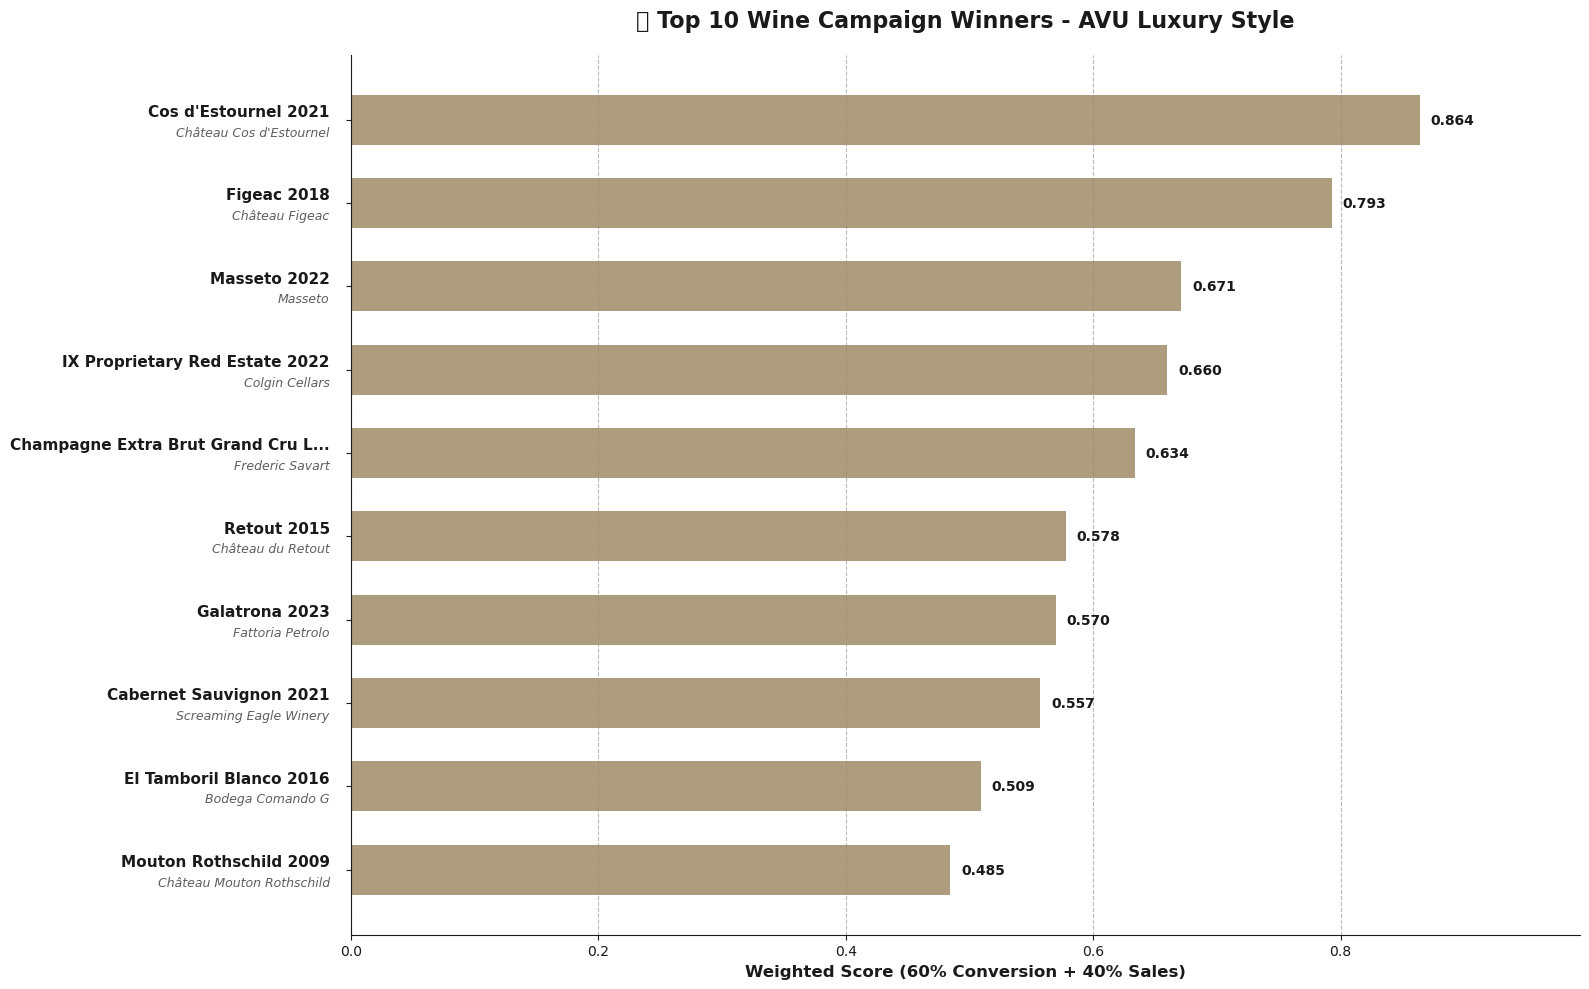


📈 CHART SUMMARY:
🏆 #1 Winner: Cos d'Estournel
📊 Score: 0.8638
💰 Price: CHF 98
📈 Conversion: 5.90%
💵 Sales: CHF 292'386.04

🎯 Top 10 Statistics:
   • Average Score: 0.6320
   • Price Range: CHF 12 - CHF 2500
   • Total Sales: CHF 1'498'468.69

✅ AVU luxury-styled race chart complete!
🎨 Chart uses AVU brand colors: Gold bars, dark text, clean styling


In [10]:
# 5 📊 SIMPLE RACE CHART
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

# AVU Brand Colors
AVU_GOLD = '#A08B69'        # Primary gold
DARK_CONTRAST = '#1A1A1A'   # Text color
BACKGROUND_WHITE = '#FFFFFF' # Background

print("📊 SIMPLE RACE CHART VISUALIZATION")
print("="*45)
print(f"📅 Date: {datetime.now().strftime('%B %d, %Y at %H:%M:%S')}")

try:
    # Get top 10 winners
    top_10 = top_25_winners.head(10).copy()
    print(f"✅ Creating chart for top {len(top_10)} winners")
    
    # Prepare data with separate wine names and producer names
    wine_labels = []
    producer_labels = []
    scores = []
    
    for _, row in top_10.iterrows():
        wine_name = str(row['Wine'])
        vintage = str(row['Vintage']) if pd.notna(row['Vintage']) and str(row['Vintage']) != '0' else ''
        producer_name = str(row['Producer_Name']) if pd.notna(row['Producer_Name']) and str(row['Producer_Name']).lower() != 'nan' else ''
        
        # Create wine display name with vintage
        if vintage:
            wine_display = f"{wine_name} {vintage}"
        else:
            wine_display = wine_name
            
        # Truncate wine name if too long
        if len(wine_display) > 35:
            wine_display = wine_display[:32] + "..."
            
        # Truncate producer name if too long
        if producer_name and len(producer_name) > 30:
            producer_name = producer_name[:27] + "..."
            
        wine_labels.append(wine_display)
        producer_labels.append(producer_name)
        scores.append(float(row['Weighted_Score']))
    
    # Reverse for horizontal chart (highest at top)
    wine_labels.reverse()
    producer_labels.reverse()
    scores.reverse()
    
    # Create figure with extra height for two-line labels
    fig, ax = plt.subplots(figsize=(16, 10))
    fig.patch.set_facecolor(BACKGROUND_WHITE)
    ax.set_facecolor(BACKGROUND_WHITE)
    
    # Create horizontal bars
    y_positions = np.arange(len(wine_labels))
    bars = ax.barh(y_positions, scores, color=AVU_GOLD, alpha=0.85, height=0.6)
    
    # Remove default y-tick labels and create custom two-line labels
    ax.set_yticks(y_positions)
    ax.set_yticklabels([])  # Clear default labels
    
    # Add custom two-line labels
    for i, (wine, producer) in enumerate(zip(wine_labels, producer_labels)):
        y_pos = y_positions[i]
        
        # Wine name (main label)
        ax.text(-max(scores) * 0.02, y_pos + 0.1, wine, 
                ha='right', va='center', fontsize=11, fontweight='bold', color=DARK_CONTRAST)
        
        # Producer name (centered, smaller, lighter)
        if producer:
            ax.text(-max(scores) * 0.02, y_pos - 0.15, producer, 
                    ha='right', va='center', fontsize=9, fontweight='normal', 
                    color=DARK_CONTRAST, alpha=0.7, style='italic')
    ax.set_xlabel('Weighted Score (60% Conversion + 40% Sales)', fontsize=12, color=DARK_CONTRAST, fontweight='bold')
    ax.set_title('🏆 Top 10 Wine Campaign Winners - AVU Luxury Style', 
                 fontsize=16, fontweight='bold', color=DARK_CONTRAST, pad=20)
    
    # Add score labels on bars
    max_score = max(scores) if scores else 1
    for i, (bar, score) in enumerate(zip(bars, scores)):
        width = bar.get_width()
        ax.text(width + max_score * 0.01, bar.get_y() + bar.get_height()/2, 
                f'{score:.3f}', ha='left', va='center', 
                fontsize=10, fontweight='bold', color=DARK_CONTRAST)
    
    # Style the chart
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_color(DARK_CONTRAST)
    ax.spines['bottom'].set_color(DARK_CONTRAST)
    ax.tick_params(colors=DARK_CONTRAST)
    
    # Add subtle grid
    ax.grid(axis='x', alpha=0.3, linestyle='--', color=DARK_CONTRAST)
    ax.set_axisbelow(True)
    
    # Set limits
    ax.set_xlim(0, max_score * 1.15)
    
    plt.tight_layout()
    plt.show()
    
    # Summary
    print("\n📈 CHART SUMMARY:")
    print("="*30)
    print(f"🏆 #1 Winner: {top_10.iloc[0]['Wine']}")
    print(f"📊 Score: {top_10.iloc[0]['Weighted_Score']:.4f}")
    print(f"💰 Price: CHF {top_10.iloc[0]['Main_Bottle_Price_LCY']:.0f}")
    print(f"📈 Conversion: {top_10.iloc[0]['Conversion_Rate_%']:.2f}%")
    print(f"💵 Sales: CHF {format_swiss_number(top_10.iloc[0]['Total_Sales_Amount_LCY'])}")
    
    print(f"\n🎯 Top 10 Statistics:")
    print(f"   • Average Score: {top_10['Weighted_Score'].mean():.4f}")
    print(f"   • Price Range: CHF {top_10['Main_Bottle_Price_LCY'].min():.0f} - CHF {top_10['Main_Bottle_Price_LCY'].max():.0f}")
    print(f"   • Total Sales: CHF {format_swiss_number(top_10['Total_Sales_Amount_LCY'].sum())}")

except Exception as e:
    print(f"❌ Error creating chart: {e}")
    print("📝 Make sure previous cells have been executed successfully")

print(f"\n✅ AVU luxury-styled race chart complete!")
print("🎨 Chart uses AVU brand colors: Gold bars, dark text, clean styling")

In [ ]:
# 5.5 🎬 ANIMATED RACE CHART GIF GENERATORimport matplotlib.pyplot as pltimport matplotlib.animation as animationfrom PIL import Imageimport jsonimport numpy as npfrom datetime import datetimeimport base64from io import BytesIOprint("🎬 ANIMATED RACE CHART GIF GENERATOR")print("="*50)print(f"📅 Generation Date: {datetime.now().strftime('%B %d, %Y at %H:%M:%S')}")# ConfigurationGOLD_COLOR = '#D4AF37'  # Gold color for barsDARK_CONTRAST = '#1A1A1A'  # Text colorBACKGROUND_WHITE = '#FFFFFF'  # Backgrounddashboard_dir = r"C:\Users\Marco.Africani\OneDrive - AVU SA\AVU CPI Campaign\Puzzle_control_Reports\IRON_DATA\dashboard"race_data_file = r"C:\Users\Marco.Africani\OneDrive - AVU SA\AVU CPI Campaign\Puzzle_control_Reports\IRON_DATA\historical\race_chart_data.json"try:    # Load race chart data    print("📂 Loading race chart data...")    with open(race_data_file, 'r', encoding='utf-8') as f:        race_data = json.load(f)    time_series = race_data['time_series']    print(f"✅ Loaded {len(time_series)} snapshots")    # Filter to get specific dates: Oct 10-16, 2025    target_dates = ['2025-10-10', '2025-10-11', '2025-10-12', '2025-10-13',                    '2025-10-14', '2025-10-15', '2025-10-16']    # Get snapshots for target dates (use last snapshot per day)    date_snapshots = {}    for snapshot in time_series:        date = snapshot['date']        if date in target_dates:            # Keep the last snapshot for each date            date_snapshots[date] = snapshot    # Sort by date    sorted_dates = sorted(date_snapshots.keys())    snapshots_to_animate = [date_snapshots[d] for d in sorted_dates]    print(f"📊 Creating animation for {len(snapshots_to_animate)} dates")    print(f"📅 Date range: {sorted_dates[0]} to {sorted_dates[-1]}")    # Create frames    frames = []    fig, ax = plt.subplots(figsize=(16, 10))    for idx, snapshot in enumerate(snapshots_to_animate):        print(f"  🎨 Generating frame {idx + 1}/{len(snapshots_to_animate)}: {snapshot['date']}")        # Clear the axis        ax.clear()        # Get top 10 winners for this snapshot        top_10 = snapshot['winners'][:10]        # Prepare data        campaign_names = []        scores = []        for winner in top_10:            # Create campaign display name (name only, no campaign number)            name = winner['name']            if len(name) > 40:                name = name[:37] + "..."            campaign_names.append(name)            scores.append(winner['value'])        # Reverse for horizontal chart (highest at top)        campaign_names.reverse()        scores.reverse()        # Set figure background        fig.patch.set_facecolor(BACKGROUND_WHITE)        ax.set_facecolor(BACKGROUND_WHITE)        # Create horizontal bars        y_positions = np.arange(len(campaign_names))        bars = ax.barh(y_positions, scores, color=GOLD_COLOR, alpha=0.9, height=0.7)        # Set y-axis labels        ax.set_yticks(y_positions)        ax.set_yticklabels(campaign_names, fontsize=11, fontweight='bold', color=DARK_CONTRAST)        # Add title with date        date_display = snapshot['analysis_date']        ax.set_title(f'🏁 OVERALL WINNERS RACE CHART\n{date_display}',                     fontsize=18, fontweight='bold', color=DARK_CONTRAST, pad=20)        ax.set_xlabel('Weighted Score (60% Conversion + 40% Sales)',                      fontsize=12, color=DARK_CONTRAST, fontweight='bold')        # Add score labels on bars        max_score = max(scores) if scores else 1        for i, (bar, score) in enumerate(zip(bars, scores)):            width = bar.get_width()            ax.text(width + max_score * 0.01, bar.get_y() + bar.get_height()/2,                    f'{score:.4f}', ha='left', va='center',                    fontsize=10, fontweight='bold', color=DARK_CONTRAST)        # Style the chart        ax.spines['right'].set_visible(False)        ax.spines['top'].set_visible(False)        ax.spines['left'].set_color(DARK_CONTRAST)        ax.spines['bottom'].set_color(DARK_CONTRAST)        ax.tick_params(colors=DARK_CONTRAST)        # Add subtle grid        ax.grid(axis='x', alpha=0.3, linestyle='--', color=DARK_CONTRAST)        ax.set_axisbelow(True)        # Set consistent x-axis limits for smooth animation        ax.set_xlim(0, 1.0)  # Adjust based on your score range        plt.tight_layout()        # Save frame to memory        buf = BytesIO()        plt.savefig(buf, format='png', dpi=100, facecolor=BACKGROUND_WHITE)        buf.seek(0)        frame = Image.open(buf)        frames.append(frame.copy())        buf.close()    plt.close(fig)    # Save animated GIF    gif_path = f"{dashboard_dir}/race_chart_animated.gif"    print(f"\n💾 Saving animated GIF...")    frames[0].save(        gif_path,        save_all=True,        append_images=frames[1:],        duration=1000,  # 1 second per frame        loop=0  # Loop forever    )    print(f"✅ GIF saved: {gif_path}")    # Get file size    import os    file_size = os.path.getsize(gif_path) / 1024 / 1024  # MB    print(f"📦 File size: {file_size:.2f} MB")    # Generate base64 for HTML embedding    print(f"\n🔄 Generating base64 encoding for HTML...")    with open(gif_path, 'rb') as f:        gif_base64 = base64.b64encode(f.read()).decode('utf-8')    # Save base64 to a variable for use in next cell    race_chart_gif_base64 = gif_base64    print(f"✅ Base64 encoding complete ({len(gif_base64)} characters)")    # Summary    print(f"\n📈 GIF SUMMARY:")    print("="*30)    print(f"🎬 Total Frames: {len(frames)}")    print(f"📅 Date Range: {sorted_dates[0]} to {sorted_dates[-1]}")    print(f"⏱️ Duration per Frame: 1000ms (1 second)")    print(f"🔄 Total Animation Time: {len(frames)} seconds")    print(f"🎨 Color Scheme: Gold bars ({GOLD_COLOR})")    print(f"📊 Winners per Frame: 10")    print(f"💾 File Location: {gif_path}")    print(f"📦 File Size: {file_size:.2f} MB")    print(f"\n✅ ANIMATED GIF GENERATION COMPLETE!")    print("🎬 Ready to embed in HTML dashboard (Cell 5)")except FileNotFoundError as e:    print(f"❌ Error: File not found - {e}")    print("📝 Make sure the race_chart_data.json file exists")except Exception as e:    print(f"❌ Error creating animated GIF: {e}")    import traceback    traceback.print_exc()

In [ ]:
# 5.5 🎬 ANIMATED RACE CHART GIF GENERATOR
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from PIL import Image
import json
import numpy as np
from datetime import datetime
import base64
from io import BytesIO

print("🎬 ANIMATED RACE CHART GIF GENERATOR")
print("="*50)
print(f"📅 Generation Date: {datetime.now().strftime('%B %d, %Y at %H:%M:%S')}")

# Configuration
GOLD_COLOR = '#D4AF37'  # Gold color for bars
DARK_CONTRAST = '#1A1A1A'  # Text color
BACKGROUND_WHITE = '#FFFFFF'  # Background
dashboard_dir = r"C:\Users\Marco.Africani\OneDrive - AVU SA\AVU CPI Campaign\Puzzle_control_Reports\IRON_DATA\dashboard"
race_data_file = r"C:\Users\Marco.Africani\OneDrive - AVU SA\AVU CPI Campaign\Puzzle_control_Reports\IRON_DATA\historical\race_chart_data.json"

try:
    # Load race chart data
    print("📂 Loading race chart data...")
    with open(race_data_file, 'r', encoding='utf-8') as f:
        race_data = json.load(f)

    time_series = race_data['time_series']
    print(f"✅ Loaded {len(time_series)} snapshots")

    # Filter to get specific dates: Oct 10-16, 2025
    target_dates = ['2025-10-10', '2025-10-11', '2025-10-12', '2025-10-13',
                    '2025-10-14', '2025-10-15', '2025-10-16']

    # Get snapshots for target dates (use last snapshot per day)
    date_snapshots = {}
    for snapshot in time_series:
        date = snapshot['date']
        if date in target_dates:
            # Keep the last snapshot for each date
            date_snapshots[date] = snapshot

    # Sort by date
    sorted_dates = sorted(date_snapshots.keys())
    snapshots_to_animate = [date_snapshots[d] for d in sorted_dates]

    print(f"📊 Creating animation for {len(snapshots_to_animate)} dates")
    print(f"📅 Date range: {sorted_dates[0]} to {sorted_dates[-1]}")

    # Create frames
    frames = []
    fig, ax = plt.subplots(figsize=(16, 10))

    for idx, snapshot in enumerate(snapshots_to_animate):
        print(f"  🎨 Generating frame {idx + 1}/{len(snapshots_to_animate)}: {snapshot['date']}")

        # Clear the axis
        ax.clear()

        # Get top 10 winners for this snapshot
        top_10 = snapshot['winners'][:10]

        # Prepare data
        campaign_names = []
        scores = []

        for winner in top_10:
            # Create campaign display name (name only, no campaign number)
            name = winner['name']
            if len(name) > 40:
                name = name[:37] + "..."
            campaign_names.append(name)
            scores.append(winner['value'])

        # Reverse for horizontal chart (highest at top)
        campaign_names.reverse()
        scores.reverse()

        # Set figure background
        fig.patch.set_facecolor(BACKGROUND_WHITE)
        ax.set_facecolor(BACKGROUND_WHITE)

        # Create horizontal bars
        y_positions = np.arange(len(campaign_names))
        bars = ax.barh(y_positions, scores, color=GOLD_COLOR, alpha=0.9, height=0.7)

        # Set y-axis labels
        ax.set_yticks(y_positions)
        ax.set_yticklabels(campaign_names, fontsize=11, fontweight='bold', color=DARK_CONTRAST)

        # Add title with date
        date_display = snapshot['analysis_date']
        ax.set_title(f'🏁 OVERALL WINNERS RACE CHART\n{date_display}',
                     fontsize=18, fontweight='bold', color=DARK_CONTRAST, pad=20)

        ax.set_xlabel('Weighted Score (60% Conversion + 40% Sales)',
                      fontsize=12, color=DARK_CONTRAST, fontweight='bold')

        # Add score labels on bars
        max_score = max(scores) if scores else 1
        for i, (bar, score) in enumerate(zip(bars, scores)):
            width = bar.get_width()
            ax.text(width + max_score * 0.01, bar.get_y() + bar.get_height()/2,
                    f'{score:.4f}', ha='left', va='center',
                    fontsize=10, fontweight='bold', color=DARK_CONTRAST)

        # Style the chart
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_color(DARK_CONTRAST)
        ax.spines['bottom'].set_color(DARK_CONTRAST)
        ax.tick_params(colors=DARK_CONTRAST)

        # Add subtle grid
        ax.grid(axis='x', alpha=0.3, linestyle='--', color=DARK_CONTRAST)
        ax.set_axisbelow(True)

        # Set consistent x-axis limits for smooth animation
        ax.set_xlim(0, 1.0)  # Adjust based on your score range

        plt.tight_layout()

        # Save frame to memory
        buf = BytesIO()
        plt.savefig(buf, format='png', dpi=100, facecolor=BACKGROUND_WHITE)
        buf.seek(0)
        frame = Image.open(buf)
        frames.append(frame.copy())
        buf.close()

    plt.close(fig)

    # Save animated GIF
    gif_path = f"{dashboard_dir}/race_chart_animated.gif"
    print(f"\n💾 Saving animated GIF...")
    frames[0].save(
        gif_path,
        save_all=True,
        append_images=frames[1:],
        duration=1000,  # 1 second per frame
        loop=0  # Loop forever
    )

    print(f"✅ GIF saved: {gif_path}")

    # Get file size
    import os
    file_size = os.path.getsize(gif_path) / 1024 / 1024  # MB
    print(f"📦 File size: {file_size:.2f} MB")

    # Generate base64 for HTML embedding
    print(f"\n🔄 Generating base64 encoding for HTML...")
    with open(gif_path, 'rb') as f:
        gif_base64 = base64.b64encode(f.read()).decode('utf-8')

    # Save base64 to a variable for use in next cell
    race_chart_gif_base64 = gif_base64
    print(f"✅ Base64 encoding complete ({len(gif_base64)} characters)")

    # Summary
    print(f"\n📈 GIF SUMMARY:")
    print("="*30)
    print(f"🎬 Total Frames: {len(frames)}")
    print(f"📅 Date Range: {sorted_dates[0]} to {sorted_dates[-1]}")
    print(f"⏱️ Duration per Frame: 1000ms (1 second)")
    print(f"🔄 Total Animation Time: {len(frames)} seconds")
    print(f"🎨 Color Scheme: Gold bars ({GOLD_COLOR})")
    print(f"📊 Winners per Frame: 10")
    print(f"💾 File Location: {gif_path}")
    print(f"📦 File Size: {file_size:.2f} MB")

    print(f"\n✅ ANIMATED GIF GENERATION COMPLETE!")
    print("🎬 Ready to embed in HTML dashboard (Cell 5)")

except FileNotFoundError as e:
    print(f"❌ Error: File not found - {e}")
    print("📝 Make sure the race_chart_data.json file exists")
except Exception as e:
    print(f"❌ Error creating animated GIF: {e}")
    import traceback
    traceback.print_exc()


In [11]:
# ===== CELL 0 =====# 1 📂 SNAPSHOT IMPORT - Campaign Statistics & Stock Dataimport pandas as pdimport numpy as npfrom pathlib import Pathfrom datetime import datetime# 📁 Snapshot Directorysnap_dir = Path(r"C:\Users\Marco.Africani\OneDrive - AVU SA\AVU CPI Campaign\Puzzle_control_Reports\IRON_DATA\snapshots")print(f"📁 SNAP dir: {snap_dir}")# 🧊 Import Campaign Statistics Snapshotcampaign_stats_path = snap_dir / "campaign_statistics.pkl"campaign_stats_raw = pd.read_pickle(campaign_stats_path)print(f"🧊 Snapshot rebuilt: campaign_statistics.pkl  ({campaign_stats_raw.shape[0]}×{campaign_stats_raw.shape[1]})")# ❌ APPLY GLOBAL FILTERS - Exclude Type=HORECA/TRADE and Sub-Type=Leadprint(f"📊 Total campaigns loaded: {len(campaign_stats_raw)}")campaign_stats = campaign_stats_raw[    (~campaign_stats_raw['type'].isin(['HORECA', 'TRADE'])) &    (campaign_stats_raw['sub-type'] != 'Lead')].copy()print(f"❌ Filtered out: Type=HORECA/TRADE, Sub-Type=Lead")print(f"📊 Campaigns after filtering: {len(campaign_stats)} (removed {len(campaign_stats_raw) - len(campaign_stats)})")# 🧊 Import Detailed Stock List Snapshot  stock_path = snap_dir / "detailed_stock_list.pkl"stock_data = pd.read_pickle(stock_path)print(f"🧊 Snapshot rebuilt: detailed_stock_list.pkl  ({stock_data.shape[0]}×{stock_data.shape[1]})")print(f"\n✅ Snapshots loaded successfully")print(f"📊 Analysis ready: {datetime.now().strftime('%B %d, %Y at %H:%M:%S')}")print(f"🎯 All subsequent analyses will use filtered campaign data (excluding Horeca/Trade/Lead)")# 🎨 Stock Level Legend (refined ranges)print("\n🎨 COLOR LEGEND:")print("🟣 Purple: 1-12")print("🟨 Gold: 13-49")print("🟦 Blue: 50-199")print("🩷 Pink: 200-499")print("🟢 Green: 500+")print("⚪ White: Unknown/No price\n")# ===== CELL 1 =====# 2 🎨 COLOR-CODED TOP 25 WINNERS BY WINE PRICEfrom IPython.display import displayfrom datetime import datetimedef format_swiss_number(number):    """Format numbers in Swiss style with apostrophes (82'723.98)"""    if pd.isna(number) or number == 0:        return "0.00"        # Round to 2 decimal places    number = round(float(number), 2)        # Split into integer and decimal parts    integer_part = int(abs(number))    decimal_part = f"{abs(number) - integer_part:.2f}"[2:]  # Get decimal part (2 digits)        # Format integer part with apostrophes    formatted_int = f"{integer_part:,}".replace(",", "'")    result = f"{formatted_int}.{decimal_part}"        return f"-{result}" if number < 0 else resultprint("💰 TOP SELLING WINE CAMPAIGNS - OVERALL RANKINGS")print("="*60)print(f"📊 Analysis Date: {datetime.now().strftime('%B %d, %Y at %H:%M:%S')}")print("🏆 Winner Calculation: 60% Conversion Rate + 40% Total Sales Amount")print("✅ Using filtered data: HORECA/TRADE/Lead campaigns excluded (applied in Cell 1)")print("📊 Normalization: Norm_Conversion = conversion_rate/max_conversion | Norm_Sales = total_sales/max_sales")print("💰 Swiss Formatting: Total Sales with apostrophes (82'723.98)")print("🎯 Focus: Top selling wine campaigns ranked by weighted score\n")# ---- Use Pre-Filtered Campaign Statistics ----campaigns_filtered = campaign_stats.copy()  # Already filtered in Cell 1print(f"📊 Filtered campaigns available: {len(campaigns_filtered)}")# ---- Extract key columns for winner calculation ----# Column references based on the actual data structureconversion_rate = pd.to_numeric(campaigns_filtered['conversion rate %'], errors='coerce').fillna(0)total_sales = pd.to_numeric(campaigns_filtered['total sales amount (lcy)'], errors='coerce').fillna(0)# Other display columnswine_name = campaigns_filtered['main wine name'].fillna('Unknown')campaign_no = campaigns_filtered['campaign no.'].fillna('')vintage_code = campaigns_filtered['vintage code'].fillna('')scheduled_datetime = campaigns_filtered['scheduled datetime1'].fillna('')  # Using scheduled datetime1multiple_wines = campaigns_filtered['multiple wines'].fillna('')email_sent = pd.to_numeric(campaigns_filtered['email sent'], errors='coerce').fillna(0)main_bottle_price = pd.to_numeric(campaigns_filtered['main bottle price (lcy)'], errors='coerce').fillna(0)delayed_sending = campaigns_filtered['delayed sending'].fillna(False)unique_customers_bought = pd.to_numeric(campaigns_filtered['total unique customers bought'], errors='coerce').fillna(0)# ---- Calculate Winner Score (60% conversion + 40% sales) ----# Normalize conversion rate and sales for scoringmax_conversion = max(conversion_rate.max(), 1e-12)  # Avoid division by zeromax_sales = max(total_sales.max(), 1e-12)print(f"📊 Normalization factors: Max Conversion = {max_conversion:.2f}% | Max Sales = CHF {format_swiss_number(max_sales)}")# Calculate normalized scoresnorm_conversion = conversion_rate / max_conversion  # Each campaign's conversion / best conversionnorm_sales = total_sales / max_sales  # Each campaign's sales / best sales# Final weighted score: 60% conversion + 40% salesweighted_score = 0.6 * norm_conversion + 0.4 * norm_sales# ---- Build Winners DataFrame ----winners_df = pd.DataFrame({    'Campaign_No': campaign_no,    'Wine': wine_name,  # Renamed from Main_Wine_Name to Wine    'Vintage': vintage_code,  # Renamed from Vintage_Code to Vintage    'Starting_Date': scheduled_datetime,    'Multiple': multiple_wines,    'Email_Sent': email_sent,    'Conversion_Rate_%': conversion_rate,    'Total_Sales_Amount_LCY': total_sales,    'Unique_Bought': unique_customers_bought,    'Norm_Conversion': norm_conversion,    'Norm_Sales': norm_sales,    'Weighted_Score': weighted_score,    'Main_Bottle_Price_LCY': main_bottle_price,    'Delayed_Sending': delayed_sending})# Sort by weighted score (descending) and add overall positionwinners_df = winners_df.sort_values('Weighted_Score', ascending=False).reset_index(drop=True)winners_df['Overall_Position'] = range(1, len(winners_df) + 1)  # Add overall ranking# Add Main Item No for Producer Name mappingwinners_df = winners_df.merge(    campaigns_filtered[['campaign no.', 'main item no.']],    left_on='Campaign_No',    right_on='campaign no.',    how='left')# Add Producer Name using Main Item No mappingproducer_mapping = pd.DataFrame({    'Main_Item_No': pd.to_numeric(campaign_stats['main item no.'], errors='coerce').fillna(0).astype(int),    'Producer_Name': campaign_stats['producer name']}).drop_duplicates(subset=['Main_Item_No'])# Convert main item no. to integer for matchingwinners_df['Main_Item_No'] = pd.to_numeric(winners_df['main item no.'], errors='coerce').fillna(0).astype(int)# Merge Producer Namewinners_df = winners_df.merge(    producer_mapping,    on='Main_Item_No',    how='left')top_25_winners = winners_df.head(25).copy()# ---- Price Category Color Coding ----def get_price_emoji(price):    """Return emoji based on updated price tier ranges"""    if pd.isna(price) or price <= 0: return "⚪"  # Unknown/No price    if price >= 750.01: return "🟣"  # Purple: Extra luxury wines (CHF 750.01+)    if price >= 300.01: return "🟨"  # Gold: Luxury wines (CHF 300.01-750.00)    if price >= 100.01: return "💎"  # Blue: Premium wines (CHF 100.01-300.00)    if price >= 50.01:  return "🩷"  # Pink: Mid-range wines (CHF 50.01-100.00)    return "🟢"  # Green: Budget wines (MAX CHF 50)# Add color coding and rank (on the right)top_25_winners['🎨'] = top_25_winners['Main_Bottle_Price_LCY'].apply(get_price_emoji)top_25_winners['Rank'] = range(1, len(top_25_winners) + 1)# ---- Display Results ----print("🎨 PRICE TIER COLOR LEGEND:")print("🟣 Purple: Extra luxury wines (CHF 750.01+)")print("🟨 Gold: Luxury wines (CHF 300.01–750.00)")print("💎 Diamond: Premium wines (CHF 100.01–300.00)")print("🩷 Pink: Mid-range wines (CHF 50.01–100.00)")print("🟢 Green: Budget wines (≤ CHF 50.00)")print("⚪ White: Unknown/No price\n")# Prepare display table with requested columns order (Producer_Name added after Vintage)display_table = top_25_winners[['Overall_Position', 'Campaign_No', '🎨', 'Wine', 'Vintage', 'Producer_Name', 'Starting_Date',                               'Multiple', 'Email_Sent', 'Unique_Bought', 'Conversion_Rate_%', 'Total_Sales_Amount_LCY',                               'Norm_Conversion', 'Norm_Sales', 'Weighted_Score', 'Delayed_Sending']].copy()# Format wine names for better displaydisplay_table['Wine'] = display_table['Wine'].astype(str).apply(    lambda x: x if len(x) <= 25 else x[:25] + "…")# Format vintage to show just the year number (remove .0)display_table['Vintage'] = pd.to_numeric(display_table['Vintage'], errors='coerce').fillna(0).astype(int).astype(str).replace('0', '')# Format starting date for better display (remove time, show only date)display_table['Starting_Date'] = pd.to_datetime(display_table['Starting_Date'], errors='coerce').dt.strftime('%Y-%m-%d').fillna('')# Add "-D" suffix to Campaign_No if Delayed_Sending is Truedisplay_table['Campaign_No'] = display_table.apply(    lambda row: f"{row['Campaign_No']}-D" if row['Delayed_Sending'] == True else str(row['Campaign_No']),     axis=1)# Create a formatted version for display while keeping the original numeric columndisplay_table['Total_Sales_Formatted'] = display_table['Total_Sales_Amount_LCY'].apply(format_swiss_number)# Round numeric columns for better displaydisplay_table['Norm_Conversion'] = display_table['Norm_Conversion'].round(4)display_table['Norm_Sales'] = display_table['Norm_Sales'].round(4)display_table['Weighted_Score'] = display_table['Weighted_Score'].round(4)# Reorder columns to show formatted sales instead of raw numbers (Producer_Name after Vintage)display_cols = ['Overall_Position', 'Campaign_No', '🎨', 'Wine', 'Vintage', 'Producer_Name', 'Starting_Date',               'Multiple', 'Email_Sent', 'Unique_Bought', 'Conversion_Rate_%', 'Total_Sales_Formatted',               'Norm_Conversion', 'Norm_Sales', 'Weighted_Score']# Remove Delayed_Sending column from display (used only for formatting)display_table = display_table.drop('Delayed_Sending', axis=1)print("🏆 TOP 25 WINE CAMPAIGN WINNERS:")display(display_table[display_cols])# ---- Summary Statistics ----print("\n📊 WINNER ANALYSIS SUMMARY:")print(f"• #1 Winner: {top_25_winners.iloc[0]['Wine']} | Weighted Score: {top_25_winners.iloc[0]['Weighted_Score']:.4f}")print(f"• Price Range: CHF {top_25_winners['Main_Bottle_Price_LCY'].min():.0f} - CHF {top_25_winners['Main_Bottle_Price_LCY'].max():.0f}")print(f"• Avg Conversion Rate: {top_25_winners['Conversion_Rate_%'].mean():.2f}%")print(f"• Total Sales (Top 25): CHF {format_swiss_number(top_25_winners['Total_Sales_Amount_LCY'].sum())}")print(f"• Total Emails Sent: {top_25_winners['Email_Sent'].sum():,.0f}")print(f"• Total Unique Customers: {top_25_winners['Unique_Bought'].sum():,.0f}")print(f"• Avg Normalized Conversion: {top_25_winners['Norm_Conversion'].mean():.4f}")print(f"• Avg Normalized Sales: {top_25_winners['Norm_Sales'].mean():.4f}")print(f"• Delayed Campaigns: {(top_25_winners['Delayed_Sending'] == True).sum()}/{len(top_25_winners)}")# Price category distributionprint(f"\n🎨 PRICE CATEGORY DISTRIBUTION:")price_categories = top_25_winners['🎨'].value_counts()price_meanings = {    "🟣": "Extra luxury (CHF 750.01+)",    "🟨": "Luxury (CHF 300.01–750.00)",    "💎": "Premium (CHF 100.01–300.00)",    "🩷": "Mid-range (CHF 50.01–100.00)",    "🟢": "Budget (≤ CHF 50.00)",    "⚪": "Unknown/No price"}for emoji, count in price_categories.items():    meaning = price_meanings.get(emoji, "Unknown")    pct = 100 * count / len(top_25_winners)    print(f"   {emoji} {meaning}: {count} campaigns ({pct:.1f}%)")# ===== CELL 2 =====# 3 📅 MULTI-PERIOD WINNERS ANALYSIS WITH STOCK AVAILABILITYfrom IPython.display import displayfrom datetime import datetime, timedeltaprint("📅 MULTI-PERIOD WINNERS ANALYSIS WITH STOCK AVAILABILITY")print("="*65)print(f"📊 Analysis Date: {datetime.now().strftime('%B %d, %Y at %H:%M:%S')}")print("🎯 Period Analysis: Last 7, 14, 21, and 30 days")print("📦 Stock Status: Based on Detailed Stock List (Column B)")print("🏆 Winner Logic: 60% Conversion + 40% Sales (filtered by period)\n")# ---- Stock Processing ----print("📦 Processing Stock Data...")stock_clean = stock_data.copy()# Extract item ID from 'id' column and stock quantity from 'stock' columnstock_mapping = pd.DataFrame({    'item_id': pd.to_numeric(stock_clean['id'], errors='coerce').fillna(0).astype(int),  # 'id' column as integer    'stock_quantity': pd.to_numeric(stock_clean['stock'], errors='coerce').fillna(0)  # 'stock' column (quantity)}).drop_duplicates(subset=['item_id'])print(f"✅ Stock data processed: {len(stock_mapping)} unique items")print(f"📊 Stock range: {stock_mapping['stock_quantity'].min():.0f} - {stock_mapping['stock_quantity'].max():.0f} bottles")# ---- Stock Status Functions ----def get_stock_emoji(quantity):    """Return emoji based on refined stock quantity ranges"""    if pd.isna(quantity) or quantity <= 0:        return "⚪"  # White: Unknown/No stock    elif 1 <= quantity <= 12:        return "🟣"  # Purple: 1-12    elif 13 <= quantity <= 49:        return "🟨"  # Gold: 13-49    elif 50 <= quantity <= 199:        return "🟦"  # Blue: 50-199    elif 200 <= quantity <= 499:        return "🩷"  # Pink: 200-499    elif quantity >= 500:        return "🟢"  # Green: 500+    else:        return "⚪"  # Default: Unknowndef get_stock_status(quantity):    """Return stock status description based on refined ranges"""    if pd.isna(quantity) or quantity <= 0:        return "Unknown/No stock"    elif 1 <= quantity <= 12:        return f"Purple ({int(quantity)} bottles)"    elif 13 <= quantity <= 49:        return f"Gold ({int(quantity)} bottles)"    elif 50 <= quantity <= 199:        return f"Blue ({int(quantity)} bottles)"    elif 200 <= quantity <= 499:        return f"Pink ({int(quantity)} bottles)"    elif quantity >= 500:        return f"Green ({int(quantity)} bottles)"    else:        return f"Other ({int(quantity)} bottles)"# ---- Price Category Functions (match Cell 2 ranges) ----def get_price_emoji(price):    """Return emoji based on updated price tier ranges"""    if pd.isna(price) or price <= 0: return "⚪"  # Unknown/No price    if price >= 750.01: return "🟣"  # Purple: Extra luxury wines (CHF 750.01+)    if price >= 300.01: return "🟨"  # Gold: Luxury wines (CHF 300.01-750.00)    if price >= 100.01: return "💎"  # Blue: Premium wines (CHF 100.01-300.00)    if price >= 50.01:  return "🩷"  # Pink: Mid-range wines (CHF 50.01-100.00)    return "🟢"  # Green: Budget wines (MAX CHF 50)# ---- Period Analysis ----current_date = datetime.now()periods = [    (7, "Last 7 Days", "🗓️"),    (14, "Last 14 Days", "📅"),     (21, "Last 21 Days", "📆"),    (30, "Last 30 Days", "🗓️")]print("📦 STOCK STATUS LEGEND (using refined ranges from Cell 1):")print("🎨 UPDATED PRICE TIER LEGEND:")print("🟣 Purple: Extra luxury wines (CHF min avg 750.01+)")print("🟨 Gold: Luxury wines (CHF min avg 300.01-max avg 750.00)")print("💎 Blue: Premium wines (CHF min avg 100.01-max avg 300.00)")print("🩷 Pink: Mid-range wines (min avg 50.01-max avg 100.00)")print("🟢 Green: Budget wines (MAX avg CHF 50)")print("⚪ White: Unknown/No price\n")# Use the complete winners data from cell 2 (all campaigns, not just top 25)winners_with_dates = winners_df.copy()# Convert Starting_Date to datetime for filteringwinners_with_dates['Starting_Date_dt'] = pd.to_datetime(winners_with_dates['Starting_Date'], errors='coerce')# Check if Main_Item_No column exists from Cell 2if 'Main_Item_No' not in winners_with_dates.columns:    print("⚠️ Main_Item_No not found in winners_df, creating mapping...")    # Add stock information by matching main item numbers    campaigns_with_items = campaigns_filtered.copy()    item_mapping = pd.DataFrame({        'Campaign_No': campaigns_with_items['campaign no.'],        'Main_Item_No': pd.to_numeric(campaigns_with_items['main item no.'], errors='coerce').fillna(0).astype(int)    })        # Merge with winners to get item numbers    winners_with_items = winners_with_dates.merge(        item_mapping,         left_on='Campaign_No',         right_on='Campaign_No',         how='left'    )else:    print("✅ Main_Item_No found in winners_df from Cell 2")    winners_with_items = winners_with_dates.copy()# Match with stock datawinners_with_stock = winners_with_items.merge(    stock_mapping,    left_on='Main_Item_No',    right_on='item_id',    how='left')# For each period, create analysisfor days, period_name, emoji in periods:    print(f"\n{emoji} {period_name.upper()} ANALYSIS")    print("-" * 50)        # Filter by date range    cutoff_date = current_date - timedelta(days=days)    period_data = winners_with_stock[        winners_with_stock['Starting_Date_dt'] >= cutoff_date    ].copy()        # Ensure we always have exactly 10 winners to display for top 10 analysis    if period_data.empty or len(period_data) < 10:        if period_data.empty:            print(f"⚠️ No campaigns found in {period_name.lower()}, using top 10 overall winners")            period_top = winners_with_stock.sort_values('Weighted_Score', ascending=False).head(10).copy()        else:            print(f"✅ Found {len(period_data)} campaigns in {period_name.lower()}, supplementing with overall winners to reach 10")            # Take available period campaigns first, then supplement with overall winners            period_campaigns = period_data.sort_values('Weighted_Score', ascending=False).copy()            remaining_needed = 10 - len(period_campaigns)                        # Get overall winners excluding the ones already in period            excluded_campaigns = period_campaigns['Campaign_No'].tolist()            overall_winners = winners_with_stock[                ~winners_with_stock['Campaign_No'].isin(excluded_campaigns)            ].sort_values('Weighted_Score', ascending=False).head(remaining_needed).copy()                        # Combine period campaigns with overall winners            period_top = pd.concat([period_campaigns, overall_winners], ignore_index=True)    else:        print(f"✅ Found {len(period_data)} campaigns in {period_name.lower()}")        # Sort by weighted score and take top 10 for each period        period_top = period_data.sort_values('Weighted_Score', ascending=False).head(10).copy()        period_top['Period_Rank'] = range(1, len(period_top) + 1)        # Add price color coding (🎨) column    period_top['🎨'] = period_top['Main_Bottle_Price_LCY'].apply(get_price_emoji)        # Add stock status    period_top['📦'] = period_top['stock_quantity'].apply(get_stock_emoji)    period_top['Stock_Status'] = period_top['stock_quantity'].apply(get_stock_status)        # Overall_Position should already be included from winners_df    # Verify it exists in the dataframe    if 'Overall_Position' not in period_top.columns:        print(f"⚠️ Warning: Overall_Position column missing, adding from winners_df")        period_top = period_top.merge(            winners_df[['Campaign_No', 'Overall_Position']],             on='Campaign_No',             how='left'        )        # Add Producer Name from campaign_stats using Main Item No. (Column Q)    producer_mapping = pd.DataFrame({        'Main_Item_No': pd.to_numeric(campaign_stats['main item no.'], errors='coerce').fillna(0).astype(int),        'Producer_Name': campaign_stats['producer name']    })        # Remove duplicates based on Main_Item_No (keep first occurrence)    producer_mapping = producer_mapping.drop_duplicates(subset=['Main_Item_No'])        # Merge using Main_Item_No to get Producer Name    period_top = period_top.merge(        producer_mapping,        on='Main_Item_No',        how='left'    )        # Backup producer lookup from detailed stock list (Column F) for missing producers    # Create backup producer mapping from stock data (Column F producer, matched by Column A ID)    if 'producer' in stock_data.columns:  # Column F in detailed stock list        backup_producer_mapping = pd.DataFrame({            'item_id': pd.to_numeric(stock_data['id'], errors='coerce').fillna(0).astype(int),  # Column A: ID            'Backup_Producer': stock_data['producer']  # Column F: Producer        }).drop_duplicates(subset=['item_id'])                # Merge backup producer info        period_top = period_top.merge(            backup_producer_mapping,            left_on='Main_Item_No',            right_on='item_id',            how='left'        )                # Fill missing Producer_Name with backup producer        if 'Producer_Name' in period_top.columns and 'Backup_Producer' in period_top.columns:            period_top['Producer_Name'] = period_top['Producer_Name'].fillna(period_top['Backup_Producer'])        elif 'Backup_Producer' in period_top.columns and 'Producer_Name' not in period_top.columns:            # If Producer_Name doesn't exist, create it from backup            period_top['Producer_Name'] = period_top['Backup_Producer']                # Clean up temporary columns        if 'Backup_Producer' in period_top.columns:            period_top = period_top.drop(['Backup_Producer'], axis=1)        if 'item_id_y' in period_top.columns:            period_top = period_top.drop(['item_id_y'], axis=1)        # Prepare display table with Stock_Status column before Main_Item_No    display_cols = [        'Period_Rank', '🎨', '📦', 'Campaign_No', 'Wine', 'Vintage', 'Producer_Name', 'Starting_Date',        'Total_Sales_Amount_LCY', 'Unique_Bought', 'Conversion_Rate_%', 'Weighted_Score', 'Stock_Status', 'Main_Item_No', 'Overall_Position'    ]        # Move Stock_Status before Main_Item_No if not already    if 'Stock_Status' in display_cols and display_cols.index('Stock_Status') > display_cols.index('Main_Item_No'):        display_cols.remove('Stock_Status')        main_item_no_index = display_cols.index('Main_Item_No')        display_cols.insert(main_item_no_index, 'Stock_Status')        period_display = period_top[[col for col in display_cols if col in period_top.columns]].copy()        # Format columns    if 'Total_Sales_Amount_LCY' in period_display.columns:        period_display['Total_Sales_Amount_LCY'] = period_display['Total_Sales_Amount_LCY'].apply(format_swiss_number)        if 'Unique_Bought' in period_display.columns:        period_display['Unique_Bought'] = pd.to_numeric(period_display['Unique_Bought'], errors='coerce').fillna(0).astype(int)        if 'Weighted_Score' in period_display.columns:        period_display['Weighted_Score'] = period_display['Weighted_Score'].round(4)        if 'Conversion_Rate_%' in period_display.columns:        period_display['Conversion_Rate_%'] = period_display['Conversion_Rate_%'].round(2)        # Format Starting_Date to show only date (no time)    if 'Starting_Date' in period_display.columns:        period_display['Starting_Date'] = pd.to_datetime(period_display['Starting_Date'], errors='coerce').dt.strftime('%Y-%m-%d').fillna('')        # Format Vintage to show only year (remove .0)    if 'Vintage' in period_display.columns:        period_display['Vintage'] = pd.to_numeric(period_display['Vintage'], errors='coerce').fillna(0).astype(int).astype(str).replace('0', '')        # Add -D suffix to Campaign_No if Delayed_Sending is True    if 'Campaign_No' in period_display.columns and 'Delayed_Sending' in period_top.columns:        period_display['Campaign_No'] = period_top.apply(            lambda row: f"{row['Campaign_No']}-D" if row['Delayed_Sending'] == True else str(row['Campaign_No']),             axis=1        )        print(f"🏆 TOP 10 SELLING CAMPAIGNS - {period_name.upper()}:")    if not period_top.empty:        display(period_display)    else:        print("   No campaigns found in this period")        # Period summary (only if we have campaigns)    if not period_top.empty:        # Use refined color system counts        purple_stock = (period_top['📦'] == '🟣').sum()  # 1-12        gold_stock = (period_top['📦'] == '🟨').sum()    # 13-49        blue_stock = (period_top['📦'] == '🟦').sum()    # 50-199        pink_stock = (period_top['📦'] == '🩷').sum()    # 200-499        green_stock = (period_top['📦'] == '🟢').sum()   # 500+        unknown_stock = (period_top['📦'] == '⚪').sum() # Unknown                print(f"\n📊 {period_name.upper()} SUMMARY:")        print(f"• Total campaigns in period: {len(period_data) if not period_data.empty else 0}")        print(f"• Top 10 campaigns displayed: {len(period_top)}")        print(f"• Average weighted score: {period_top['Weighted_Score'].mean():.4f}")        print(f"• Total sales (Top 10): CHF {format_swiss_number(period_top['Total_Sales_Amount_LCY'].sum())}")                print(f"\n📦 STOCK DISTRIBUTION (Top 10):")        if purple_stock > 0:            print(f"   🟣 Purple (1-12): {purple_stock} campaigns ({100*purple_stock/len(period_top):.1f}%)")        if gold_stock > 0:            print(f"   🟨 Gold (13-49): {gold_stock} campaigns ({100*gold_stock/len(period_top):.1f}%)")        if blue_stock > 0:            print(f"   🟦 Blue (50-199): {blue_stock} campaigns ({100*blue_stock/len(period_top):.1f}%)")        if pink_stock > 0:            print(f"   🩷 Pink (200-499): {pink_stock} campaigns ({100*pink_stock/len(period_top):.1f}%)")        if green_stock > 0:            print(f"   🟢 Green (500+): {green_stock} campaigns ({100*green_stock/len(period_top):.1f}%)")        if unknown_stock > 0:            print(f"   ⚪ Unknown: {unknown_stock} campaigns ({100*unknown_stock/len(period_top):.1f}%)")    else:        print(f"\n📊 {period_name.upper()} SUMMARY:")        print(f"• No campaigns found in this {days}-day period")print("\n🎯 MULTI-PERIOD ANALYSIS COMPLETE")print("="*40)print("📊 Use the refined stock level indicators for campaign decisions:")print("🟣 Purple (1-12): Limited stock - use cautiously")print("🟨 Gold (13-49): Low stock - monitor carefully") print("🟦 Blue (50-199): Moderate stock - good for campaigns")print("🩷 Pink (200-499): High stock - excellent for campaigns")print("🟢 Green (500+): Very high stock - ideal for large campaigns")print("⚪ Unknown: Check stock status before use")# ===== CELL 3 =====# 4 📊 HISTORICAL TOP-15 MATRIX FOR RACE CHARTSimport jsonfrom pathlib import Pathfrom datetime import datetimeprint("📊 HISTORICAL TOP-15 MATRIX FOR RACE CHARTS")print("="*50)print(f"📅 Snapshot Date: {datetime.now().strftime('%B %d, %Y at %H:%M:%S')}")# ---- Prepare Historical Data Directory ----historical_dir = Path(r"C:\Users\Marco.Africani\OneDrive - AVU SA\AVU CPI Campaign\Puzzle_control_Reports\IRON_DATA\historical")historical_dir.mkdir(exist_ok=True)print(f"📁 Historical dir: {historical_dir}")# ---- Create Current Snapshot Data ----# Use current date for each execution to track daily changesdata_date = datetime.now()current_snapshot = {    'timestamp': datetime.now().isoformat(),    'date': data_date.strftime('%Y-%m-%d'),    'analysis_date': data_date.strftime('%B %d, %Y'),    'total_campaigns': len(campaigns_filtered),    'max_conversion': max_conversion,    'max_sales': max_sales,    'top_15_winners': []}# Extract top 15 winners with key metrics for race chartstop_15_historical = top_25_winners.head(15).copy()for idx, row in top_15_historical.iterrows():    # Get price tier emoji    price = row['Main_Bottle_Price_LCY']    if pd.isna(price) or price <= 0: price_tier = "⚪"    elif price >= 1000: price_tier = "🟣"  # Extra Luxury    elif price >= 500:  price_tier = "🟨"  # Luxury    elif price >= 150:  price_tier = "🟦"  # Premium    elif price >= 80:   price_tier = "🩷"  # Mid-Range    else: price_tier = "🟢"  # Budget        winner_data = {        'rank': idx + 1,        'campaign_no': str(row['Campaign_No']),        'wine_name': str(row['Wine'])[:30],  # Truncate for chart readability        'vintage': str(row['Vintage']) if pd.notna(row['Vintage']) and str(row['Vintage']) != '0' else '',        'weighted_score': round(float(row['Weighted_Score']), 4),        'conversion_rate': round(float(row['Conversion_Rate_%']), 2),        'total_sales': round(float(row['Total_Sales_Amount_LCY']), 2),        'unique_customers': int(row['Unique_Bought']),        'email_sent': int(row['Email_Sent']),        'price_tier': price_tier,        'main_bottle_price': round(float(row['Main_Bottle_Price_LCY']), 2),        'norm_conversion': round(float(row['Norm_Conversion']), 4),        'norm_sales': round(float(row['Norm_Sales']), 4),        'delayed_sending': bool(row['Delayed_Sending']),        'display_name': f"{str(row['Wine'])[:20]} {str(row['Vintage']) if pd.notna(row['Vintage']) and str(row['Vintage']) != '0' else ''}".strip()    }    current_snapshot['top_15_winners'].append(winner_data)# ---- Load or Create Historical Matrix ----historical_file = historical_dir / "top_15_winners_matrix.json"if historical_file.exists():    with open(historical_file, 'r', encoding='utf-8') as f:        historical_data = json.load(f)    print(f"📚 Loaded existing historical data: {len(historical_data['snapshots'])} snapshots")else:    historical_data = {        'created_date': datetime.now().isoformat(),        'description': 'Historical Top-15 Wine Campaign Winners Matrix for Race Charts',        'snapshots': []    }    print("🆕 Created new historical matrix")# ---- Add Current Snapshot ----historical_data['snapshots'].append(current_snapshot)historical_data['last_updated'] = datetime.now().isoformat()# ---- Save Updated Historical Matrix ----with open(historical_file, 'w', encoding='utf-8') as f:    json.dump(historical_data, f, indent=2, ensure_ascii=False)print(f"✅ Historical matrix updated: {len(historical_data['snapshots'])} total snapshots")print(f"💾 Saved to: {historical_file}")# ---- Export Race Chart Ready Data ----race_chart_file = historical_dir / "race_chart_data.json"# Prepare race chart format (each snapshot becomes a time point)race_chart_data = {    'metadata': {        'title': 'Top Wine Campaign Winners Over Time',        'description': 'Historical ranking of wine campaigns by weighted score',        'created': historical_data['created_date'],        'last_updated': datetime.now().isoformat(),        'total_snapshots': len(historical_data['snapshots'])    },    'time_series': []}for snapshot in historical_data['snapshots']:    time_point = {        'date': snapshot['date'],        'timestamp': snapshot['timestamp'],        'analysis_date': snapshot['analysis_date'],        'winners': []    }        for winner in snapshot['top_15_winners']:        race_entry = {            'rank': winner['rank'],            'name': winner['display_name'],            'campaign_no': winner['campaign_no'],            'value': winner['weighted_score'],            'sales': winner['total_sales'],            'conversion': winner['conversion_rate'],            'customers': winner['unique_customers'],            'price_tier': winner['price_tier'],            'color': {                '🟣': '#8B5CF6',  # Purple                '🟨': '#F59E0B',  # Gold                '🟦': '#3B82F6',  # Blue                '🩷': '#EC4899',  # Pink                '🟢': '#10B981',  # Green                '⚪': '#9CA3AF'   # Gray            }.get(winner['price_tier'], '#9CA3AF')        }        time_point['winners'].append(race_entry)        race_chart_data['time_series'].append(time_point)# Save race chart datawith open(race_chart_file, 'w', encoding='utf-8') as f:    json.dump(race_chart_data, f, indent=2, ensure_ascii=False)print(f"🏁 Race chart data exported: {race_chart_file}")# ---- Display Current Snapshot Summary ----print(f"📊 CURRENT SNAPSHOT SUMMARY:")print(f"• Snapshot ID: {len(historical_data['snapshots'])}")print(f"• Date: {current_snapshot['analysis_date']}")print(f"• Total Campaigns Analyzed: {current_snapshot['total_campaigns']}")print(f"• Max Conversion Rate: {current_snapshot['max_conversion']:.2f}%")print(f"• Max Sales: CHF {format_swiss_number(current_snapshot['max_sales'])}")print(f"• Top 15 Winners Captured: {len(current_snapshot['top_15_winners'])}")# ---- Display Top 15 Winners Table ----print(f"\n🏆 TOP 15 WINNERS - CURRENT SNAPSHOT")print("="*50)# Create display table for top 15 winnerstop_15_display = top_15_historical.copy()# Merge wine name and vintage in same columntop_15_display['Wine_Vintage'] = top_15_display.apply(    lambda row: f"{str(row['Wine'])} {str(row['Vintage'])}" if pd.notna(row['Vintage']) and str(row['Vintage']) != '0' else str(row['Wine']),     axis=1)# Format wine vintage for better display (truncate if too long)top_15_display['Wine_Vintage'] = top_15_display['Wine_Vintage'].astype(str).apply(    lambda x: x if len(x) <= 35 else x[:35] + "…")# Add "-D" suffix to Campaign_No if Delayed_Sending is Truetop_15_display['Campaign_No_Display'] = top_15_display.apply(    lambda row: f"{row['Campaign_No']}-D" if row['Delayed_Sending'] == True else str(row['Campaign_No']),     axis=1)# Prepare final display columnsdisplay_cols = ['Rank', '🎨', 'Campaign_No_Display', 'Wine_Vintage', 'Conversion_Rate_%',                'Total_Sales_Amount_LCY', 'Unique_Bought', 'Weighted_Score']final_display = top_15_display[display_cols].copy()# Format columns for displayfinal_display['Total_Sales_Amount_LCY'] = final_display['Total_Sales_Amount_LCY'].apply(format_swiss_number)final_display['Conversion_Rate_%'] = final_display['Conversion_Rate_%'].round(2)final_display['Weighted_Score'] = final_display['Weighted_Score'].round(4)# Rename columns for better presentationfinal_display.columns = ['Rank', '🎨', 'Campaign_No', 'Wine & Vintage', 'Conv_%',                         'Total_Sales_CHF', 'Unique_Customers', 'Weighted_Score']display(final_display)print(f"\n🏆 TOP 5 WINNERS IN CURRENT SNAPSHOT:")for i in range(min(5, len(current_snapshot['top_15_winners']))):    winner = current_snapshot['top_15_winners'][i]    print(f"   {winner['rank']}. {winner['price_tier']} {winner['display_name']} - Score: {winner['weighted_score']}")print(f"\n📈 HISTORICAL TRACKING:")print(f"• Total Historical Snapshots: {len(historical_data['snapshots'])}")print(f"• First Snapshot: {historical_data['snapshots'][0]['analysis_date'] if historical_data['snapshots'] else 'N/A'}")print(f"• Data Range: {(datetime.fromisoformat(historical_data['snapshots'][-1]['timestamp']) - datetime.fromisoformat(historical_data['snapshots'][0]['timestamp'])).days if len(historical_data['snapshots']) > 1 else 0} days")print(f"\n🎯 RACE CHART READY:")print(f"• Time Series Points: {len(race_chart_data['time_series'])}")print(f"• Winners per Snapshot: 15")print(f"• Color-coded by Price Tier: Yes")print(f"• Export Format: JSON for visualization tools")# ---- Create Race Chart Data Table ----print(f"\n🏁 RACE CHART DATA TABLE")print("="*50)# Load historical data to build the race chart tableif historical_file.exists():    with open(historical_file, 'r', encoding='utf-8') as f:        race_historical_data = json.load(f)        # Build race chart table with campaigns as rows and dates as columns    all_campaigns = set()    date_columns = []        # Collect all unique campaigns and dates    for snapshot in race_historical_data['snapshots']:        date_columns.append(snapshot['analysis_date'])        for winner in snapshot['top_15_winners']:            campaign_key = f"{winner['campaign_no']} | {winner['display_name']}"            all_campaigns.add(campaign_key)        # Sort campaigns by their best weighted score (from most recent snapshot)    if race_historical_data['snapshots']:        latest_snapshot = race_historical_data['snapshots'][-1]        campaign_scores = {f"{w['campaign_no']} | {w['display_name']}": w['weighted_score']                           for w in latest_snapshot['top_15_winners']}        sorted_campaigns = sorted(all_campaigns,                                 key=lambda x: campaign_scores.get(x, 0),                                 reverse=True)    else:        sorted_campaigns = sorted(all_campaigns)        # Create the race chart DataFrame    race_chart_table = pd.DataFrame(index=sorted_campaigns)        # Add campaign info columns    race_chart_table['🎨'] = ''    race_chart_table['Campaign_No'] = ''    race_chart_table['Wine_Name'] = ''        # Add date columns with weighted scores    for snapshot in race_historical_data['snapshots']:        date_col = snapshot['analysis_date']                # Create a dictionary for quick lookup        score_lookup = {}        for winner in snapshot['top_15_winners']:            campaign_key = f"{winner['campaign_no']} | {winner['display_name']}"            score_lookup[campaign_key] = winner['weighted_score']                        # Fill campaign info (will be overwritten with same values, that's OK)            if campaign_key in race_chart_table.index:                race_chart_table.loc[campaign_key, '🎨'] = winner['price_tier']                race_chart_table.loc[campaign_key, 'Campaign_No'] = winner['campaign_no']                race_chart_table.loc[campaign_key, 'Wine_Name'] = winner['display_name']                # Add scores for this date        race_chart_table[date_col] = race_chart_table.index.map(            lambda x: f"{score_lookup[x]:.4f}" if x in score_lookup else "-"        )        # Display the race chart table    print(f"📊 Historical Weighted Scores by Campaign (Top 15 Winners)")    print(f"📅 Snapshots: {len(date_columns)} | Campaigns: {len(sorted_campaigns)}")    print("💡 Values show Weighted_Score (0.6*Conversion + 0.4*Sales), '-' means not in top 15")    print()        display(race_chart_table)        # Additional insights    print(f"\n📈 RACE CHART INSIGHTS:")        # Count how many times each campaign appears in top 15    appearance_count = {}    for campaign in sorted_campaigns:        count = 0        for col in date_columns:            if race_chart_table.loc[campaign, col] != "-":                count += 1        appearance_count[campaign] = count        # Most consistent performers    consistent_performers = sorted(appearance_count.items(), key=lambda x: x[1], reverse=True)[:5]    print("🏆 Most Consistent Top-15 Performers:")    for i, (campaign, count) in enumerate(consistent_performers, 1):        pct = 100 * count / len(date_columns)        print(f"   {i}. {campaign} - {count}/{len(date_columns)} snapshots ({pct:.1f}%)")        # Latest leaders    if race_historical_data['snapshots']:        latest = race_historical_data['snapshots'][-1]        print(f"\n🥇 Current Top 5 Leaders ({latest['analysis_date']}):")        for i, winner in enumerate(latest['top_15_winners'][:5], 1):            print(f"   {i}. {winner['price_tier']} {winner['display_name']} - {winner['weighted_score']:.4f}")        print(f"\n💾 Race Chart Export Files:")    print(f"   • CSV Ready: Copy table above for spreadsheet import")    print(f"   • JSON Format: {race_chart_file.name}")    print(f"   • Matrix Format: {historical_file.name}")else:    print("⚠️ No historical data found. Run this cell again after first execution.")print(f"\n✅ Historical matrix snapshot complete!")print("📁 Files created/updated:")print(f"   • {historical_file.name}")print(f"   • {race_chart_file.name}")print("🏁 Ready for race chart visualization!")# ===== CELL 4 =====# 5 📊 SIMPLE RACE CHARTimport matplotlib.pyplot as pltimport numpy as npfrom datetime import datetime# AVU Brand ColorsAVU_GOLD = '#A08B69'        # Primary goldDARK_CONTRAST = '#1A1A1A'   # Text colorBACKGROUND_WHITE = '#FFFFFF' # Backgroundprint("📊 SIMPLE RACE CHART VISUALIZATION")print("="*45)print(f"📅 Date: {datetime.now().strftime('%B %d, %Y at %H:%M:%S')}")try:    # Get top 10 winners    top_10 = top_25_winners.head(10).copy()    print(f"✅ Creating chart for top {len(top_10)} winners")        # Prepare data with separate wine names and producer names    wine_labels = []    producer_labels = []    scores = []        for _, row in top_10.iterrows():        wine_name = str(row['Wine'])        vintage = str(row['Vintage']) if pd.notna(row['Vintage']) and str(row['Vintage']) != '0' else ''        producer_name = str(row['Producer_Name']) if pd.notna(row['Producer_Name']) and str(row['Producer_Name']).lower() != 'nan' else ''                # Create wine display name with vintage        if vintage:            wine_display = f"{wine_name} {vintage}"        else:            wine_display = wine_name                    # Truncate wine name if too long        if len(wine_display) > 35:            wine_display = wine_display[:32] + "..."                    # Truncate producer name if too long        if producer_name and len(producer_name) > 30:            producer_name = producer_name[:27] + "..."                    wine_labels.append(wine_display)        producer_labels.append(producer_name)        scores.append(float(row['Weighted_Score']))        # Reverse for horizontal chart (highest at top)    wine_labels.reverse()    producer_labels.reverse()    scores.reverse()        # Create figure with extra height for two-line labels    fig, ax = plt.subplots(figsize=(16, 10))    fig.patch.set_facecolor(BACKGROUND_WHITE)    ax.set_facecolor(BACKGROUND_WHITE)        # Create horizontal bars    y_positions = np.arange(len(wine_labels))    bars = ax.barh(y_positions, scores, color=AVU_GOLD, alpha=0.85, height=0.6)        # Remove default y-tick labels and create custom two-line labels    ax.set_yticks(y_positions)    ax.set_yticklabels([])  # Clear default labels        # Add custom two-line labels    for i, (wine, producer) in enumerate(zip(wine_labels, producer_labels)):        y_pos = y_positions[i]                # Wine name (main label)        ax.text(-max(scores) * 0.02, y_pos + 0.1, wine,                 ha='right', va='center', fontsize=11, fontweight='bold', color=DARK_CONTRAST)                # Producer name (centered, smaller, lighter)        if producer:            ax.text(-max(scores) * 0.02, y_pos - 0.15, producer,                     ha='right', va='center', fontsize=9, fontweight='normal',                     color=DARK_CONTRAST, alpha=0.7, style='italic')    ax.set_xlabel('Weighted Score (60% Conversion + 40% Sales)', fontsize=12, color=DARK_CONTRAST, fontweight='bold')    ax.set_title('🏆 Top 10 Wine Campaign Winners - AVU Luxury Style',                  fontsize=16, fontweight='bold', color=DARK_CONTRAST, pad=20)        # Add score labels on bars    max_score = max(scores) if scores else 1    for i, (bar, score) in enumerate(zip(bars, scores)):        width = bar.get_width()        ax.text(width + max_score * 0.01, bar.get_y() + bar.get_height()/2,                 f'{score:.3f}', ha='left', va='center',                 fontsize=10, fontweight='bold', color=DARK_CONTRAST)        # Style the chart    ax.spines['right'].set_visible(False)    ax.spines['top'].set_visible(False)    ax.spines['left'].set_color(DARK_CONTRAST)    ax.spines['bottom'].set_color(DARK_CONTRAST)    ax.tick_params(colors=DARK_CONTRAST)        # Add subtle grid    ax.grid(axis='x', alpha=0.3, linestyle='--', color=DARK_CONTRAST)    ax.set_axisbelow(True)        # Set limits    ax.set_xlim(0, max_score * 1.15)        plt.tight_layout()    plt.show()        # Summary    print("\n📈 CHART SUMMARY:")    print("="*30)    print(f"🏆 #1 Winner: {top_10.iloc[0]['Wine']}")    print(f"📊 Score: {top_10.iloc[0]['Weighted_Score']:.4f}")    print(f"💰 Price: CHF {top_10.iloc[0]['Main_Bottle_Price_LCY']:.0f}")    print(f"📈 Conversion: {top_10.iloc[0]['Conversion_Rate_%']:.2f}%")    print(f"💵 Sales: CHF {format_swiss_number(top_10.iloc[0]['Total_Sales_Amount_LCY'])}")        print(f"\n🎯 Top 10 Statistics:")    print(f"   • Average Score: {top_10['Weighted_Score'].mean():.4f}")    print(f"   • Price Range: CHF {top_10['Main_Bottle_Price_LCY'].min():.0f} - CHF {top_10['Main_Bottle_Price_LCY'].max():.0f}")    print(f"   • Total Sales: CHF {format_swiss_number(top_10['Total_Sales_Amount_LCY'].sum())}")except Exception as e:    print(f"❌ Error creating chart: {e}")    print("📝 Make sure previous cells have been executed successfully")print(f"\n✅ AVU luxury-styled race chart complete!")print("🎨 Chart uses AVU brand colors: Gold bars, dark text, clean styling")# ===== CELL 5 =====# 6 📊 HTML DASHBOARD - AVU TOP CAMPAIGNS RACE CHARTSimport matplotlib.pyplot as pltimport numpy as npfrom datetime import datetime, timedeltaimport pandas as pdimport base64from io import BytesIOfrom pathlib import Pathprint("📊 HTML DASHBOARD - AVU TOP CAMPAIGNS RACE CHARTS")print("="*55)print(f"📅 Dashboard Creation Date: {datetime.now().strftime('%B %d, %Y at %H:%M:%S')}")try:    # Verify required data is available    if 'winners_with_stock' not in globals():        print("⚠️ Error: winners_with_stock not found. Please run Cell 3 first.")        raise Exception("Missing required data from Cell 3")        if 'format_swiss_number' not in globals():        print("⚠️ Error: format_swiss_number function not found. Please run Cell 2 first.")        raise Exception("Missing required function from Cell 2")        print(f"✅ Required data verified: {len(winners_with_stock)} campaigns available from Cell 3")        # Helper function to get period data (using corrected logic from Cell 3)    def get_period_winners(period_days=None, min_winners=10):        """Get top 10 winners for a specific period using the same logic as Cell 3"""        try:            if period_days is None:                # Overall - use all winners and take top 15 for dashboard display                if not winners_with_stock.empty:                    return winners_with_stock.sort_values('Weighted_Score', ascending=False).head(15).copy()                else:                    return pd.DataFrame()            else:                # Period-specific filtering using the corrected logic from Cell 3                current_date = datetime.now()                cutoff_date = current_date - timedelta(days=period_days)                                # Use the complete winners_with_stock dataset (not just top 25)                period_data = winners_with_stock[                    winners_with_stock['Starting_Date_dt'] >= cutoff_date                ].copy()                                # Apply the same logic as Cell 3: ensure we always have exactly 10 winners                if period_data.empty or len(period_data) < min_winners:                    if period_data.empty:                        # Use top overall winners when no period campaigns found                        return winners_with_stock.sort_values('Weighted_Score', ascending=False).head(min_winners).copy()                    else:                        # Supplement with overall winners to reach 10                        period_campaigns = period_data.sort_values('Weighted_Score', ascending=False).copy()                        remaining_needed = min_winners - len(period_campaigns)                                                # Get overall winners excluding the ones already in period                        excluded_campaigns = period_campaigns['Campaign_No'].tolist()                        overall_winners = winners_with_stock[                            ~winners_with_stock['Campaign_No'].isin(excluded_campaigns)                        ].sort_values('Weighted_Score', ascending=False).head(remaining_needed).copy()                                                # Combine period campaigns with overall winners                        result = pd.concat([period_campaigns, overall_winners], ignore_index=True)                        return result.head(min_winners).copy()                else:                    # Sort by weighted score and take top 10 for each period                    return period_data.sort_values('Weighted_Score', ascending=False).head(min_winners).copy()                        except Exception as e:            print(f"⚠️ Error in get_period_winners for {period_days} days: {e}")            # Fallback to overall winners            if 'winners_with_stock' in globals() and not winners_with_stock.empty:                return winners_with_stock.sort_values('Weighted_Score', ascending=False).head(min_winners).copy()            return pd.DataFrame()    # Function to create chart and return base64 string    def create_chart_base64(winners_data, title, chart_size="normal", min_winners=5):        """Create a horizontal bar chart and return as base64 string"""        try:            if winners_data.empty:                # Create empty chart placeholder                fig, ax = plt.subplots(figsize=(10, 6))                ax.text(0.5, 0.5, 'No data available',                         horizontalalignment='center', verticalalignment='center',                        fontsize=16, bbox=dict(boxstyle="round,pad=0.3", facecolor='gold', alpha=0.7))                ax.set_title(title, fontsize=16, fontweight='bold', pad=20)                ax.set_xlim(0, 1)                ax.set_ylim(0, 1)                ax.axis('off')            else:                # Prepare data with separate wine names and producer names (two-line format)                wine_labels = []                producer_labels = []                scores = []                                # Ensure minimum number of winners                display_data = winners_data.head(max(min_winners, len(winners_data)))                                for idx, row in display_data.iterrows():                    wine_name = str(row['Wine'])                    vintage = str(row['Vintage']) if pd.notna(row['Vintage']) and str(row['Vintage']) != '0' else ''                    producer_name = str(row['Producer_Name']) if pd.notna(row['Producer_Name']) and str(row['Producer_Name']).lower() != 'nan' else ''                                        # Create wine display name with vintage                    if vintage:                        wine_display = f"{wine_name} {vintage}"                    else:                        wine_display = wine_name                                            # Truncate wine name if too long                    if len(wine_display) > 35:                        wine_display = wine_display[:32] + "..."                                            # Truncate producer name if too long                    if producer_name and len(producer_name) > 30:                        producer_name = producer_name[:27] + "..."                                            wine_labels.append(wine_display)                    producer_labels.append(producer_name)                    scores.append(float(row['Weighted_Score']))                                # Reverse order for horizontal bar chart (highest at top)                wine_labels.reverse()                producer_labels.reverse()                scores.reverse()                                # Set figure size based on chart size (larger for two-line labels)                if chart_size == "large":                    fig, ax = plt.subplots(figsize=(16, max(10, len(wine_labels) * 0.8)))                    title_size = 18                    label_size = 12                    tick_size = 10                elif chart_size == "medium":                    fig, ax = plt.subplots(figsize=(14, max(8, len(wine_labels) * 0.7)))                    title_size = 16                    label_size = 11                    tick_size = 9                else:                    fig, ax = plt.subplots(figsize=(12, max(6, len(wine_labels) * 0.6)))                    title_size = 14                    label_size = 10                    tick_size = 8                                # Create horizontal bar chart with golden gradient effect                y_pos = np.arange(len(wine_labels))                                # Create gradient colors - REVERSED: darker on top, lighter on bottom                colors = []                for i in range(len(wine_labels)):                    # Gradient from bright gold (#FFD700) to dark gold (#B8860B)                    # Top rows (higher index in reversed list) get darker colors                    ratio = (len(wine_labels) - 1 - i) / max(1, len(wine_labels) - 1)                    r = int(255 - (255 - 184) * ratio)  # Red: 255->184 (bright to dark)                    g = int(215 - (215 - 134) * ratio)  # Green: 215->134 (bright to dark)                      b = int(0 + (11 - 0) * ratio)       # Blue: 0->11 (bright to dark)                    colors.append(f"#{r:02x}{g:02x}{b:02x}")                                bars = ax.barh(y_pos, scores, color=colors, alpha=0.9, edgecolor='#8B4513', linewidth=1.5)                                # Remove default y-tick labels and create custom two-line labels                ax.set_yticks(y_pos)                ax.set_yticklabels([])  # Clear default labels                                # Add custom two-line labels                for i, (wine, producer) in enumerate(zip(wine_labels, producer_labels)):                    y_position = y_pos[i]                                        # Wine name (main label)                    ax.text(-max(scores) * 0.02, y_position + 0.1, wine,                             ha='right', va='center', fontsize=tick_size, fontweight='bold', color='#2C3E50')                                        # Producer name (centered, smaller, lighter)                    if producer:                        ax.text(-max(scores) * 0.02, y_position - 0.15, producer,                                 ha='right', va='center', fontsize=tick_size-2, fontweight='normal',                                 color='#7F8C8D', alpha=0.8, style='italic')                                ax.set_xlabel('Performance Score', fontsize=label_size, fontweight='bold')                ax.set_title(title, fontsize=title_size, fontweight='bold', pad=20)                                # Add value labels on bars                for i, (bar, score) in enumerate(zip(bars, scores)):                    width = bar.get_width()                    ax.text(width + max(scores) * 0.01, bar.get_y() + bar.get_height()/2,                             f'{score:.3f}', ha='left', va='center',                             fontsize=tick_size-1, fontweight='bold')                                # Add grid for better readability                ax.grid(axis='x', alpha=0.3, linestyle='--')                ax.set_axisbelow(True)                                # Set x-axis limits with some padding                max_score = max(scores) if scores else 1                ax.set_xlim(0, max_score * 1.15)                        # Convert plot to base64 string            buffer = BytesIO()            plt.tight_layout()            plt.savefig(buffer, format='png', dpi=100, bbox_inches='tight')            buffer.seek(0)            image_base64 = base64.b64encode(buffer.getvalue()).decode()            plt.close(fig)                        return image_base64                except Exception as e:            print(f"⚠️ Error creating chart: {e}")            # Return empty placeholder            fig, ax = plt.subplots(figsize=(10, 6))            ax.text(0.5, 0.5, f'Error creating chart\n{str(e)}',                     horizontalalignment='center', verticalalignment='center',                    fontsize=12, color='red', bbox=dict(boxstyle="round,pad=0.3", facecolor='pink', alpha=0.7))            ax.set_title(title, fontsize=16, fontweight='bold', pad=20)            ax.axis('off')                        buffer = BytesIO()            plt.tight_layout()            plt.savefig(buffer, format='png', dpi=100, bbox_inches='tight')            buffer.seek(0)            image_base64 = base64.b64encode(buffer.getvalue()).decode()            plt.close(fig)                        return image_base64    # Get data for the 3 charts    print("📊 Generating chart data...")    last_7_days = get_period_winners(7)    last_21_days = get_period_winners(21)    overall_winners = get_period_winners(None)        print(f"   • Last 7 Days: {len(last_7_days)} winners")    print(f"   • Last 21 Days: {len(last_21_days)} winners")    print(f"   • Overall: {len(overall_winners)} winners")        # Generate multi-period tables data (using same logic as Cell 3)    print("📊 Generating multi-period table data...")        def generate_period_table_html(period_days, period_name, emoji):        """Generate HTML table for a specific period using Cell 3 logic"""        current_date = datetime.now()                # Filter by date range (same as Cell 3)        cutoff_date = current_date - timedelta(days=period_days)        period_data = winners_with_stock[            winners_with_stock['Starting_Date_dt'] >= cutoff_date        ].copy()                # Ensure we always have exactly 10 winners to display (same as Cell 3)        if period_data.empty or len(period_data) < 10:            if period_data.empty:                period_top = winners_with_stock.sort_values('Weighted_Score', ascending=False).head(10).copy()            else:                period_campaigns = period_data.sort_values('Weighted_Score', ascending=False).copy()                remaining_needed = 10 - len(period_campaigns)                excluded_campaigns = period_campaigns['Campaign_No'].tolist()                overall_winners_supplement = winners_with_stock[                    ~winners_with_stock['Campaign_No'].isin(excluded_campaigns)                ].sort_values('Weighted_Score', ascending=False).head(remaining_needed).copy()                period_top = pd.concat([period_campaigns, overall_winners_supplement], ignore_index=True)        else:            period_top = period_data.sort_values('Weighted_Score', ascending=False).head(10).copy()                period_top['Period_Rank'] = range(1, len(period_top) + 1)                # Prepare display data (same columns as Cell 3)        display_cols = [            'Period_Rank', '🎨', '📦', 'Campaign_No', 'Wine', 'Vintage', 'Producer_Name', 'Starting_Date',            'Total_Sales_Amount_LCY', 'Unique_Bought', 'Conversion_Rate_%', 'Weighted_Score', 'Stock_Status', 'Main_Item_No', 'Overall_Position'        ]                period_display = period_top[[col for col in display_cols if col in period_top.columns]].copy()                # Format columns (same as Cell 3)        if 'Total_Sales_Amount_LCY' in period_display.columns:            period_display['Total_Sales_Amount_LCY'] = period_display['Total_Sales_Amount_LCY'].apply(format_swiss_number)                if 'Unique_Bought' in period_display.columns:            period_display['Unique_Bought'] = pd.to_numeric(period_display['Unique_Bought'], errors='coerce').fillna(0).astype(int)                if 'Weighted_Score' in period_display.columns:            period_display['Weighted_Score'] = period_display['Weighted_Score'].round(4)                if 'Conversion_Rate_%' in period_display.columns:            period_display['Conversion_Rate_%'] = period_display['Conversion_Rate_%'].round(2)                if 'Starting_Date' in period_display.columns:            period_display['Starting_Date'] = pd.to_datetime(period_display['Starting_Date'], errors='coerce').dt.strftime('%Y-%m-%d').fillna('')                if 'Vintage' in period_display.columns:            period_display['Vintage'] = pd.to_numeric(period_display['Vintage'], errors='coerce').fillna(0).astype(int).astype(str).replace('0', '')                # Generate HTML table        table_html = f"""        <div class="period-table">            <h3 class="period-title">{emoji} {period_name.upper()}</h3>            <div class="table-wrapper">                <table class="winners-table">                    <thead>                        <tr>"""                # Add table headers with proper sorting attributes        for col in period_display.columns:            if col == 'Period_Rank':                table_html += '<th onclick="sortTable(this, 0)" data-type="number">Rank</th>'            elif col == '🎨':                table_html += '<th onclick="sortTable(this, 1)" data-type="text">🎨</th>'            elif col == '📦':                table_html += '<th onclick="sortTable(this, 2)" data-type="text">📦</th>'            elif col == 'Campaign_No':                table_html += '<th onclick="sortTable(this, 3)" data-type="text">Campaign</th>'            elif col == 'Wine':                table_html += '<th onclick="sortTable(this, 4)" data-type="text">Wine</th>'            elif col == 'Vintage':                table_html += '<th onclick="sortTable(this, 5)" data-type="number">Vintage</th>'            elif col == 'Producer_Name':                table_html += '<th onclick="sortTable(this, 6)" data-type="text">Producer</th>'            elif col == 'Starting_Date':                table_html += '<th onclick="sortTable(this, 7)" data-type="date">Start Date</th>'            elif col == 'Total_Sales_Amount_LCY':                table_html += '<th onclick="sortTable(this, 8)" data-type="number">Sales (CHF)</th>'            elif col == 'Unique_Bought':                table_html += '<th onclick="sortTable(this, 9)" data-type="number">Unique Buyers</th>'            elif col == 'Conversion_Rate_%':                table_html += '<th onclick="sortTable(this, 10)" data-type="number">Conv. %</th>'            elif col == 'Weighted_Score':                table_html += '<th onclick="sortTable(this, 11)" data-type="number">Score</th>'            elif col == 'Stock_Status':                table_html += '<th onclick="sortTable(this, 12)" data-type="text">Stock Status</th>'            elif col == 'Main_Item_No':                table_html += '<th onclick="sortTable(this, 13)" data-type="number">Item No.</th>'            elif col == 'Overall_Position':                table_html += '<th onclick="sortTable(this, 14)" data-type="number">Overall Pos.</th>'            else:                col_index = list(period_display.columns).index(col)                table_html += f'<th onclick="sortTable(this, {col_index})" data-type="text">{col}</th>'                table_html += """                        </tr>                    </thead>                    <tbody>"""                # Add table rows        for idx, row in period_display.iterrows():            table_html += '<tr>'            for col in period_display.columns:                value = str(row[col]) if pd.notna(row[col]) else ''                if col in ['🎨', '📦']:                    table_html += f'<td class="emoji-cell">{value}</td>'                elif col == 'Period_Rank':                    table_html += f'<td class="rank-cell">#{value}</td>'                elif col in ['Weighted_Score', 'Conversion_Rate_%']:                    table_html += f'<td class="number-cell">{value}</td>'                else:                    table_html += f'<td>{value}</td>'            table_html += '</tr>'                table_html += """                    </tbody>                </table>            </div>        </div>"""                return table_html        # Generate top 25 winners table HTML    print("📊 Generating top 25 winners table...")        def generate_top25_table_html():        """Generate HTML for the top 25 winners table (exactly as in Cell 2)"""        # Use the existing top_25_winners dataframe and display_table from Cell 2        if 'top_25_winners' not in globals() or 'display_table' not in globals():            print("⚠️ Top 25 winners data not found. Please run Cell 2 first.")            return "<tr><td colspan='15'>Please run Cell 2 first to generate top 25 winners data</td></tr>"                table_html = ""                # Recreate display table with exact same columns as Cell 2        temp_display = top_25_winners[['Overall_Position', 'Campaign_No', '🎨', 'Wine', 'Vintage', 'Producer_Name', 'Starting_Date',                                     'Multiple', 'Email_Sent', 'Unique_Bought', 'Conversion_Rate_%', 'Total_Sales_Amount_LCY',                                     'Norm_Conversion', 'Norm_Sales', 'Weighted_Score', 'Delayed_Sending']].copy()                # Apply same formatting as Cell 2        temp_display['Wine'] = temp_display['Wine'].astype(str).apply(            lambda x: x if len(x) <= 25 else x[:25] + "…"        )        temp_display['Vintage'] = pd.to_numeric(temp_display['Vintage'], errors='coerce').fillna(0).astype(int).astype(str).replace('0', '')        temp_display['Starting_Date'] = pd.to_datetime(temp_display['Starting_Date'], errors='coerce').dt.strftime('%Y-%m-%d').fillna('')        temp_display['Campaign_No'] = temp_display.apply(            lambda row: f"{row['Campaign_No']}-D" if row['Delayed_Sending'] == True else str(row['Campaign_No']),             axis=1        )        temp_display['Total_Sales_Formatted'] = temp_display['Total_Sales_Amount_LCY'].apply(format_swiss_number)        temp_display['Norm_Conversion'] = temp_display['Norm_Conversion'].round(4)        temp_display['Norm_Sales'] = temp_display['Norm_Sales'].round(4)        temp_display['Weighted_Score'] = temp_display['Weighted_Score'].round(4)                # Generate table rows        for idx, row in temp_display.iterrows():            table_html += '<tr>'                        # Position (rank)            table_html += f'<td class="rank-cell">#{row["Overall_Position"]}</td>'                        # Campaign No            table_html += f'<td>{row["Campaign_No"]}</td>'                        # Price emoji            table_html += f'<td class="emoji-cell">{row["🎨"]}</td>'                        # Wine name            table_html += f'<td>{row["Wine"]}</td>'                        # Vintage            table_html += f'<td class="number-cell">{row["Vintage"]}</td>'                        # Producer            table_html += f'<td>{row["Producer_Name"] if pd.notna(row["Producer_Name"]) else ""}</td>'                        # Start Date            table_html += f'<td>{row["Starting_Date"]}</td>'                        # Multiple wines            table_html += f'<td>{"Yes" if row["Multiple"] else "No"}</td>'                        # Email sent            table_html += f'<td class="number-cell">{row["Email_Sent"]:,.0f}</td>'                        # Unique buyers            table_html += f'<td class="number-cell">{row["Unique_Bought"]:,.0f}</td>'                        # Conversion rate            table_html += f'<td class="number-cell">{row["Conversion_Rate_%"]:.2f}%</td>'                        # Sales formatted            table_html += f'<td class="number-cell">{row["Total_Sales_Formatted"]}</td>'                        # Normalized conversion            table_html += f'<td class="number-cell">{row["Norm_Conversion"]:.4f}</td>'                        # Normalized sales            table_html += f'<td class="number-cell">{row["Norm_Sales"]:.4f}</td>'                        # Weighted score            table_html += f'<td class="number-cell">{row["Weighted_Score"]:.4f}</td>'                        table_html += '</tr>'                return table_html        top25_table_html = generate_top25_table_html()    # Generate all period tables    periods = [        (7, "Last 7 Days", "🗓️"),        (14, "Last 14 Days", "📅"),         (21, "Last 21 Days", "📆"),        (30, "Last 30 Days", "🗓️")    ]        period_tables_html = ""    for days, period_name, emoji in periods:        period_tables_html += generate_period_table_html(days, period_name, emoji)        # Create base64 images for each chart    print("📊 Creating chart images...")        # For 7-day chart, use overall winners if not enough data, ensure min 5 winners    chart_7_data = last_7_days if len(last_7_days) >= 5 else overall_winners.head(5)    chart_7_days = create_chart_base64(chart_7_data, "🗓️ LAST 7 DAYS WINNERS", "large", min_winners=5)        chart_21_days = create_chart_base64(last_21_days, "📆 LAST 21 DAYS WINNERS", "medium", min_winners=5)    chart_overall = create_chart_base64(overall_winners, "🏁 OVERALL WINNERS", "medium", min_winners=5)        # Get current timestamp    current_time = datetime.now().strftime('%B %d, %Y at %H:%M:%S')        # Create HTML content    html_content = f"""<!DOCTYPE html><html lang="en"><head>    <meta charset="UTF-8">    <meta name="viewport" content="width=device-width, initial-scale=1.0">    <title>AVU Top Campaigns Dashboard</title>    <style>        body {{            font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;            margin: 0;            padding: 20px;            background: linear-gradient(135deg, #2C3E50 0%, #34495E 50%, #1A252F 100%);            min-height: 100vh;        }}                .dashboard-container {{            max-width: 1400px;            margin: 0 auto;            background: white;            border-radius: 15px;            box-shadow: 0 20px 40px rgba(0,0,0,0.1);            overflow: hidden;        }}                .header {{            background: linear-gradient(135deg, #FFFFFF 0%, #F8F9FA 100%);            padding: 30px;            text-align: center;            color: #333;            position: relative;            border-bottom: 3px solid #FFD700;            min-height: 120px;        }}                .chaser-lights {{            position: absolute;            top: 20px;            left: 30px;            display: flex;            gap: 8px;            z-index: 10;        }}                .chaser-light {{            width: 12px;            height: 12px;            background: #FFD700;            border-radius: 50%;            animation: pulse 2s ease-in-out infinite;            box-shadow: 0 0 15px rgba(255, 215, 0, 0.6);        }}                @keyframes pulse {{            0%, 100% {{                 transform: scale(0.8);                 opacity: 0.4;                box-shadow: 0 0 5px rgba(255, 215, 0, 0.4);            }}            50% {{                 transform: scale(1.2);                 opacity: 1;                box-shadow: 0 0 20px rgba(255, 215, 0, 0.8);            }}        }}                .time-display {{            position: absolute;            top: 15px;            right: 30px;            background: linear-gradient(135deg, #DAA520, #B8860B);            color: white;            padding: 15px 25px;            border-radius: 25px;            font-size: 1.6em;            font-weight: bold;            font-family: 'Digital-7', monospace;            box-shadow: 0 4px 15px rgba(218, 165, 32, 0.4);            border: 2px solid rgba(255,255,255,0.3);            backdrop-filter: blur(10px);            text-shadow: 0 0 10px rgba(255,255,255,0.5);            min-width: 200px;            text-align: center;        }}                .reason-display {{            position: absolute;            bottom: 15px;            right: 30px;            background: rgba(255, 215, 0, 0.1);            color: #333;            padding: 8px 15px;            border-radius: 15px;            font-size: 0.9em;            font-weight: 500;            border: 1px solid #FFD700;            backdrop-filter: blur(5px);        }}                .tag-icons {{            position: absolute;            bottom: 15px;            left: 30px;            display: flex;            gap: 10px;        }}                .tag-icon {{            width: 25px;            height: 25px;            background: linear-gradient(135deg, #FFD700, #FFA500);            border-radius: 50%;            display: flex;            align-items: center;            justify-content: center;            font-size: 12px;            font-weight: bold;            color: white;            box-shadow: 0 2px 8px rgba(255, 165, 0, 0.3);            text-shadow: 1px 1px 2px rgba(0,0,0,0.3);        }}                .header h1 {{            margin: 0;            font-size: 2.5em;            font-weight: bold;            text-shadow: 2px 2px 4px rgba(0,0,0,0.1);        }}                .logo {{            position: absolute;            top: 15px;            left: 30px;            height: 70px;            width: auto;            border-radius: 8px;            box-shadow: 0 4px 8px rgba(0,0,0,0.1);            background: rgba(255,255,255,0.9);            padding: 5px;        }}                .header .subtitle {{            margin: 10px 0 0 0;            font-size: 1.2em;            opacity: 0.8;        }}                .header .timestamp {{            margin: 15px 0 0 0;            font-size: 1em;            background: rgba(255,255,255,0.3);            padding: 8px 16px;            border-radius: 20px;            display: inline-block;            z-index: 100;        }}                .formula-explanation {{            margin: 10px 0;            font-size: 0.9em;            background: rgba(255, 215, 0, 0.1);            padding: 10px 15px;            border-radius: 15px;            border: 1px solid rgba(255, 215, 0, 0.3);            backdrop-filter: blur(5px);            color: #333;            text-align: center;            max-width: 600px;            margin-left: auto;            margin-right: auto;        }}                .formula-explanation strong {{            color: #B8860B;        }}                .formula-explanation small {{            opacity: 0.8;        }}                .rotate-button {{            background: linear-gradient(135deg, #28a745 0%, #20c997 100%);            color: white;            border: none;            padding: 12px 24px;            font-size: 1.1em;            font-weight: bold;            border-radius: 25px;            cursor: pointer;            margin: 20px 0 10px 0;            transition: all 0.3s ease;            box-shadow: 0 4px 8px rgba(0,0,0,0.2);        }}                .rotate-button:hover {{            background: linear-gradient(135deg, #218838 0%, #1fa85f 100%);            transform: translateY(-2px);            box-shadow: 0 6px 12px rgba(0,0,0,0.3);        }}                .rotate-button:active {{            transform: translateY(0);            box-shadow: 0 2px 4px rgba(0,0,0,0.2);        }}                .charts-container {{            padding: 30px;            background: #f8f9fa;        }}                .chart-grid {{            display: grid;            grid-template-columns: 1fr 1fr;            grid-template-rows: auto auto;            gap: 30px;            height: auto;        }}                .chart-main {{            grid-column: 1 / -1;            background: white;            border-radius: 10px;            box-shadow: 0 8px 16px rgba(0,0,0,0.1);            padding: 20px;            border: 3px solid #FFD700;        }}                .chart-secondary {{            background: white;            border-radius: 10px;            box-shadow: 0 8px 16px rgba(0,0,0,0.1);            padding: 20px;            border: 2px solid #ddd;        }}                .chart-image {{            width: 100%;            height: auto;            border-radius: 8px;        }}                .chart-title {{            font-size: 1.3em;            font-weight: bold;            margin-bottom: 15px;            color: #333;            text-align: center;            padding: 10px;            background: linear-gradient(135deg, #f8f9fa 0%, #e9ecef 100%);            border-radius: 8px;        }}                .chart-title::before {{            content: "";            display: inline-block;            width: 20px;            height: 20px;            margin-right: 8px;            background: #FFD700;            border-radius: 3px;            vertical-align: middle;        }}                .chart-title[data-chart="7days"]::before {{            background: linear-gradient(45deg, #FF6B35, #F7931E);        }}                .chart-title[data-chart="21days"]::before {{            background: linear-gradient(45deg, #4ECDC4, #44A08D);        }}                .chart-title[data-chart="overall"]::before {{            background: linear-gradient(45deg, #667eea, #764ba2);        }}                .footer {{            background: #333;            color: white;            padding: 20px;            text-align: center;        }}                .stats-grid {{            display: grid;            grid-template-columns: repeat(auto-fit, minmax(200px, 1fr));            gap: 20px;            margin: 20px 0;        }}                .stat-card {{            background: rgba(255,255,255,0.1);            padding: 15px;            border-radius: 8px;            text-align: center;        }}                .stat-number {{            font-size: 1.5em;            font-weight: bold;            color: #FFD700;        }}                .stat-label {{            font-size: 0.9em;            opacity: 0.8;            margin-top: 5px;        }}                @media (max-width: 768px) {{            .chart-grid {{                grid-template-columns: 1fr;            }}                        .chart-main {{                grid-column: 1;            }}                        .header h1 {{                font-size: 2em;            }}                        .logo {{                position: static;                display: block;                margin: 0 auto 15px auto;                height: 50px;            }}                        .legend-section {{                grid-template-columns: 1fr;            }}                        .winners-table {{                font-size: 0.75em;            }}                        .winners-table th,            .winners-table td {{                padding: 6px 4px;            }}        }}                /* Multi-Period Tables Styles */        .tables-container {{            padding: 30px;            background: #f8f9fa;            border-top: 3px solid #FFD700;        }}                .tables-header {{            text-align: center;            margin-bottom: 30px;        }}                .tables-header h2 {{            color: #333;            font-size: 1.8em;            margin-bottom: 20px;            text-shadow: 1px 1px 2px rgba(0,0,0,0.1);        }}                .legend-section {{            display: grid;            grid-template-columns: 1fr 1fr;            gap: 30px;            margin-bottom: 30px;        }}                .legend-group {{            background: white;            padding: 15px;            border-radius: 8px;            box-shadow: 0 4px 8px rgba(0,0,0,0.1);        }}                .legend-group h4 {{            margin: 0 0 10px 0;            color: #333;            font-size: 1.1em;        }}                .legend-items {{            display: flex;            flex-wrap: wrap;            gap: 10px;        }}                .legend-item {{            background: #f8f9fa;            padding: 5px 10px;            border-radius: 15px;            font-size: 0.85em;            border: 1px solid #ddd;        }}                .period-table {{            background: white;            border-radius: 10px;            margin-bottom: 30px;            box-shadow: 0 8px 16px rgba(0,0,0,0.1);            overflow: hidden;        }}                .period-title {{            background: linear-gradient(135deg, #FFD700, #FFA500);            color: white;            text-align: center;            padding: 15px;            margin: 0;            font-size: 1.2em;            font-weight: bold;            text-shadow: 1px 1px 2px rgba(0,0,0,0.3);        }}                .table-wrapper {{            overflow-x: auto;            padding: 0;        }}                .winners-table {{            width: 100%;            border-collapse: collapse;            font-size: 0.75em;        }}                .winners-table th {{            background: #f8f9fa;            padding: 6px 4px;            text-align: left;            font-weight: bold;            color: #333;            border-bottom: 2px solid #ddd;            position: sticky;            top: 0;            cursor: pointer;            user-select: none;            transition: background-color 0.2s;        }}                .winners-table th:hover {{            background: #e9ecef;        }}                .winners-table th::after {{            content: " ↕️";            font-size: 0.8em;            opacity: 0.5;        }}                .winners-table th.sorted-asc::after {{            content: " ↑";            opacity: 1;            color: #28a745;        }}                .winners-table th.sorted-desc::after {{            content: " ↓";            opacity: 1;            color: #dc3545;        }}                .winners-table td {{            padding: 6px 4px;            border-bottom: 1px solid #eee;            vertical-align: middle;        }}                .winners-table tr:hover {{            background-color: #f8f9fa;        }}                .emoji-cell {{            text-align: center;            font-size: 1.1em;        }}                .rank-cell {{            text-align: center;            font-weight: bold;            color: #FFD700;        }}                .number-cell {{            text-align: right;            font-family: monospace;        }}                /* Top 25 Winners Table Styles */        .top25-container {{            padding: 30px;            background: linear-gradient(135deg, #fff 0%, #f8f9fa 100%);            border-top: 3px solid #FFD700;            border-bottom: 3px solid #FFD700;        }}                .top25-header {{            text-align: center;            margin-bottom: 20px;        }}                .top25-header h2 {{            color: #333;            font-size: 1.8em;            margin-bottom: 5px;            text-shadow: 1px 1px 2px rgba(0,0,0,0.1);        }}                .top25-subtitle {{            font-size: 1.1em;            color: #666;            font-weight: bold;        }}                .top25-table {{            width: 100%;            border-collapse: collapse;            font-size: 0.8em;            background: white;            border-radius: 10px;            overflow: hidden;            box-shadow: 0 8px 16px rgba(0,0,0,0.1);        }}                .top25-table th {{            background: linear-gradient(135deg, #FFD700, #FFA500);            color: white;            padding: 8px 6px;            text-align: left;            font-weight: bold;            border-bottom: 2px solid #B8860B;            position: sticky;            top: 0;            cursor: pointer;            user-select: none;            transition: background-color 0.2s;            text-shadow: 1px 1px 2px rgba(0,0,0,0.3);        }}                .top25-table th:hover {{            background: linear-gradient(135deg, #FFA500, #FFD700);        }}                .top25-table th::after {{            content: " ↕️";            font-size: 0.8em;            opacity: 0.7;        }}                .top25-table th.sorted-asc::after {{            content: " ↑";            opacity: 1;        }}                .top25-table th.sorted-desc::after {{            content: " ↓";            opacity: 1;        }}                .top25-table td {{            padding: 6px 6px;            border-bottom: 1px solid #eee;            vertical-align: middle;        }}                .top25-table tr:nth-child(even) {{            background-color: #f8f9fa;        }}                .top25-table tr:hover {{            background-color: #fff3cd;        }}                .top25-table .rank-cell {{            text-align: center;            font-weight: bold;            color: #B8860B;            background: rgba(255, 215, 0, 0.1);        }}                .top25-table .emoji-cell {{            text-align: center;            font-size: 1.2em;        }}                .top25-table .number-cell {{            text-align: right;            font-family: monospace;        }}                /* Race Chart GIF Styles */        .race-gif-container {{            padding: 30px;            background: linear-gradient(135deg, #2C3E50 0%, #34495E 100%);            color: white;        }}                .race-gif-header {{            text-align: center;            margin-bottom: 20px;        }}                .race-gif-header h2 {{            color: #FFD700;            font-size: 1.8em;            margin-bottom: 15px;            text-shadow: 2px 2px 4px rgba(0,0,0,0.3);        }}                .race-controls {{            display: flex;            justify-content: center;            align-items: center;            gap: 15px;            flex-wrap: wrap;        }}                .race-btn {{            background: linear-gradient(135deg, #FFD700, #FFA500);            color: #333;            border: none;            padding: 10px 20px;            border-radius: 25px;            cursor: pointer;            font-weight: bold;            transition: all 0.3s ease;            box-shadow: 0 4px 8px rgba(0,0,0,0.2);        }}                .race-btn:hover {{            background: linear-gradient(135deg, #FFA500, #FFD700);            transform: translateY(-2px);            box-shadow: 0 6px 12px rgba(0,0,0,0.3);        }}                .race-speed {{            color: #FFD700;            font-weight: bold;        }}                #speedSlider {{            margin-left: 10px;            width: 100px;        }}                .race-chart-area {{            background: white;            border-radius: 15px;            padding: 20px;            margin-top: 20px;            box-shadow: 0 8px 16px rgba(0,0,0,0.3);        }}                #raceCanvas {{            width: 100%;            max-width: 1200px;            height: auto;            border-radius: 10px;            box-shadow: 0 4px 8px rgba(0,0,0,0.1);        }}                .race-info {{            display: flex;            justify-content: space-between;            align-items: center;            margin-top: 15px;            color: #333;        }}                .race-date {{            font-size: 1.2em;            font-weight: bold;            color: #B8860B;        }}                .race-legend {{            display: flex;            gap: 15px;            flex-wrap: wrap;            font-size: 0.9em;        }}                .race-legend span {{            background: #f8f9fa;            padding: 4px 8px;            border-radius: 12px;            border: 1px solid #ddd;        }}    </style></head><body>    <div class="dashboard-container">        <div class="header">            <!-- Chaser Lights - Top Left -->            <div class="chaser-lights">                <div class="chaser-light" style="animation-delay: 0s;"></div>                <div class="chaser-light" style="animation-delay: 0.2s;"></div>                <div class="chaser-light" style="animation-delay: 0.4s;"></div>                <div class="chaser-light" style="animation-delay: 0.6s;"></div>                <div class="chaser-light" style="animation-delay: 0.8s;"></div>            </div>                        <!-- Time Display - Top Right -->            <div class="time-display" id="current-time"></div>                        <!-- AVU Company Logo -->            <img src="assets/avu_logo_white.png" alt="AVU Logo" class="logo">            <h1>🏆 AVU TOP CAMPAIGNS</h1>            <div class="subtitle">Wine Campaign Winners Dashboard</div>            <div class="timestamp">📅 Last Updated: {current_time}</div>            <div class="formula-explanation">                <strong>🧮 Winner Formula:</strong> Weighted Score = (60% × Conversion Rate) + (40% × Normalized Sales)                <br>                <small>💡 Conversion Rate = (Unique Buyers ÷ Email Recipients) × 100% | Sales normalized 0-1 scale</small>            </div>            <!-- Tag Icons - Bottom Left -->            <div class="tag-icons">                <div class="tag-icon" title="Wine">🍷</div>                <div class="tag-icon" title="Campaign">📊</div>                <div class="tag-icon" title="Winner">🏆</div>                <div class="tag-icon" title="Performance">⚡</div>            </div>                        <!-- Reason Display - Bottom Right -->            <div class="reason-display">                Campaign Performance Analysis            </div>        </div>                <!-- Top 25 Winners Table Section -->        <div class="top25-container">            <div class="top25-header">                <h2>🏆 TOP 25 WINE CAMPAIGN WINNERS</h2>                <div class="top25-subtitle">🎨 COLOR-CODED BY WINE PRICE</div>            </div>            <div class="table-wrapper">                <table class="top25-table">                    <thead>                        <tr>                            <th onclick="sortTable(this, 0)" data-type="number">Pos.</th>                            <th onclick="sortTable(this, 1)" data-type="text">Campaign</th>                            <th onclick="sortTable(this, 2)" data-type="text">🎨</th>                            <th onclick="sortTable(this, 3)" data-type="text">Wine</th>                            <th onclick="sortTable(this, 4)" data-type="number">Vintage</th>                            <th onclick="sortTable(this, 5)" data-type="text">Producer</th>                            <th onclick="sortTable(this, 6)" data-type="date">Start Date</th>                            <th onclick="sortTable(this, 7)" data-type="text">Multi</th>                            <th onclick="sortTable(this, 8)" data-type="number">Sent</th>                            <th onclick="sortTable(this, 9)" data-type="number">Buyers</th>                            <th onclick="sortTable(this, 10)" data-type="number">Conv. %</th>                            <th onclick="sortTable(this, 11)" data-type="text">Sales (CHF)</th>                            <th onclick="sortTable(this, 12)" data-type="number">Norm Conv.</th>                            <th onclick="sortTable(this, 13)" data-type="number">Norm Sales</th>                            <th onclick="sortTable(this, 14)" data-type="number">Score</th>                        </tr>                    </thead>                    <tbody>                        {top25_table_html}                    </tbody>                </table>            </div>        </div>        <button class="rotate-button" onclick="rotateCharts()">🔄 Rotate Charts</button>        <div class="charts-container">            <div class="chart-grid">                <!-- Chart Position 1: Main (Top Center) -->                <div class="chart-main" id="chart-position-1">                    <div class="chart-title" id="title-position-1" data-chart="7days">LAST 7 DAYS WINNERS - FEATURED</div>                    <img src="data:image/png;base64,{chart_7_days}" alt="Chart 1" class="chart-image" id="image-position-1">                </div>                                <!-- Chart Position 2: Secondary (Bottom Left) -->                <div class="chart-secondary" id="chart-position-2">                    <div class="chart-title" id="title-position-2" data-chart="21days">LAST 21 DAYS WINNERS</div>                    <img src="data:image/png;base64,{chart_21_days}" alt="Chart 2" class="chart-image" id="image-position-2">                </div>                                <!-- Chart Position 3: Secondary (Bottom Right) -->                <div class="chart-secondary" id="chart-position-3">                    <div class="chart-title" id="title-position-3" data-chart="overall">OVERALL TOP WINNERS</div>                    <img src="data:image/png;base64,{chart_overall}" alt="Chart 3" class="chart-image" id="image-position-3">                </div>            </div>        </div>                <!-- Multi-Period Analysis Tables Section -->        <div class="tables-container">            <div class="tables-header">                <h2>📅 MULTI-PERIOD WINNERS ANALYSIS WITH STOCK AVAILABILITY</h2>                <div class="legend-section">                    <div class="legend-group">                        <h4>📦 STOCK STATUS LEGEND:</h4>                        <div class="legend-items">                            <span class="legend-item">🟣 Purple: 1-12 bottles</span>                            <span class="legend-item">🟨 Gold: 13-49 bottles</span>                            <span class="legend-item">🟦 Blue: 50-199 bottles</span>                            <span class="legend-item">🩷 Pink: 200-499 bottles</span>                            <span class="legend-item">🟢 Green: 500+ bottles</span>                            <span class="legend-item">⚪ White: Unknown/No stock</span>                        </div>                    </div>                    <div class="legend-group">                        <h4>🎨 PRICE TIER LEGEND:</h4>                        <div class="legend-items">                            <span class="legend-item">🟣 Purple: Extra luxury wines (CHF 750.01+)</span>                            <span class="legend-item">🟨 Gold: Luxury wines (CHF 300.01-750.00)</span>                            <span class="legend-item">💎 Blue: Premium wines (CHF 100.01-300.00)</span>                            <span class="legend-item">🩷 Pink: Mid-range wines (CHF 50.01-100.00)</span>                            <span class="legend-item">🟢 Green: Budget wines (MAX CHF 50)</span>                            <span class="legend-item">⚪ White: Unknown/No price</span>                        </div>                    </div>                </div>            </div>                        <!-- Generate Multi-Period Tables -->            {period_tables_html}        </div>                <div class="footer">            <div class="stats-grid">                <div class="stat-card">                    <div class="stat-number">{len(last_7_days)}</div>                    <div class="stat-label">7-Day Winners</div>                </div>                <div class="stat-card">                    <div class="stat-number">{len(last_21_days)}</div>                    <div class="stat-label">21-Day Winners</div>                </div>                <div class="stat-card">                    <div class="stat-number">{len(overall_winners)}</div>                    <div class="stat-label">Overall Winners</div>                </div>                <div class="stat-card">                    <div class="stat-number">{len(top_25_winners)}</div>                    <div class="stat-label">Total Campaigns</div>                </div>            </div>            <p>🍷 Wine Campaign Analysis Dashboard</p>            <p>🟨 Golden bars represent top-performing campaigns | Generated: {current_time}</p>        </div>                <!-- Race Chart GIF Section -->        <div class="race-gif-container">            <div class="race-gif-header">                <h2>🏁 OVERALL WINNERS RACE CHART</h2>                <p style="font-size: 0.9em; opacity: 0.8; margin-top: 10px;">Animated progression from October 10-16, 2025</p>            </div>            <div class="race-chart-area" style="text-align: center; padding: 20px;">                <img src="race_chart_animated.gif" alt="Animated Race Chart" style="max-width: 100%; height: auto; border-radius: 10px; box-shadow: 0 4px 6px rgba(0,0,0,0.3);">            </div>        </div>    </div>        <script>        // Chart rotation functionality        let currentRotation = 0;                // Chart data arrays - [title, image_src, alt_text, chart_type]        const chartData = [            ["LAST 7 DAYS WINNERS - FEATURED", "data:image/png;base64,{chart_7_days}", "Last 7 Days Winners Chart", "7days"],            ["LAST 21 DAYS WINNERS", "data:image/png;base64,{chart_21_days}", "Last 21 Days Winners Chart", "21days"],            ["OVERALL TOP WINNERS", "data:image/png;base64,{chart_overall}", "Overall Winners Chart", "overall"]        ];                function rotateCharts() {{            // Increment rotation counter (anticlockwise means we move indices forward)            currentRotation = (currentRotation + 1) % 3;                        // Calculate new positions for each chart            // Position 1 (main): gets chart from position 3            // Position 2 (bottom-left): gets chart from position 1              // Position 3 (bottom-right): gets chart from position 2            const newPositions = [                (2 - currentRotation + 3) % 3,  // Position 1 gets previous position 3                (0 - currentRotation + 3) % 3,  // Position 2 gets previous position 1                (1 - currentRotation + 3) % 3   // Position 3 gets previous position 2            ];                        // Update each position with the rotated chart            for (let pos = 0; pos < 3; pos++) {{                const chartIndex = newPositions[pos];                const positionNum = pos + 1;                                // Update title and chart type                const titleElement = document.getElementById(`title-position-${{positionNum}}`);                titleElement.textContent = chartData[chartIndex][0];                titleElement.setAttribute('data-chart', chartData[chartIndex][3]);                                // Update image                const imgElement = document.getElementById(`image-position-${{positionNum}}`);                imgElement.src = chartData[chartIndex][1];                imgElement.alt = chartData[chartIndex][2];            }}                        // Add visual feedback            const button = document.querySelector('.rotate-button');            button.textContent = '🔄 Rotating...';            button.disabled = true;                        // Add rotation animation effect            const chartGrid = document.querySelector('.chart-grid');            chartGrid.style.transition = 'transform 0.5s ease-in-out';            chartGrid.style.transform = 'rotate(-5deg)';                        setTimeout(() => {{                chartGrid.style.transform = 'rotate(0deg)';                button.textContent = '🔄 Rotate Charts';                button.disabled = false;            }}, 500);                        // Update button text temporarily to show rotation direction            setTimeout(() => {{                button.textContent = '🔄 Rotate Charts ↺';                setTimeout(() => {{                    button.textContent = '🔄 Rotate Charts';                }}, 1000);            }}, 100);        }}                // Add keyboard shortcut (R key)        document.addEventListener('keydown', function(event) {{            if (event.key === 'r' || event.key === 'R') {{                if (!event.ctrlKey && !event.altKey && !event.metaKey) {{                    rotateCharts();                }}            }}        }});                // Time display functionality        function updateTime() {{            const now = new Date();            const timeString = now.toLocaleTimeString('en-US', {{                hour12: false,                hour: '2-digit',                minute: '2-digit',                second: '2-digit'            }});            const dateString = now.toLocaleDateString('en-US', {{                month: 'short',                day: 'numeric'            }});                        const timeElement = document.getElementById('current-time');            if (timeElement) {{                timeElement.textContent = `${{dateString}} ${{timeString}}`;            }}        }}                // Add some visual improvements        document.addEventListener('DOMContentLoaded', function() {{            // Initialize time display            updateTime();            setInterval(updateTime, 1000); // Update every second                        // Add hover effects to charts            const charts = document.querySelectorAll('.chart-main, .chart-secondary');            charts.forEach(chart => {{                chart.addEventListener('mouseenter', function() {{                    this.style.transform = 'scale(1.02)';                    this.style.transition = 'transform 0.3s ease';                }});                                chart.addEventListener('mouseleave', function() {{                    this.style.transform = 'scale(1)';                }});            }});        }});                // Table sorting functionality        function sortTable(header, columnIndex) {{            const table = header.closest('table');            const tbody = table.querySelector('tbody');            const rows = Array.from(tbody.querySelectorAll('tr'));            const dataType = header.getAttribute('data-type');                        // Determine sort direction            let ascending = true;            if (header.classList.contains('sorted-asc')) {{                ascending = false;            }}                        // Clear all sorting classes            table.querySelectorAll('th').forEach(th => {{                th.classList.remove('sorted-asc', 'sorted-desc');            }});                        // Add appropriate class to current header            header.classList.add(ascending ? 'sorted-asc' : 'sorted-desc');                        // Sort rows            rows.sort((rowA, rowB) => {{                let cellA = rowA.children[columnIndex];                let cellB = rowB.children[columnIndex];                                if (!cellA || !cellB) return 0;                                let valueA = cellA.textContent.trim();                let valueB = cellB.textContent.trim();                                // Handle different data types                if (dataType === 'number') {{                    // Remove formatting for numbers                    valueA = parseFloat(valueA.replace(/[^0-9.-]/g, '')) || 0;                    valueB = parseFloat(valueB.replace(/[^0-9.-]/g, '')) || 0;                    return ascending ? valueA - valueB : valueB - valueA;                }} else if (dataType === 'date') {{                    valueA = new Date(valueA);                    valueB = new Date(valueB);                    return ascending ? valueA - valueB : valueB - valueA;                }} else {{                    // Text comparison                    valueA = valueA.toLowerCase();                    valueB = valueB.toLowerCase();                    if (valueA < valueB) return ascending ? -1 : 1;                    if (valueA > valueB) return ascending ? 1 : -1;                    return 0;                }}            }});                        // Re-append sorted rows            rows.forEach(row => tbody.appendChild(row));                        // Add visual feedback            header.style.backgroundColor = '#e9ecef';            setTimeout(() => {{                header.style.backgroundColor = '';            }}, 200);        }}                // Race Chart Animation Functionality        let raceData = [];        let currentFrame = 0;        let isPlaying = false;        let animationSpeed = 800;        let animationInterval;                // Sample race data (will be populated with actual data)        const sampleRaceData = [            {{                date: "2024-01-01",                winners: [                    {{"name": "Cos d'Estournel", "score": 0.8638, "color": "#8B5CF6"}},                    {{"name": "Siepi", "score": 0.7245, "color": "#F59E0B"}},                    {{"name": "Ornellaia", "score": 0.6832, "color": "#3B82F6"}},                    {{"name": "Sassicaia", "score": 0.6421, "color": "#EC4899"}},                    {{"name": "Tignanello", "score": 0.6105, "color": "#10B981"}}                ]            }},            {{                date: "2024-02-01",                winners: [                    {{"name": "Cos d'Estournel", "score": 0.8745, "color": "#8B5CF6"}},                    {{"name": "Ornellaia", "score": 0.7156, "color": "#3B82F6"}},                    {{"name": "Siepi", "score": 0.7023, "color": "#F59E0B"}},                    {{"name": "Sassicaia", "score": 0.6534, "color": "#EC4899"}},                    {{"name": "Tignanello", "score": 0.6278, "color": "#10B981"}}                ]            }}        ];                function initializeRaceChart() {            const canvas = document.getElementById('raceCanvas');            const ctx = canvas.getContext('2d');                        // Set canvas size            canvas.width = 1200;            canvas.height = 600;                        // Load race chart data and show only the LATEST snapshot            fetch('race_chart_data.json')                .then(response => response.json())                .then(data => {                    if (data.time_series && data.time_series.length > 0) {                        // Get the LAST snapshot (latest data)                        const latestSnapshot = data.time_series[data.time_series.length - 1];                        // Convert to display format with GOLD color                        raceData = [{                            date: latestSnapshot.date,                            winners: latestSnapshot.winners.slice(0, 15).map(w => ({                                name: w.name,                                score: w.score,                                color: '#D4AF37'  // GOLD color for all bars                            }))                        }];                        drawRaceFrame(0);                    } else {                        // Fallback to sample data with gold color                        raceData = sampleRaceData.map(snapshot => ({                            ...snapshot,                            winners: snapshot.winners.map(w => ({...w, color: '#D4AF37'}))                        }));                        drawRaceFrame(0);                    }                })                .catch(error => {                    console.error('Error loading race chart data:', error);                    // Use sample data with gold color as fallback                    raceData = sampleRaceData.map(snapshot => ({                        ...snapshot,                        winners: snapshot.winners.map(w => ({...w, color: '#D4AF37'}))                    }));                    drawRaceFrame(0);                });        }                function drawRaceFrame(frameIndex) {{            const canvas = document.getElementById('raceCanvas');            const ctx = canvas.getContext('2d');                        if (!raceData[frameIndex]) return;                        const data = raceData[frameIndex];            const winners = data.winners.slice(0, 15); // Top 10                        // Clear canvas            ctx.clearRect(0, 0, canvas.width, canvas.height);                        // Set up dimensions            const margin = {{ top: 60, right: 50, bottom: 80, left: 200 }};            const chartWidth = canvas.width - margin.left - margin.right;            const chartHeight = canvas.height - margin.top - margin.bottom;            const barHeight = chartHeight / winners.length;                        // Draw title            ctx.fillStyle = '#333';            ctx.font = 'bold 24px Arial';            ctx.textAlign = 'center';            ctx.fillText('🏁 Wine Campaign Race Chart', canvas.width / 2, 30);                        // Draw date            ctx.font = '18px Arial';            ctx.fillStyle = '#666';            ctx.fillText(data.date, canvas.width / 2, 55);                        // Find max score for scaling            const maxScore = Math.max(...winners.map(w => w.score));                        // Draw bars and labels            winners.forEach((winner, i) => {{                const y = margin.top + i * barHeight;                const barWidth = (winner.score / maxScore) * chartWidth;                                // Draw bar                ctx.fillStyle = winner.color;                ctx.fillRect(margin.left, y + barHeight * 0.1, barWidth, barHeight * 0.8);                                // Draw wine name                ctx.fillStyle = '#333';                ctx.font = 'bold 16px Arial';                ctx.textAlign = 'right';                ctx.fillText(winner.name, margin.left - 10, y + barHeight * 0.6);                                // Draw score                ctx.textAlign = 'left';                ctx.fillStyle = '#fff';                ctx.fillText(winner.score.toFixed(4), margin.left + barWidth + 10, y + barHeight * 0.6);                                // Draw rank                ctx.fillStyle = '#FFD700';                ctx.font = 'bold 20px Arial';                ctx.textAlign = 'center';                ctx.fillText(`#${{i + 1}}`, margin.left - 60, y + barHeight * 0.6);            }});                        // Update date display            document.getElementById('currentDate').textContent = `Current: ${{data.date}}`;        }}                function playRaceChart() { return; } // Disabled - static chart only                function pauseRaceChart() { return; } // Disabled - static chart only                function resetRaceChart() { return; } // Disabled - static chart only                function updateSpeed() { return; } // Disabled - static chart only                // Initialize race chart when page loads        document.addEventListener('DOMContentLoaded', function() {{            setTimeout(initializeRaceChart, 500); // Wait for canvas to be ready        }});    </script></body></html>"""        # Save HTML file    output_dir = Path(r"C:\Users\Marco.Africani\OneDrive - AVU SA\AVU CPI Campaign\Puzzle_control_Reports\IRON_DATA\dashboard")    output_dir.mkdir(exist_ok=True)        html_file = output_dir / "avu_top_campaigns_dashboard.html"        with open(html_file, 'w', encoding='utf-8') as f:        f.write(html_content)        print(f"✅ HTML Dashboard created successfully!")    print(f"📁 Saved to: {html_file}")    print(f"🌐 File size: {html_file.stat().st_size / 1024:.1f} KB")        # Display summary    print(f"\n📊 DASHBOARD SUMMARY:")    print(f"• Main Chart (Top Center): Last 7 Days - {len(last_7_days)} winners")    print(f"• Bottom Left: Last 21 Days - {len(last_21_days)} winners")      print(f"• Bottom Right: Overall Winners - {len(overall_winners)} winners")    print(f"• Last Updated: {current_time}")        # Additional stats    if not last_7_days.empty:        print(f"\n🗓️ LAST 7 DAYS HIGHLIGHTS:")        print(f"   • Top Winner: {last_7_days.iloc[0]['Wine']}")        print(f"   • Best Score: {last_7_days.iloc[0]['Weighted_Score']:.4f}")        print(f"   • Total Sales: CHF {format_swiss_number(last_7_days['Total_Sales_Amount_LCY'].sum())}")        if not overall_winners.empty:        print(f"\n🏁 OVERALL HIGHLIGHTS:")        print(f"   • Top Winner: {overall_winners.iloc[0]['Wine']}")        print(f"   • Best Score: {overall_winners.iloc[0]['Weighted_Score']:.4f}")        print(f"   • Total Sales: CHF {format_swiss_number(overall_winners['Total_Sales_Amount_LCY'].sum())}")        print(f"\n🎯 NEXT STEPS:")    print(f"   • Open the HTML file in your browser to view the dashboard")    print(f"   • Share the dashboard URL for team access")    print(f"   • Re-run this cell to update with latest data")    print(f"   • Dashboard auto-updates timestamp on each generation")except Exception as e:    print(f"⚠️ CRITICAL ERROR in HTML Dashboard Creation: {str(e)}")    print("📋 Troubleshooting steps:")    print("   1. Ensure all previous cells (1-5) have been run successfully")    print("   2. Check that matplotlib and pandas are properly installed")    print("   3. Verify file write permissions to output directory")    print("   4. Try restarting the kernel if issues persist")    import traceback    print(f"\n🔍 Full error trace:")    traceback.print_exc()# ===== CELL 6 =====# 7 🌐 NETWORK SHARING - Broadcast Dashboard on Local Networkimport http.serverimport socketserverimport threadingimport socketimport webbrowserfrom pathlib import Pathimport timeprint("🌐 NETWORK SHARING - AVU DASHBOARD")print("="*50)print(f"📅 Network Setup Date: {datetime.now().strftime('%B %d, %Y at %H:%M:%S')}")# ConfigurationPORT = 8080dashboard_dir = Path(r"C:\Users\Marco.Africani\OneDrive - AVU SA\AVU CPI Campaign\Puzzle_control_Reports\IRON_DATA\dashboard")def get_local_ip():    """Get the local IP address"""    try:        # Connect to a remote server to get the local IP        s = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)        s.connect(("8.8.8.8", 80))        local_ip = s.getsockname()[0]        s.close()        return local_ip    except Exception:        return "127.0.0.1"def start_server(port, directory):    """Start HTTP server in a separate thread"""    class CustomHTTPRequestHandler(http.server.SimpleHTTPRequestHandler):        def __init__(self, *args, **kwargs):            super().__init__(*args, directory=str(directory), **kwargs)                def log_message(self, format, *args):            """Override to reduce server output"""            return        try:        with socketserver.TCPServer(("", port), CustomHTTPRequestHandler) as httpd:            print(f"🚀 Server started successfully on port {port}")            httpd.serve_forever()    except OSError as e:        if "Address already in use" in str(e):            print(f"⚠️ Port {port} is already in use. Try a different port or stop existing server.")        else:            print(f"⚠️ Server error: {e}")    except Exception as e:        print(f"⚠️ Unexpected server error: {e}")# Check if dashboard file existsdashboard_file = dashboard_dir / "avu_top_campaigns_dashboard.html"if not dashboard_file.exists():    print("⚠️ Dashboard file not found. Please run Cell 6 first to create the dashboard.")    print(f"📁 Expected location: {dashboard_file}")else:    print(f"✅ Dashboard file found: {dashboard_file.name}")    print(f"📁 Server directory: {dashboard_dir}")        # Get network information    local_ip = get_local_ip()        print(f"\n🌐 NETWORK ACCESS INFORMATION:")    print("="*50)    print(f"📍 Your Computer IP: {local_ip}")    print(f"🔗 Local Access: http://localhost:{PORT}")    print(f"🔗 Network Access: http://{local_ip}:{PORT}")    print(f"📱 Mobile Access: http://{local_ip}:{PORT}")        print(f"\n📋 SHARING INSTRUCTIONS:")    print("="*30)    print("1️⃣ **For Other Computers on Your Network:**")    print(f"   • Open any web browser")    print(f"   • Navigate to: http://{local_ip}:{PORT}")    print(f"   • The dashboard will load automatically")        print(f"\n2️⃣ **For Mobile Devices (Phones/Tablets):**")    print(f"   • Connect to the same WiFi network")    print(f"   • Open browser and go to: http://{local_ip}:{PORT}")    print(f"   • Dashboard is fully responsive for mobile")        print(f"\n3️⃣ **For Team Sharing:**")    print(f"   • Share this URL: http://{local_ip}:{PORT}")    print(f"   • Anyone on your network can access it")    print(f"   • No login required - direct access")        # Start server in background thread    print(f"\n🚀 STARTING HTTP SERVER...")    server_thread = threading.Thread(        target=start_server,         args=(PORT, dashboard_dir),        daemon=True    )    server_thread.start()        # Give server time to start    time.sleep(2)        # Test if server is running    try:        import urllib.request        urllib.request.urlopen(f"http://localhost:{PORT}", timeout=3)        print(f"✅ Server is running and accessible!")                # Open browser automatically        print(f"🌐 Opening dashboard in your browser...")        webbrowser.open(f"http://localhost:{PORT}")            except Exception as e:        print(f"⚠️ Server test failed: {e}")        print("The server might still be starting up.")        print(f"\n📊 SERVER STATUS:")    print("="*20)    print(f"🟢 Status: Active")    print(f"🔗 Local URL: http://localhost:{PORT}")    print(f"🌐 Network URL: http://{local_ip}:{PORT}")    print(f"📁 Serving: {dashboard_dir.name}")    print(f"🔄 Auto-Refresh: Available in dashboard")        print(f"\n⚙️ SERVER MANAGEMENT:")    print("="*25)    print("• To stop server: Restart this notebook kernel")    print("• To change port: Modify PORT variable above")    print("• To update dashboard: Re-run Cell 6, then this cell")    print("• Server runs until kernel restart or manual stop")        print(f"\n🔒 NETWORK SECURITY NOTES:")    print("="*30)    print("• Dashboard is read-only (no data modification)")    print("• Only accessible from your local network")    print("• No sensitive data exposed (only charts)")    print("• Server automatically stops when notebook closes")        print(f"\n🎯 TROUBLESHOOTING:")    print("="*20)    print("• If URL doesn't work: Check firewall settings")    print("• If port busy: Change PORT number and restart")    print("• If can't connect: Ensure same WiFi network")    print("• For updates: Re-run Cell 6 (dashboard) + Cell 7 (server)")        # Display QR code information (optional enhancement)    print(f"\n💡 PRO TIP:")    print(f"📱 For easy mobile access, you can create a QR code")    print(f"🔗 QR Code URL: http://{local_ip}:{PORT}")    print(f"🎨 Use any QR generator with the network URL above")print(f"\n🎉 NETWORK SHARING SETUP COMPLETE!")print("🍷 Your wine campaign dashboard is now accessible across your network!")

📊 HTML DASHBOARD - AVU TOP CAMPAIGNS RACE CHARTS
📅 Dashboard Creation Date: October 15, 2025 at 15:51:55
✅ Required data verified: 149 campaigns available from Cell 3
📊 Generating chart data...
   • Last 7 Days: 10 winners
   • Last 21 Days: 10 winners
   • Overall: 15 winners
📊 Generating multi-period table data...
📊 Generating top 25 winners table...
📊 Creating chart images...
   • Last 7 Days: 10 winners
   • Last 21 Days: 10 winners
   • Overall: 15 winners
📊 Generating multi-period table data...
📊 Generating top 25 winners table...
📊 Creating chart images...


C:\Users\Marco.Africani\AppData\Local\Temp\ipykernel_18156\4275863998.py:199: UserWarning: Glyph 128467 (\N{SPIRAL CALENDAR PAD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Marco.Africani\AppData\Local\Temp\ipykernel_18156\4275863998.py:200: UserWarning: Glyph 128467 (\N{SPIRAL CALENDAR PAD}) missing from font(s) DejaVu Sans.
  plt.savefig(buffer, format='png', dpi=100, bbox_inches='tight')
C:\Users\Marco.Africani\AppData\Local\Temp\ipykernel_18156\4275863998.py:199: UserWarning: Glyph 128198 (\N{TEAR-OFF CALENDAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Marco.Africani\AppData\Local\Temp\ipykernel_18156\4275863998.py:200: UserWarning: Glyph 128198 (\N{TEAR-OFF CALENDAR}) missing from font(s) DejaVu Sans.
  plt.savefig(buffer, format='png', dpi=100, bbox_inches='tight')
C:\Users\Marco.Africani\AppData\Local\Temp\ipykernel_18156\4275863998.py:199: UserWarning: Glyph 127937 (\N{CHEQUERED FLAG}) missing from font(s) DejaVu Sans.
  plt.tight_lay

✅ HTML Dashboard created successfully!
📁 Saved to: C:\Users\Marco.Africani\OneDrive - AVU SA\AVU CPI Campaign\Puzzle_control_Reports\IRON_DATA\dashboard\avu_top_campaigns_dashboard.html
🌐 File size: 863.8 KB

📊 DASHBOARD SUMMARY:
• Main Chart (Top Center): Last 7 Days - 10 winners
• Bottom Left: Last 21 Days - 10 winners
• Bottom Right: Overall Winners - 15 winners
• Last Updated: October 15, 2025 at 15:51:55

🗓️ LAST 7 DAYS HIGHLIGHTS:
   • Top Winner: La Mission Haut-Brion
   • Best Score: 0.3826
   • Total Sales: CHF 331'294.17

🏁 OVERALL HIGHLIGHTS:
   • Top Winner: Cos d'Estournel
   • Best Score: 0.8638
   • Total Sales: CHF 2'233'747.57

🎯 NEXT STEPS:
   • Open the HTML file in your browser to view the dashboard
   • Share the dashboard URL for team access
   • Re-run this cell to update with latest data
   • Dashboard auto-updates timestamp on each generation


In [12]:
# 7 🌐 NETWORK SHARING - Broadcast Dashboard on Local Network

import http.server
import socketserver
import threading
import socket
import webbrowser
from pathlib import Path
import time

print("🌐 NETWORK SHARING - AVU DASHBOARD")
print("="*50)
print(f"📅 Network Setup Date: {datetime.now().strftime('%B %d, %Y at %H:%M:%S')}")

# Configuration
PORT = 8080
dashboard_dir = Path(r"C:\Users\Marco.Africani\OneDrive - AVU SA\AVU CPI Campaign\Puzzle_control_Reports\IRON_DATA\dashboard")

def get_local_ip():
    """Get the local IP address"""
    try:
        # Connect to a remote server to get the local IP
        s = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
        s.connect(("8.8.8.8", 80))
        local_ip = s.getsockname()[0]
        s.close()
        return local_ip
    except Exception:
        return "127.0.0.1"

def start_server(port, directory):
    """Start HTTP server in a separate thread"""
    class CustomHTTPRequestHandler(http.server.SimpleHTTPRequestHandler):
        def __init__(self, *args, **kwargs):
            super().__init__(*args, directory=str(directory), **kwargs)
        
        def log_message(self, format, *args):
            """Override to reduce server output"""
            return
    
    try:
        with socketserver.TCPServer(("", port), CustomHTTPRequestHandler) as httpd:
            print(f"🚀 Server started successfully on port {port}")
            httpd.serve_forever()
    except OSError as e:
        if "Address already in use" in str(e):
            print(f"⚠️ Port {port} is already in use. Try a different port or stop existing server.")
        else:
            print(f"⚠️ Server error: {e}")
    except Exception as e:
        print(f"⚠️ Unexpected server error: {e}")

# Check if dashboard file exists
dashboard_file = dashboard_dir / "avu_top_campaigns_dashboard.html"
if not dashboard_file.exists():
    print("⚠️ Dashboard file not found. Please run Cell 6 first to create the dashboard.")
    print(f"📁 Expected location: {dashboard_file}")
else:
    print(f"✅ Dashboard file found: {dashboard_file.name}")
    print(f"📁 Server directory: {dashboard_dir}")
    
    # Get network information
    local_ip = get_local_ip()
    
    print(f"\n🌐 NETWORK ACCESS INFORMATION:")
    print("="*50)
    print(f"📍 Your Computer IP: {local_ip}")
    print(f"🔗 Local Access: http://localhost:{PORT}")
    print(f"🔗 Network Access: http://{local_ip}:{PORT}")
    print(f"📱 Mobile Access: http://{local_ip}:{PORT}")
    
    print(f"\n📋 SHARING INSTRUCTIONS:")
    print("="*30)
    print("1️⃣ **For Other Computers on Your Network:**")
    print(f"   • Open any web browser")
    print(f"   • Navigate to: http://{local_ip}:{PORT}")
    print(f"   • The dashboard will load automatically")
    
    print(f"\n2️⃣ **For Mobile Devices (Phones/Tablets):**")
    print(f"   • Connect to the same WiFi network")
    print(f"   • Open browser and go to: http://{local_ip}:{PORT}")
    print(f"   • Dashboard is fully responsive for mobile")
    
    print(f"\n3️⃣ **For Team Sharing:**")
    print(f"   • Share this URL: http://{local_ip}:{PORT}")
    print(f"   • Anyone on your network can access it")
    print(f"   • No login required - direct access")
    
    # Start server in background thread
    print(f"\n🚀 STARTING HTTP SERVER...")
    server_thread = threading.Thread(
        target=start_server, 
        args=(PORT, dashboard_dir),
        daemon=True
    )
    server_thread.start()
    
    # Give server time to start
    time.sleep(2)
    
    # Test if server is running
    try:
        import urllib.request
        urllib.request.urlopen(f"http://localhost:{PORT}", timeout=3)
        print(f"✅ Server is running and accessible!")
        
        # Open browser automatically
        print(f"🌐 Opening dashboard in your browser...")
        webbrowser.open(f"http://localhost:{PORT}")
        
    except Exception as e:
        print(f"⚠️ Server test failed: {e}")
        print("The server might still be starting up.")
    
    print(f"\n📊 SERVER STATUS:")
    print("="*20)
    print(f"🟢 Status: Active")
    print(f"🔗 Local URL: http://localhost:{PORT}")
    print(f"🌐 Network URL: http://{local_ip}:{PORT}")
    print(f"📁 Serving: {dashboard_dir.name}")
    print(f"🔄 Auto-Refresh: Available in dashboard")
    
    print(f"\n⚙️ SERVER MANAGEMENT:")
    print("="*25)
    print("• To stop server: Restart this notebook kernel")
    print("• To change port: Modify PORT variable above")
    print("• To update dashboard: Re-run Cell 6, then this cell")
    print("• Server runs until kernel restart or manual stop")
    
    print(f"\n🔒 NETWORK SECURITY NOTES:")
    print("="*30)
    print("• Dashboard is read-only (no data modification)")
    print("• Only accessible from your local network")
    print("• No sensitive data exposed (only charts)")
    print("• Server automatically stops when notebook closes")
    
    print(f"\n🎯 TROUBLESHOOTING:")
    print("="*20)
    print("• If URL doesn't work: Check firewall settings")
    print("• If port busy: Change PORT number and restart")
    print("• If can't connect: Ensure same WiFi network")
    print("• For updates: Re-run Cell 6 (dashboard) + Cell 7 (server)")
    
    # Display QR code information (optional enhancement)
    print(f"\n💡 PRO TIP:")
    print(f"📱 For easy mobile access, you can create a QR code")
    print(f"🔗 QR Code URL: http://{local_ip}:{PORT}")
    print(f"🎨 Use any QR generator with the network URL above")

print(f"\n🎉 NETWORK SHARING SETUP COMPLETE!")
print("🍷 Your wine campaign dashboard is now accessible across your network!")

🌐 NETWORK SHARING - AVU DASHBOARD
📅 Network Setup Date: October 15, 2025 at 15:51:55
✅ Dashboard file found: avu_top_campaigns_dashboard.html
📁 Server directory: C:\Users\Marco.Africani\OneDrive - AVU SA\AVU CPI Campaign\Puzzle_control_Reports\IRON_DATA\dashboard

🌐 NETWORK ACCESS INFORMATION:
📍 Your Computer IP: 192.168.3.233
🔗 Local Access: http://localhost:8080
🔗 Network Access: http://192.168.3.233:8080
📱 Mobile Access: http://192.168.3.233:8080

📋 SHARING INSTRUCTIONS:
1️⃣ **For Other Computers on Your Network:**
   • Open any web browser
   • Navigate to: http://192.168.3.233:8080
   • The dashboard will load automatically

2️⃣ **For Mobile Devices (Phones/Tablets):**
   • Connect to the same WiFi network
   • Open browser and go to: http://192.168.3.233:8080
   • Dashboard is fully responsive for mobile

3️⃣ **For Team Sharing:**
   • Share this URL: http://192.168.3.233:8080
   • Anyone on your network can access it
   • No login required - direct access

🚀 STARTING HTTP SERVER